# Human Emotion Detection - Farid's Notebook

In [30]:
import os
import pathlib

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pandas as pd
import PIL.Image
import seaborn as sns
import sklearn

# import numpy as np
import tensorflow as tf

random_state = 42

%matplotlib inline

## Exploratory Data Analysis (EDA)

### Loading and Cleaning the Data

In [36]:
cwd = os.getcwd()
data_path = pathlib.Path(cwd, "..", "raw_data")

df = pd.DataFrame(columns=["filename", "label"])
with os.scandir(data_path) as entries:
    for entry in entries:
        entry_path = os.path.join(data_path, entry)
        if os.path.isdir(entry_path):
            filelist = [f.name for f in os.scandir(entry_path)]
            df = pd.concat(
                [df, pd.DataFrame({"filename": filelist, "label": entry.name})]
            )

df.reset_index(inplace=True, drop=True)
df.describe()

,filename,label
count,8,8
unique,8,1
top,fear,faces
freq,1,8


It looks like some files appear in multiple folders. We need to make sure these are not actual duplicate images. Because if that is the case, it makes the problem one of "multilabel" image classification. First, let's find out how many file _names_ are duplicated...

In [37]:
dups = df[df["filename"].duplicated(keep=False)]
dups["filename"].nunique()

0

Let's take a look at some of these...

In [38]:
fig = plt.figure(figsize=(10, 7))
i = 0
for row in df.query("filename == 'images (55)_face.png'").iterrows():
    filename = row[1][0]
    label = row[1][1]
    path = os.path.join(data_path, label, filename)
    ax = fig.add_subplot(2, 3, i + 1)
    img = mpimg.imread(path)
    ax.imshow(img, cmap="gray")
    ax.title.set_text(label)
    i = i + 1
fig

<Figure size 1000x700 with 0 Axes>

<Figure size 1000x700 with 0 Axes>

Looks like they're actually different images. We've only looked at one duplicated file name but hopefully it's safe to assume this applies to all the other ones as well 🤞 and we can continue with multiclass classification.  
For future reference and in case we do need to drop duplicates in the future:
```python
df = df.drop_duplicates(subset=["filename"], keep=False)
df.describe()
```

### Data Imbalance

Now let's take a look at the distribution of labels...

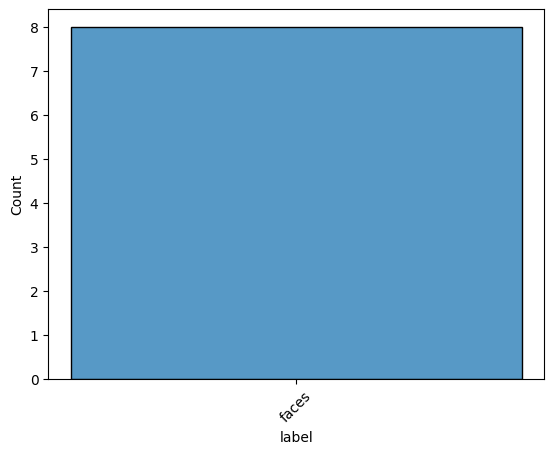

In [39]:
ax = sns.histplot(df.label)
ax.tick_params(axis="x", rotation=45);

The data looks quite unbalanced...  
**<u>TO DO</u>:** Use stratified sampling or try balancing the dataset using over/under-sampling methods (SMOTE, etc.), data augmentation, etc. 

## Preparing the Data

### The Manual Way

**NOTE:** I initially started on this path until I realized halfway through that I didn't need to do any of this stuff. But I'm going to leave this section in anyway.

Let's encode the labels first. We could use `sklearn.preprocessing.OneHotEncoder`, but I'd like to use `tf.keras.utils.to_categorical` this time...

In [40]:
i = 0
label_dict = {}
with os.scandir(data_path) as entries:
    for entry in entries:
        entry_path = os.path.join(data_path, entry)
        if os.path.isdir(entry_path):
            label_dict[entry.name] = i
        i = i + 1
label_dict

{'faces': 0}

In [41]:
df["label_int"] = df.label.apply(lambda x: label_dict[x])

df.sample(n=5)

,filename,label,label_int
6,surprise,faces,0
5,happiness,faces,0
3,sadness,faces,0
4,contempt,faces,0
7,anger,faces,0


In [42]:
from tensorflow.keras.utils import to_categorical

n_classes = len(label_dict)
y = to_categorical(df.label_int, n_classes)
y

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)

Let's also replace the `filename` column with the full path to each file to make things easier...

In [43]:
df["filepath"] = df.apply(
    lambda x: os.path.join(data_path, x["label"], x["filename"]), axis=1
)
df.drop(columns="filename", inplace=True)

In [44]:
df.sample(n=5)

,label,label_int,filepath
0,faces,0,/home/nathan/code/nihonlanguageprocessing/huma...
2,faces,0,/home/nathan/code/nihonlanguageprocessing/huma...
6,faces,0,/home/nathan/code/nihonlanguageprocessing/huma...
4,faces,0,/home/nathan/code/nihonlanguageprocessing/huma...
7,faces,0,/home/nathan/code/nihonlanguageprocessing/huma...


In [45]:
X = df.filepath
X

0    /home/nathan/code/nihonlanguageprocessing/huma...
1    /home/nathan/code/nihonlanguageprocessing/huma...
2    /home/nathan/code/nihonlanguageprocessing/huma...
3    /home/nathan/code/nihonlanguageprocessing/huma...
4    /home/nathan/code/nihonlanguageprocessing/huma...
5    /home/nathan/code/nihonlanguageprocessing/huma...
6    /home/nathan/code/nihonlanguageprocessing/huma...
7    /home/nathan/code/nihonlanguageprocessing/huma...
Name: filepath, dtype: object

Now we have everything we need in order to create the training, validation and test data sets.

In [48]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=random_state
)
10

10

### Using TensorFlow Keras Utilities

Turns out we didn't need to do any of that, because `tf.keras.utils.image_dataset_from_directory` will take care of everything for us.

In [49]:
# Some common CONSTants...

BATCH_SIZE = 32
IMG_DIM = 224 # height = width
N_CHANNELS = 3 # The input images are greyscale but we need RGB in order to use pre-trained models

# Note: In Python 3.7+ dictionaries are ordered.
class_names = list(label_dict.keys())

In [50]:
ds_train, ds_val_test = tf.keras.utils.image_dataset_from_directory(
    directory=data_path,
    labels="inferred",
    label_mode="categorical",
    class_names=class_names,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=(IMG_DIM, IMG_DIM),
    shuffle=True,
    seed=random_state,
    validation_split=0.2,
    subset="both",
)

Found 5558 files belonging to 1 classes.
Using 4447 files for training.
Using 1111 files for validation.


In [51]:
val_test_batches = tf.data.experimental.cardinality(ds_val_test)
ds_val = ds_val_test.take(val_test_batches // 2)
ds_test = ds_val_test.skip(val_test_batches // 2)

## Modeling

### Basline Model

What would be a good baseline model and score to use as a reference point?

In [52]:
# TO DO

### Transfer Learning

Let's get a pre-trained model and fine-tune it to our task.

In [53]:
# Some more CONSTants...

LR = 1e-5
N_EPOCHS = 100

DO_1 = 0.4
DO_2 = 0.2
L2_REG_1 = 0.01
L2_REG_2 = 0.003

In [54]:
def get_pretrained_model():
    model_pretrained = tf.keras.applications.vgg16.VGG16(include_top=False, input_shape=(IMG_DIM, IMG_DIM, N_CHANNELS))
    model_pretrained.trainable = False
    return model_pretrained

In [55]:
pretrained = get_pretrained_model()
pretrained.summary()

58889256/58889256 [==============================] - 6s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [56]:
def get_compiled_custom_model(num_classes):
    base_model = get_pretrained_model()
    flattening_layer = tf.keras.layers.Flatten()
    dense_layer_1 = tf.keras.layers.Dense(
        100, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(L2_REG_1)
    )
    dropout_layer_1 = tf.keras.layers.Dropout(DO_1)
    dense_layer_2 = tf.keras.layers.Dense(
        50, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(L2_REG_2)
    )
    dropout_layer_2 = tf.keras.layers.Dropout(DO_2)
    # dense_layer_3 = tf.keras.layers.Dense(
    #     25, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(L2_REG)
    # )
    # dropout_layer_3 = tf.keras.layers.Dropout(DO3)
    prediction_layer = tf.keras.layers.Dense(num_classes, activation="softmax")

    model = tf.keras.models.Sequential(
        [
            base_model,
            flattening_layer,
            dense_layer_1,
            dropout_layer_1,
            dense_layer_2,
            dropout_layer_2,
            # dense_layer_3,
            # dropout_layer_3,
            prediction_layer,
        ]
    )

    opt = tf.keras.optimizers.Adam(learning_rate=LR)

    model.compile(
        optimizer=opt,
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model

In [57]:
model = get_compiled_custom_model(num_classes=n_classes)

In [58]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 100)               2508900   
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 5

In [59]:
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=5,
    verbose=1,
    restore_best_weights=True,
)
history = model.fit(
    ds_train, epochs=N_EPOCHS, validation_data=ds_val, verbose=1, callbacks=[es]
)

Epoch 1/100


2023-04-29 15:32:57.449998: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [4447]
	 [[{{node Placeholder/_4}}]]
2023-04-29 15:32:57.450344: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [4447]
	 [[{{node Placeholder/_4}}]]
/home/nathan/.pyenv/versions/3.8.13/envs/human_emotion/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossent

  2/139 [..............................] - ETA: 7:23 - loss: 2.1915 - accuracy: 1.0000 

2023-04-29 15:33:05.297385: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 15:33:05.299776: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 7:22 - loss: 2.1876 - accuracy: 1.0000

2023-04-29 15:33:11.890203: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 7:24 - loss: 2.1819 - accuracy: 1.0000

2023-04-29 15:33:22.275435: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 7:24 - loss: 2.1799 - accuracy: 1.0000

2023-04-29 15:33:25.818022: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 7:24 - loss: 2.1780 - accuracy: 1.0000

2023-04-29 15:33:29.385136: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 15:33:29.395625: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 7:24 - loss: 2.1761 - accuracy: 1.0000

2023-04-29 15:33:33.041729: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 7:19 - loss: 2.1723 - accuracy: 1.0000

2023-04-29 15:33:40.147607: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 7:07 - loss: 2.1627 - accuracy: 1.0000

2023-04-29 15:33:58.059646: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 6:55 - loss: 2.1551 - accuracy: 1.0000

2023-04-29 15:34:12.441365: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 6:52 - loss: 2.1532 - accuracy: 1.0000

2023-04-29 15:34:16.025746: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 7:22 - loss: 2.1513 - accuracy: 1.0000

2023-04-29 15:34:26.065052: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 7:38 - loss: 2.1494 - accuracy: 1.0000

2023-04-29 15:34:33.731688: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 15:34:33.738263: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 7:59 - loss: 2.1418 - accuracy: 1.0000

2023-04-29 15:34:58.685851: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 15:34:58.727058: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 8:09 - loss: 2.1342 - accuracy: 1.0000

2023-04-29 15:35:23.878441: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 8:07 - loss: 2.1305 - accuracy: 1.0000

2023-04-29 15:35:35.217476: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 8:09 - loss: 2.1267 - accuracy: 1.0000

2023-04-29 15:35:48.326573: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 8:09 - loss: 2.1249 - accuracy: 1.0000

2023-04-29 15:35:54.790897: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 15:35:54.832203: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 15:35:54.832481: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 8:00 - loss: 2.1137 - accuracy: 1.0000

2023-04-29 15:36:32.469695: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 45/139 [========>.....................] - ETA: 8:02 - loss: 2.1100 - accuracy: 1.0000

2023-04-29 15:36:48.037920: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 8:04 - loss: 2.1081 - accuracy: 1.0000

2023-04-29 15:36:56.485356: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 8:16 - loss: 2.1007 - accuracy: 1.0000

2023-04-29 15:37:35.415315: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 8:21 - loss: 2.0970 - accuracy: 1.0000

2023-04-29 15:37:55.998827: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 15:37:56.012698: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 15:37:56.031617: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 8:21 - loss: 2.0952 - accuracy: 1.0000

2023-04-29 15:38:05.184088: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 8:22 - loss: 2.0933 - accuracy: 1.0000

2023-04-29 15:38:15.365089: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 57/139 [===========>..................] - ETA: 8:24 - loss: 2.0878 - accuracy: 1.0000

2023-04-29 15:38:46.405423: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 8:18 - loss: 2.0805 - accuracy: 1.0000

2023-04-29 15:39:25.830519: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 15:39:25.878098: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 8:14 - loss: 2.0769 - accuracy: 1.0000

2023-04-29 15:39:45.706490: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 8:12 - loss: 2.0751 - accuracy: 1.0000

2023-04-29 15:39:55.743657: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 7:49 - loss: 2.0624 - accuracy: 1.0000

2023-04-29 15:41:05.631478: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 15:41:05.700519: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 7:41 - loss: 2.0588 - accuracy: 1.0000

2023-04-29 15:41:25.870310: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 15:41:25.878621: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 7:23 - loss: 2.0517 - accuracy: 1.0000

2023-04-29 15:42:05.244073: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 6:50 - loss: 2.0445 - accuracy: 1.0000

2023-04-29 15:42:28.721202: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 15:42:28.734815: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 15:42:28.739582: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 6:42 - loss: 2.0427 - accuracy: 1.0000

2023-04-29 15:42:33.453995: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 6:33 - loss: 2.0410 - accuracy: 1.0000

2023-04-29 15:42:37.657355: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 6:24 - loss: 2.0392 - accuracy: 1.0000

2023-04-29 15:42:42.291223: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 6:16 - loss: 2.0374 - accuracy: 1.0000

2023-04-29 15:42:47.040456: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 5:58 - loss: 2.0339 - accuracy: 1.0000

2023-04-29 15:42:55.578514: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 5:42 - loss: 2.0304 - accuracy: 1.0000

2023-04-29 15:43:05.057262: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 5:19 - loss: 2.0251 - accuracy: 1.0000

2023-04-29 15:43:20.460675: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 15:43:20.465853: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 15:43:20.471705: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 4:49 - loss: 2.0181 - accuracy: 1.0000

2023-04-29 15:43:42.531976: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 4:42 - loss: 2.0163 - accuracy: 1.0000

2023-04-29 15:43:47.112776: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 4:19 - loss: 2.0111 - accuracy: 1.0000

2023-04-29 15:44:00.579974: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 4:12 - loss: 2.0094 - accuracy: 1.0000

2023-04-29 15:44:05.306156: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 15:44:05.321638: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 4:04 - loss: 2.0076 - accuracy: 1.0000

2023-04-29 15:44:10.204725: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 3:57 - loss: 2.0059 - accuracy: 1.0000

2023-04-29 15:44:15.338391: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 15:44:15.356203: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 3:43 - loss: 2.0024 - accuracy: 1.0000

2023-04-29 15:44:26.344159: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 3:15 - loss: 1.9955 - accuracy: 1.0000

2023-04-29 15:44:46.632268: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 2:48 - loss: 1.9887 - accuracy: 1.0000

2023-04-29 15:45:05.919049: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 15:45:05.921074: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 2:34 - loss: 1.9853 - accuracy: 1.0000

2023-04-29 15:45:17.002640: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 15:45:17.010680: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 15:45:17.013856: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 2:28 - loss: 1.9836 - accuracy: 1.0000

2023-04-29 15:45:22.670574: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 2:07 - loss: 1.9784 - accuracy: 1.0000

2023-04-29 15:45:36.969725: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 2:01 - loss: 1.9767 - accuracy: 1.0000

2023-04-29 15:45:41.530485: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 15:45:41.544943: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 1:54 - loss: 1.9750 - accuracy: 1.0000

2023-04-29 15:45:46.322701: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 1:48 - loss: 1.9734 - accuracy: 1.0000

2023-04-29 15:45:51.277820: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 15:45:51.277911: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 15:45:51.279403: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 15:45:51.292406: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 1:41 - loss: 1.9717 - accuracy: 1.0000

2023-04-29 15:45:56.455676: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 1:35 - loss: 1.9700 - accuracy: 1.0000

2023-04-29 15:46:02.017423: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 15:46:02.020075: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 1:28 - loss: 1.9683 - accuracy: 1.0000

2023-04-29 15:46:07.562018: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 1:22 - loss: 1.9666 - accuracy: 1.0000

2023-04-29 15:46:13.301865: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 1.9449 - accuracy: 1.0000

2023-04-29 15:47:19.538974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1111]
	 [[{{node Placeholder/_0}}]]
2023-04-29 15:47:19.539421: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1111]
	 [[{{node Placeholder/_4}}]]
2023-04-29 15:47:31.009942: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 15:47:31.035173: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted 

139/139 [==============================] - 946s 7s/step - loss: 1.9449 - accuracy: 1.0000 - val_loss: 1.7126 - val_accuracy: 1.0000
Epoch 2/100


2023-04-29 15:48:43.943356: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 15:48:43.945049: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 15:48:43.951403: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 15:48:43.954926: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 15:48:43.963949: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 8:13 - loss: 1.7111 - accuracy: 1.0000

2023-04-29 15:48:51.198355: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 15:48:51.198605: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 8:18 - loss: 1.7081 - accuracy: 1.0000

2023-04-29 15:48:58.669284: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 8:08 - loss: 1.7035 - accuracy: 1.0000

2023-04-29 15:49:09.777221: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 8:04 - loss: 1.7020 - accuracy: 1.0000

2023-04-29 15:49:13.506452: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 8:00 - loss: 1.7005 - accuracy: 1.0000

2023-04-29 15:49:17.184997: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 15:49:17.193782: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 7:58 - loss: 1.6990 - accuracy: 1.0000

2023-04-29 15:49:20.986976: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 7:53 - loss: 1.6960 - accuracy: 1.0000

2023-04-29 15:49:28.604383: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 7:36 - loss: 1.6885 - accuracy: 1.0000

2023-04-29 15:49:47.421834: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 7:24 - loss: 1.6826 - accuracy: 1.0000

2023-04-29 15:50:02.859784: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 7:20 - loss: 1.6811 - accuracy: 1.0000

2023-04-29 15:50:06.669086: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 7:17 - loss: 1.6796 - accuracy: 1.0000

2023-04-29 15:50:10.523497: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 7:14 - loss: 1.6781 - accuracy: 1.0000

2023-04-29 15:50:14.405102: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 15:50:14.409215: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 7:01 - loss: 1.6722 - accuracy: 1.0000

2023-04-29 15:50:30.203116: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 15:50:30.207822: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 6:47 - loss: 1.6664 - accuracy: 1.0000

2023-04-29 15:50:45.705712: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 6:40 - loss: 1.6634 - accuracy: 1.0000

2023-04-29 15:50:53.442650: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 6:33 - loss: 1.6605 - accuracy: 1.0000

2023-04-29 15:51:01.143720: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 6:29 - loss: 1.6591 - accuracy: 1.0000

2023-04-29 15:51:05.007601: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 15:51:05.016151: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 15:51:05.016357: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 6:07 - loss: 1.6504 - accuracy: 1.0000

2023-04-29 15:51:28.573411: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 45/139 [========>.....................] - ETA: 6:00 - loss: 1.6475 - accuracy: 1.0000

2023-04-29 15:51:36.377501: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 5:56 - loss: 1.6460 - accuracy: 1.0000

2023-04-29 15:51:40.269122: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 5:42 - loss: 1.6403 - accuracy: 1.0000

2023-04-29 15:51:55.969773: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 5:34 - loss: 1.6374 - accuracy: 1.0000

2023-04-29 15:52:03.782962: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 15:52:03.786793: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 15:52:03.794361: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 5:30 - loss: 1.6360 - accuracy: 1.0000

2023-04-29 15:52:07.715629: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 5:27 - loss: 1.6346 - accuracy: 1.0000

2023-04-29 15:52:11.638875: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 57/139 [===========>..................] - ETA: 5:16 - loss: 1.6303 - accuracy: 1.0000

2023-04-29 15:52:23.614741: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 5:01 - loss: 1.6246 - accuracy: 1.0000

2023-04-29 15:52:39.408602: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 15:52:39.411431: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 4:53 - loss: 1.6218 - accuracy: 1.0000

2023-04-29 15:52:47.204667: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 4:49 - loss: 1.6204 - accuracy: 1.0000

2023-04-29 15:52:51.106242: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 4:23 - loss: 1.6106 - accuracy: 1.0000

2023-04-29 15:53:18.797374: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 15:53:18.810358: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 4:15 - loss: 1.6078 - accuracy: 1.0000

2023-04-29 15:53:26.785834: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 15:53:26.787193: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 4:01 - loss: 1.6022 - accuracy: 1.0000

2023-04-29 15:53:43.185710: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 3:51 - loss: 1.5967 - accuracy: 1.0000

2023-04-29 15:54:07.213339: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 15:54:07.229166: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 15:54:07.238526: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 3:51 - loss: 1.5953 - accuracy: 1.0000

2023-04-29 15:54:16.567966: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 3:49 - loss: 1.5939 - accuracy: 1.0000

2023-04-29 15:54:23.933224: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 3:46 - loss: 1.5925 - accuracy: 1.0000

2023-04-29 15:54:28.854221: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 3:42 - loss: 1.5912 - accuracy: 1.0000

2023-04-29 15:54:34.121630: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 3:36 - loss: 1.5884 - accuracy: 1.0000

2023-04-29 15:54:45.713769: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 3:30 - loss: 1.5857 - accuracy: 1.0000

2023-04-29 15:54:57.594906: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 3:19 - loss: 1.5816 - accuracy: 1.0000

2023-04-29 15:55:13.591808: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 15:55:13.593901: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 15:55:13.596820: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 3:04 - loss: 1.5761 - accuracy: 1.0000

2023-04-29 15:55:35.179650: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 3:00 - loss: 1.5748 - accuracy: 1.0000

2023-04-29 15:55:41.038399: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 2:50 - loss: 1.5707 - accuracy: 1.0000

2023-04-29 15:55:59.156893: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 2:46 - loss: 1.5694 - accuracy: 1.0000

2023-04-29 15:56:06.026257: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 15:56:06.057685: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 2:43 - loss: 1.5680 - accuracy: 1.0000

2023-04-29 15:56:13.568399: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 2:39 - loss: 1.5667 - accuracy: 1.0000

2023-04-29 15:56:20.286927: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 15:56:20.312952: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 2:34 - loss: 1.5640 - accuracy: 1.0000

2023-04-29 15:56:38.895979: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 2:18 - loss: 1.5586 - accuracy: 1.0000

2023-04-29 15:57:05.758874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 2:02 - loss: 1.5533 - accuracy: 1.0000

2023-04-29 15:57:33.306942: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 15:57:33.308584: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 1:53 - loss: 1.5506 - accuracy: 1.0000

2023-04-29 15:57:46.664936: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 15:57:46.669546: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 15:57:46.670325: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 1:49 - loss: 1.5493 - accuracy: 1.0000

2023-04-29 15:57:53.224238: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 1:35 - loss: 1.5454 - accuracy: 1.0000

2023-04-29 15:58:13.245851: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 1:31 - loss: 1.5440 - accuracy: 1.0000

2023-04-29 15:58:19.724322: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 15:58:19.753064: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 1:26 - loss: 1.5427 - accuracy: 1.0000

2023-04-29 15:58:26.308415: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 1:22 - loss: 1.5414 - accuracy: 1.0000

2023-04-29 15:58:32.812775: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 15:58:32.812855: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 15:58:32.812893: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 15:58:32.834208: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 1:17 - loss: 1.5401 - accuracy: 1.0000

2023-04-29 15:58:39.188141: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 1:12 - loss: 1.5388 - accuracy: 1.0000

2023-04-29 15:58:45.638996: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 15:58:45.640022: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 1:08 - loss: 1.5375 - accuracy: 1.0000

2023-04-29 15:58:52.099680: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 1:03 - loss: 1.5361 - accuracy: 1.0000

2023-04-29 15:58:58.605447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 1.5193 - accuracy: 1.0000

2023-04-29 16:00:48.416040: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:00:53.262550: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:00:59.195793: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:01:04.334564: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:01:23.717095: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:01:23.725799: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29

139/139 [==============================] - 849s 6s/step - loss: 1.5193 - accuracy: 1.0000 - val_loss: 1.3389 - val_accuracy: 1.0000
Epoch 3/100


2023-04-29 16:02:52.674983: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:02:52.686331: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:02:52.720967: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:02:52.735074: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:02:52.767953: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 22:01 - loss: 1.3377 - accuracy: 1.0000

2023-04-29 16:03:13.043570: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:03:13.051587: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 24:25 - loss: 1.3354 - accuracy: 1.0000

2023-04-29 16:03:35.928124: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 23:07 - loss: 1.3318 - accuracy: 1.0000

2023-04-29 16:04:06.406443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 22:52 - loss: 1.3307 - accuracy: 1.0000

2023-04-29 16:04:16.701541: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 22:46 - loss: 1.3295 - accuracy: 1.0000

2023-04-29 16:04:27.430525: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:04:27.456857: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 22:27 - loss: 1.3283 - accuracy: 1.0000

2023-04-29 16:04:37.380435: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 21:43 - loss: 1.3260 - accuracy: 1.0000

2023-04-29 16:04:56.296244: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 20:30 - loss: 1.3202 - accuracy: 1.0000

2023-04-29 16:05:44.745211: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 19:38 - loss: 1.3155 - accuracy: 1.0000

2023-04-29 16:06:23.195715: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 19:26 - loss: 1.3144 - accuracy: 1.0000

2023-04-29 16:06:32.723418: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 19:13 - loss: 1.3132 - accuracy: 1.0000

2023-04-29 16:06:42.202877: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 19:03 - loss: 1.3121 - accuracy: 1.0000

2023-04-29 16:06:52.088178: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:06:52.096001: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 18:19 - loss: 1.3075 - accuracy: 1.0000

2023-04-29 16:07:30.761078: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:07:30.787109: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 17:31 - loss: 1.3029 - accuracy: 1.0000

2023-04-29 16:08:07.979006: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 17:10 - loss: 1.3007 - accuracy: 1.0000

2023-04-29 16:08:27.078975: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 16:48 - loss: 1.2984 - accuracy: 1.0000

2023-04-29 16:08:45.926592: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 16:37 - loss: 1.2973 - accuracy: 1.0000

2023-04-29 16:08:55.233430: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:08:55.253570: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 16:08:55.253647: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 15:40 - loss: 1.2905 - accuracy: 1.0000

2023-04-29 16:09:55.033743: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 45/139 [========>.....................] - ETA: 15:21 - loss: 1.2882 - accuracy: 1.0000

2023-04-29 16:10:14.473474: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 15:11 - loss: 1.2871 - accuracy: 1.0000

2023-04-29 16:10:24.608640: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 14:32 - loss: 1.2827 - accuracy: 1.0000

2023-04-29 16:11:03.587873: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 14:10 - loss: 1.2804 - accuracy: 1.0000

2023-04-29 16:11:21.894961: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:11:21.902680: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:11:21.938627: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 14:00 - loss: 1.2793 - accuracy: 1.0000

2023-04-29 16:11:31.291113: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 13:49 - loss: 1.2782 - accuracy: 1.0000

2023-04-29 16:11:40.616433: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 57/139 [===========>..................] - ETA: 13:19 - loss: 1.2749 - accuracy: 1.0000

2023-04-29 16:12:09.145376: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 12:39 - loss: 1.2705 - accuracy: 1.0000

2023-04-29 16:12:47.834416: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:12:47.847096: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 12:19 - loss: 1.2683 - accuracy: 1.0000

2023-04-29 16:13:06.488879: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 12:08 - loss: 1.2672 - accuracy: 1.0000

2023-04-29 16:13:15.619578: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 10:54 - loss: 1.2596 - accuracy: 1.0000

2023-04-29 16:14:17.392693: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:14:17.436997: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 10:35 - loss: 1.2574 - accuracy: 1.0000

2023-04-29 16:14:37.189645: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:14:37.203400: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 9:56 - loss: 1.2531 - accuracy: 1.0000 

2023-04-29 16:15:14.998123: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 9:18 - loss: 1.2488 - accuracy: 1.0000

2023-04-29 16:15:53.711458: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:15:53.735173: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:15:53.740246: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 9:09 - loss: 1.2477 - accuracy: 1.0000

2023-04-29 16:16:04.398040: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 9:00 - loss: 1.2466 - accuracy: 1.0000

2023-04-29 16:16:14.149057: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 8:50 - loss: 1.2455 - accuracy: 1.0000

2023-04-29 16:16:24.007053: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 8:40 - loss: 1.2445 - accuracy: 1.0000

2023-04-29 16:16:33.418207: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 8:19 - loss: 1.2423 - accuracy: 1.0000

2023-04-29 16:16:49.745550: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 7:55 - loss: 1.2402 - accuracy: 1.0000

2023-04-29 16:17:00.673877: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 7:20 - loss: 1.2370 - accuracy: 1.0000

2023-04-29 16:17:15.613931: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:17:15.623274: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:17:15.634235: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 6:46 - loss: 1.2328 - accuracy: 1.0000

2023-04-29 16:18:00.704930: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 6:36 - loss: 1.2317 - accuracy: 1.0000

2023-04-29 16:18:10.508147: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 6:09 - loss: 1.2286 - accuracy: 1.0000

2023-04-29 16:18:40.093216: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 5:59 - loss: 1.2275 - accuracy: 1.0000

2023-04-29 16:18:49.538330: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:18:49.572448: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 5:50 - loss: 1.2265 - accuracy: 1.0000

2023-04-29 16:18:59.036526: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 5:40 - loss: 1.2254 - accuracy: 1.0000

2023-04-29 16:19:08.688622: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:19:08.730257: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 5:22 - loss: 1.2234 - accuracy: 1.0000

2023-04-29 16:19:29.053439: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 4:44 - loss: 1.2192 - accuracy: 1.0000

2023-04-29 16:20:08.446272: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 4:07 - loss: 1.2151 - accuracy: 1.0000

2023-04-29 16:20:47.896143: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:20:47.899044: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 3:48 - loss: 1.2130 - accuracy: 1.0000

2023-04-29 16:21:06.742466: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:21:06.749569: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:21:06.752441: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 3:38 - loss: 1.2120 - accuracy: 1.0000

2023-04-29 16:21:16.057605: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 3:10 - loss: 1.2089 - accuracy: 1.0000

2023-04-29 16:21:44.803560: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 3:00 - loss: 1.2079 - accuracy: 1.0000

2023-04-29 16:21:54.188357: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:21:54.225306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 2:51 - loss: 1.2068 - accuracy: 1.0000

2023-04-29 16:22:03.814331: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 2:41 - loss: 1.2058 - accuracy: 1.0000

2023-04-29 16:22:13.309374: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:22:13.323556: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 16:22:13.323722: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:22:13.343151: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 2:32 - loss: 1.2048 - accuracy: 1.0000

2023-04-29 16:22:24.312950: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 2:22 - loss: 1.2038 - accuracy: 1.0000

2023-04-29 16:22:32.489950: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:22:32.500257: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 2:12 - loss: 1.2027 - accuracy: 1.0000

2023-04-29 16:22:37.030904: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 2:03 - loss: 1.2017 - accuracy: 1.0000

2023-04-29 16:22:46.794106: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 1.1886 - accuracy: 1.0000

2023-04-29 16:24:52.504083: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:25:02.083148: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:25:11.679563: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:25:21.413529: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:25:41.041349: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:25:41.050843: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29

139/139 [==============================] - 1473s 11s/step - loss: 1.1886 - accuracy: 1.0000 - val_loss: 1.0485 - val_accuracy: 1.0000
Epoch 4/100


2023-04-29 16:27:26.134604: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:27:26.140252: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:27:26.163005: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:27:26.173324: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:27:26.202035: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 21:49 - loss: 1.0475 - accuracy: 1.0000

2023-04-29 16:27:46.197683: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:27:46.214511: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 21:00 - loss: 1.0457 - accuracy: 1.0000

2023-04-29 16:28:04.644745: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 20:54 - loss: 1.0430 - accuracy: 1.0000

2023-04-29 16:28:33.614400: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 20:58 - loss: 1.0421 - accuracy: 1.0000

2023-04-29 16:28:43.875788: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 20:58 - loss: 1.0412 - accuracy: 1.0000

2023-04-29 16:28:54.067988: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:28:54.091952: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 20:53 - loss: 1.0403 - accuracy: 1.0000

2023-04-29 16:29:04.133075: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 20:44 - loss: 1.0384 - accuracy: 1.0000

2023-04-29 16:29:24.409718: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 19:35 - loss: 1.0339 - accuracy: 1.0000

2023-04-29 16:30:10.781669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 17:54 - loss: 1.0303 - accuracy: 1.0000

2023-04-29 16:30:38.781679: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 17:48 - loss: 1.0294 - accuracy: 1.0000

2023-04-29 16:30:48.440446: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 17:42 - loss: 1.0285 - accuracy: 1.0000

2023-04-29 16:30:58.219240: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 17:44 - loss: 1.0277 - accuracy: 1.0000

2023-04-29 16:31:09.548321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:31:09.551489: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 17:18 - loss: 1.0241 - accuracy: 1.0000

2023-04-29 16:31:49.210357: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:31:49.239647: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 16:40 - loss: 1.0206 - accuracy: 1.0000

2023-04-29 16:32:26.461414: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 16:24 - loss: 1.0188 - accuracy: 1.0000

2023-04-29 16:32:46.096363: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 15:38 - loss: 1.0170 - accuracy: 1.0000

2023-04-29 16:32:55.644055: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 15:17 - loss: 1.0161 - accuracy: 1.0000

2023-04-29 16:33:00.367360: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:33:00.388231: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 16:33:00.388395: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 13:34 - loss: 1.0109 - accuracy: 1.0000

2023-04-29 16:33:32.767206: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 45/139 [========>.....................] - ETA: 13:06 - loss: 1.0092 - accuracy: 1.0000

2023-04-29 16:33:44.592777: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 12:51 - loss: 1.0083 - accuracy: 1.0000

2023-04-29 16:33:50.083911: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 11:54 - loss: 1.0048 - accuracy: 1.0000

2023-04-29 16:34:10.008714: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 11:28 - loss: 1.0031 - accuracy: 1.0000

2023-04-29 16:34:20.352831: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:34:20.358419: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:34:20.366986: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 11:15 - loss: 1.0022 - accuracy: 1.0000

2023-04-29 16:34:25.354139: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 11:03 - loss: 1.0014 - accuracy: 1.0000

2023-04-29 16:34:30.266593: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 57/139 [===========>..................] - ETA: 10:27 - loss: 0.9988 - accuracy: 1.0000

2023-04-29 16:34:45.431625: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 9:45 - loss: 0.9954 - accuracy: 1.0000

2023-04-29 16:35:06.983998: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:35:06.991206: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 9:29 - loss: 0.9937 - accuracy: 1.0000

2023-04-29 16:35:20.971564: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 9:20 - loss: 0.9928 - accuracy: 1.0000

2023-04-29 16:35:27.573640: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 8:14 - loss: 0.9869 - accuracy: 1.0000

2023-04-29 16:36:05.245405: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:36:05.260724: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 7:54 - loss: 0.9852 - accuracy: 1.0000

2023-04-29 16:36:14.779862: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:36:14.783440: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 7:18 - loss: 0.9819 - accuracy: 1.0000

2023-04-29 16:36:34.730127: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 6:45 - loss: 0.9785 - accuracy: 1.0000

2023-04-29 16:36:56.486136: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:36:56.500588: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:36:56.504976: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 6:38 - loss: 0.9777 - accuracy: 1.0000

2023-04-29 16:37:02.641631: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 6:30 - loss: 0.9769 - accuracy: 1.0000

2023-04-29 16:37:08.703622: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 6:23 - loss: 0.9760 - accuracy: 1.0000

2023-04-29 16:37:15.360612: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 6:16 - loss: 0.9752 - accuracy: 1.0000

2023-04-29 16:37:22.836402: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 6:01 - loss: 0.9735 - accuracy: 1.0000

2023-04-29 16:37:34.245180: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 5:45 - loss: 0.9719 - accuracy: 1.0000

2023-04-29 16:37:44.410223: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 5:21 - loss: 0.9694 - accuracy: 1.0000

2023-04-29 16:37:58.895174: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:37:58.895410: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:37:58.899414: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 4:51 - loss: 0.9662 - accuracy: 1.0000

2023-04-29 16:38:20.104491: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 4:43 - loss: 0.9653 - accuracy: 1.0000

2023-04-29 16:38:25.743928: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 4:22 - loss: 0.9629 - accuracy: 1.0000

2023-04-29 16:38:42.173590: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 4:14 - loss: 0.9621 - accuracy: 1.0000

2023-04-29 16:38:47.642300: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:38:47.657459: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 4:07 - loss: 0.9613 - accuracy: 1.0000

2023-04-29 16:38:53.019370: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 4:00 - loss: 0.9605 - accuracy: 1.0000

2023-04-29 16:38:58.536841: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:38:58.549859: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 3:46 - loss: 0.9588 - accuracy: 1.0000

2023-04-29 16:39:09.117660: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 3:17 - loss: 0.9556 - accuracy: 1.0000

2023-04-29 16:39:29.170199: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 2:49 - loss: 0.9524 - accuracy: 1.0000

2023-04-29 16:39:48.074391: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:39:48.077353: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 2:36 - loss: 0.9508 - accuracy: 1.0000

2023-04-29 16:39:58.501050: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:39:58.504354: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:39:58.520638: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 2:29 - loss: 0.9500 - accuracy: 1.0000

2023-04-29 16:40:04.092258: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 2:09 - loss: 0.9476 - accuracy: 1.0000

2023-04-29 16:40:19.060310: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 2:02 - loss: 0.9468 - accuracy: 1.0000

2023-04-29 16:40:23.807221: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:40:23.822247: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 1:55 - loss: 0.9460 - accuracy: 1.0000

2023-04-29 16:40:28.976105: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 1:49 - loss: 0.9452 - accuracy: 1.0000

2023-04-29 16:40:34.164165: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:40:34.165305: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 16:40:34.165358: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:40:34.174266: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 1:42 - loss: 0.9444 - accuracy: 1.0000

2023-04-29 16:40:39.177129: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 1:35 - loss: 0.9437 - accuracy: 1.0000

2023-04-29 16:40:43.697428: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:40:43.698704: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 1:29 - loss: 0.9429 - accuracy: 1.0000

2023-04-29 16:40:48.244361: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 1:22 - loss: 0.9421 - accuracy: 1.0000

2023-04-29 16:40:52.756058: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 0.9319 - accuracy: 1.0000

2023-04-29 16:41:56.724846: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:42:01.236504: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:42:05.742362: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:42:10.224753: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:42:19.256568: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:42:19.261318: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29

139/139 [==============================] - 946s 7s/step - loss: 0.9319 - accuracy: 1.0000 - val_loss: 0.8234 - val_accuracy: 1.0000
Epoch 5/100


2023-04-29 16:43:11.945850: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:43:11.948339: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:43:11.962405: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:43:11.969752: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:43:11.990345: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 10:59 - loss: 0.8227 - accuracy: 1.0000

2023-04-29 16:43:21.742502: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:43:21.744408: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 11:09 - loss: 0.8213 - accuracy: 1.0000

2023-04-29 16:43:31.809852: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 11:13 - loss: 0.8191 - accuracy: 1.0000

2023-04-29 16:43:47.525784: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 11:15 - loss: 0.8184 - accuracy: 1.0000

2023-04-29 16:43:53.015684: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 11:16 - loss: 0.8177 - accuracy: 1.0000

2023-04-29 16:43:58.576810: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:43:58.586024: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 11:15 - loss: 0.8170 - accuracy: 1.0000

2023-04-29 16:44:04.092060: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 11:10 - loss: 0.8156 - accuracy: 1.0000

2023-04-29 16:44:14.999290: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 10:36 - loss: 0.8121 - accuracy: 1.0000

2023-04-29 16:44:40.354592: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 10:22 - loss: 0.8094 - accuracy: 1.0000

2023-04-29 16:45:02.358642: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 10:16 - loss: 0.8087 - accuracy: 1.0000

2023-04-29 16:45:07.653902: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 10:06 - loss: 0.8080 - accuracy: 1.0000

2023-04-29 16:45:11.966165: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 9:58 - loss: 0.8073 - accuracy: 1.0000 

2023-04-29 16:45:16.698241: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:45:16.700045: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 9:27 - loss: 0.8045 - accuracy: 1.0000

2023-04-29 16:45:34.935954: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:45:34.943154: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 9:04 - loss: 0.8018 - accuracy: 1.0000

2023-04-29 16:45:54.561180: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 8:59 - loss: 0.8004 - accuracy: 1.0000

2023-04-29 16:46:06.624765: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 8:45 - loss: 0.7991 - accuracy: 1.0000

2023-04-29 16:46:15.626025: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 8:39 - loss: 0.7984 - accuracy: 1.0000

2023-04-29 16:46:20.234466: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:46:20.245955: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 16:46:20.246127: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 8:08 - loss: 0.7943 - accuracy: 1.0000

2023-04-29 16:46:50.856896: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 45/139 [========>.....................] - ETA: 8:03 - loss: 0.7930 - accuracy: 1.0000

2023-04-29 16:47:03.122101: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 8:00 - loss: 0.7923 - accuracy: 1.0000

2023-04-29 16:47:09.248659: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 7:48 - loss: 0.7897 - accuracy: 1.0000

2023-04-29 16:47:34.856185: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 7:41 - loss: 0.7883 - accuracy: 1.0000

2023-04-29 16:47:47.297969: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:47:47.304362: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:47:47.319251: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 7:36 - loss: 0.7877 - accuracy: 1.0000

2023-04-29 16:47:52.646900: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 7:30 - loss: 0.7870 - accuracy: 1.0000

2023-04-29 16:47:58.106874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 57/139 [===========>..................] - ETA: 7:15 - loss: 0.7850 - accuracy: 1.0000

2023-04-29 16:48:14.343713: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 6:52 - loss: 0.7824 - accuracy: 1.0000

2023-04-29 16:48:34.524065: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:48:34.529883: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 6:40 - loss: 0.7810 - accuracy: 1.0000

2023-04-29 16:48:43.512697: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 6:34 - loss: 0.7804 - accuracy: 1.0000

2023-04-29 16:48:48.381009: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 5:58 - loss: 0.7758 - accuracy: 1.0000

2023-04-29 16:49:26.176265: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:49:26.184111: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 5:48 - loss: 0.7745 - accuracy: 1.0000

2023-04-29 16:49:37.007132: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:49:37.010448: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 5:26 - loss: 0.7719 - accuracy: 1.0000

2023-04-29 16:49:57.006299: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 5:04 - loss: 0.7694 - accuracy: 1.0000

2023-04-29 16:50:16.236419: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:50:16.251819: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:50:16.257276: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 4:59 - loss: 0.7687 - accuracy: 1.0000

2023-04-29 16:50:21.939852: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 4:53 - loss: 0.7681 - accuracy: 1.0000

2023-04-29 16:50:26.584152: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 4:47 - loss: 0.7674 - accuracy: 1.0000

2023-04-29 16:50:31.048317: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 4:42 - loss: 0.7668 - accuracy: 1.0000

2023-04-29 16:50:36.118096: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 4:32 - loss: 0.7655 - accuracy: 1.0000

2023-04-29 16:50:47.246120: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 4:21 - loss: 0.7642 - accuracy: 1.0000

2023-04-29 16:50:57.990116: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 4:06 - loss: 0.7623 - accuracy: 1.0000

2023-04-29 16:51:14.496925: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:51:14.499387: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:51:14.502388: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 3:44 - loss: 0.7598 - accuracy: 1.0000

2023-04-29 16:51:33.255322: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 3:39 - loss: 0.7592 - accuracy: 1.0000

2023-04-29 16:51:38.213204: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 3:23 - loss: 0.7573 - accuracy: 1.0000

2023-04-29 16:51:52.889263: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 3:18 - loss: 0.7567 - accuracy: 1.0000

2023-04-29 16:51:58.379956: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:51:58.401516: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 3:13 - loss: 0.7560 - accuracy: 1.0000

2023-04-29 16:52:03.921570: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 3:07 - loss: 0.7554 - accuracy: 1.0000

2023-04-29 16:52:09.467529: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:52:09.484686: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 2:57 - loss: 0.7542 - accuracy: 1.0000

2023-04-29 16:52:20.571668: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 2:36 - loss: 0.7517 - accuracy: 1.0000

2023-04-29 16:52:39.570794: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 2:15 - loss: 0.7492 - accuracy: 1.0000

2023-04-29 16:52:59.467286: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:52:59.468403: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 2:04 - loss: 0.7480 - accuracy: 1.0000

2023-04-29 16:53:08.180323: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:53:08.183241: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:53:08.185212: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 1:59 - loss: 0.7474 - accuracy: 1.0000

2023-04-29 16:53:12.943959: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 1:43 - loss: 0.7455 - accuracy: 1.0000

2023-04-29 16:53:28.874895: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 1:38 - loss: 0.7449 - accuracy: 1.0000

2023-04-29 16:53:34.527753: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:53:34.546709: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 1:33 - loss: 0.7443 - accuracy: 1.0000

2023-04-29 16:53:40.225843: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 1:28 - loss: 0.7437 - accuracy: 1.0000

2023-04-29 16:53:45.941566: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:53:45.942479: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 16:53:45.942517: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:53:45.957843: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 1:23 - loss: 0.7431 - accuracy: 1.0000

2023-04-29 16:53:51.523628: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 1:18 - loss: 0.7425 - accuracy: 1.0000

2023-04-29 16:53:57.153873: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:53:57.155277: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 1:12 - loss: 0.7419 - accuracy: 1.0000

2023-04-29 16:54:02.723227: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 1:07 - loss: 0.7413 - accuracy: 1.0000

2023-04-29 16:54:08.384715: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 0.7334 - accuracy: 1.0000

2023-04-29 16:55:22.382652: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:55:27.974661: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:55:32.674581: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:55:36.750740: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:55:46.155889: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:55:46.161253: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29

139/139 [==============================] - 811s 6s/step - loss: 0.7334 - accuracy: 1.0000 - val_loss: 0.6498 - val_accuracy: 1.0000
Epoch 6/100


2023-04-29 16:56:42.468004: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:56:42.470680: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:56:42.487420: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:56:42.497668: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:56:42.514502: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 12:14 - loss: 0.6493 - accuracy: 1.0000

2023-04-29 16:56:52.850148: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:56:52.853734: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 11:12 - loss: 0.6482 - accuracy: 1.0000

2023-04-29 16:57:02.432564: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 11:07 - loss: 0.6466 - accuracy: 1.0000

2023-04-29 16:57:17.839021: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 11:18 - loss: 0.6460 - accuracy: 1.0000

2023-04-29 16:57:23.726888: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 11:17 - loss: 0.6455 - accuracy: 1.0000

2023-04-29 16:57:29.201468: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:57:29.215732: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 11:02 - loss: 0.6450 - accuracy: 1.0000

2023-04-29 16:57:33.730500: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 10:44 - loss: 0.6439 - accuracy: 1.0000

2023-04-29 16:57:43.289993: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 10:15 - loss: 0.6412 - accuracy: 1.0000

2023-04-29 16:58:08.259167: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 9:58 - loss: 0.6391 - accuracy: 1.0000 

2023-04-29 16:58:28.922513: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 9:57 - loss: 0.6385 - accuracy: 1.0000

2023-04-29 16:58:34.676614: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 9:56 - loss: 0.6380 - accuracy: 1.0000

2023-04-29 16:58:40.698066: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 9:53 - loss: 0.6375 - accuracy: 1.0000

2023-04-29 16:58:46.198572: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:58:46.201141: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 9:26 - loss: 0.6354 - accuracy: 1.0000

2023-04-29 16:59:05.284058: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:59:05.300837: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 9:14 - loss: 0.6333 - accuracy: 1.0000

2023-04-29 16:59:28.065299: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 8:59 - loss: 0.6322 - accuracy: 1.0000

2023-04-29 16:59:36.941643: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 8:48 - loss: 0.6312 - accuracy: 1.0000

2023-04-29 16:59:46.971270: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 8:44 - loss: 0.6307 - accuracy: 1.0000

2023-04-29 16:59:52.663944: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 16:59:52.690347: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 16:59:52.690632: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 8:17 - loss: 0.6276 - accuracy: 1.0000

2023-04-29 17:00:25.061657: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 45/139 [========>.....................] - ETA: 8:08 - loss: 0.6265 - accuracy: 1.0000

2023-04-29 17:00:36.149607: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 8:02 - loss: 0.6260 - accuracy: 1.0000

2023-04-29 17:00:40.920132: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 7:44 - loss: 0.6240 - accuracy: 1.0000

2023-04-29 17:01:03.305984: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 7:36 - loss: 0.6229 - accuracy: 1.0000

2023-04-29 17:01:15.034663: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:01:15.040151: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:01:15.049428: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 7:31 - loss: 0.6224 - accuracy: 1.0000

2023-04-29 17:01:20.666426: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 7:26 - loss: 0.6219 - accuracy: 1.0000

2023-04-29 17:01:25.614946: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 57/139 [===========>..................] - ETA: 7:07 - loss: 0.6204 - accuracy: 1.0000

2023-04-29 17:01:39.160213: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 6:47 - loss: 0.6184 - accuracy: 1.0000

2023-04-29 17:02:01.150128: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:02:01.156598: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 6:36 - loss: 0.6174 - accuracy: 1.0000

2023-04-29 17:02:10.660587: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 6:29 - loss: 0.6168 - accuracy: 1.0000

2023-04-29 17:02:14.897162: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 5:53 - loss: 0.6133 - accuracy: 1.0000

2023-04-29 17:02:51.554258: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:02:51.575373: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 5:41 - loss: 0.6123 - accuracy: 1.0000

2023-04-29 17:02:59.914540: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:02:59.917827: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 5:16 - loss: 0.6104 - accuracy: 1.0000

2023-04-29 17:03:15.917798: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 4:56 - loss: 0.6084 - accuracy: 1.0000

2023-04-29 17:03:36.350745: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:03:36.357091: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:03:36.360856: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 4:50 - loss: 0.6079 - accuracy: 1.0000

2023-04-29 17:03:40.492384: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 4:44 - loss: 0.6074 - accuracy: 1.0000

2023-04-29 17:03:44.433217: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 4:39 - loss: 0.6069 - accuracy: 1.0000

2023-04-29 17:03:48.595490: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 4:33 - loss: 0.6064 - accuracy: 1.0000

2023-04-29 17:03:53.042159: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 4:22 - loss: 0.6055 - accuracy: 1.0000

2023-04-29 17:04:02.303875: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 4:12 - loss: 0.6045 - accuracy: 1.0000

2023-04-29 17:04:11.936312: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 3:57 - loss: 0.6030 - accuracy: 1.0000

2023-04-29 17:04:26.771544: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:04:26.772210: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:04:26.775698: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 3:35 - loss: 0.6011 - accuracy: 1.0000

2023-04-29 17:04:43.111616: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 3:30 - loss: 0.6006 - accuracy: 1.0000

2023-04-29 17:04:47.525084: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 3:14 - loss: 0.5992 - accuracy: 1.0000

2023-04-29 17:05:01.943807: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 3:09 - loss: 0.5987 - accuracy: 1.0000

2023-04-29 17:05:06.271904: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:05:06.282130: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 3:04 - loss: 0.5982 - accuracy: 1.0000

2023-04-29 17:05:09.974223: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 2:58 - loss: 0.5977 - accuracy: 1.0000

2023-04-29 17:05:14.118376: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:05:14.129360: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 2:48 - loss: 0.5968 - accuracy: 1.0000

2023-04-29 17:05:22.749907: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 2:27 - loss: 0.5949 - accuracy: 1.0000

2023-04-29 17:05:39.723903: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 2:07 - loss: 0.5930 - accuracy: 1.0000

2023-04-29 17:05:56.693327: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:05:56.698299: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 1:57 - loss: 0.5920 - accuracy: 1.0000

2023-04-29 17:06:04.798061: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:06:04.804372: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:06:04.804787: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 1:52 - loss: 0.5916 - accuracy: 1.0000

2023-04-29 17:06:08.962806: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 1:37 - loss: 0.5901 - accuracy: 1.0000

2023-04-29 17:06:22.587635: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 1:32 - loss: 0.5897 - accuracy: 1.0000

2023-04-29 17:06:27.199248: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:06:27.209258: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 1:27 - loss: 0.5892 - accuracy: 1.0000

2023-04-29 17:06:31.172847: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 1:22 - loss: 0.5887 - accuracy: 1.0000

2023-04-29 17:06:35.010897: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:06:35.012453: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 17:06:35.012499: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:06:35.019745: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 1:17 - loss: 0.5883 - accuracy: 1.0000

2023-04-29 17:06:39.319935: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 1:12 - loss: 0.5878 - accuracy: 1.0000

2023-04-29 17:06:43.746916: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:06:43.749344: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 1:07 - loss: 0.5873 - accuracy: 1.0000

2023-04-29 17:06:48.382567: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 1:03 - loss: 0.5869 - accuracy: 1.0000

2023-04-29 17:06:53.595946: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 0.5809 - accuracy: 1.0000

2023-04-29 17:08:12.779683: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:08:12.802759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:08:20.269301: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:08:27.315736: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:08:41.034015: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:08:41.039862: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29

139/139 [==============================] - 771s 6s/step - loss: 0.5809 - accuracy: 1.0000 - val_loss: 0.5170 - val_accuracy: 1.0000
Epoch 7/100


2023-04-29 17:09:33.555962: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:09:33.558662: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:09:33.569057: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:09:33.576169: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:09:33.587626: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 10:29 - loss: 0.5166 - accuracy: 1.0000

2023-04-29 17:09:42.683167: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:09:42.685531: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 9:51 - loss: 0.5157 - accuracy: 1.0000

2023-04-29 17:09:51.247058: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 9:24 - loss: 0.5145 - accuracy: 1.0000

2023-04-29 17:10:03.743496: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 9:26 - loss: 0.5141 - accuracy: 1.0000

2023-04-29 17:10:08.340290: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 9:27 - loss: 0.5137 - accuracy: 1.0000

2023-04-29 17:10:13.033841: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:10:13.043805: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 9:31 - loss: 0.5133 - accuracy: 1.0000

2023-04-29 17:10:17.978734: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 9:21 - loss: 0.5124 - accuracy: 1.0000

2023-04-29 17:10:26.744057: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 8:40 - loss: 0.5104 - accuracy: 1.0000

2023-04-29 17:10:46.326787: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 8:11 - loss: 0.5088 - accuracy: 1.0000

2023-04-29 17:11:01.386324: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 8:03 - loss: 0.5084 - accuracy: 1.0000

2023-04-29 17:11:04.898749: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 7:56 - loss: 0.5080 - accuracy: 1.0000

2023-04-29 17:11:08.417055: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 7:49 - loss: 0.5076 - accuracy: 1.0000

2023-04-29 17:11:12.021427: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:11:12.023783: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 7:25 - loss: 0.5060 - accuracy: 1.0000

2023-04-29 17:11:26.571375: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:11:26.575547: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 7:12 - loss: 0.5044 - accuracy: 1.0000

2023-04-29 17:11:43.437800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 7:09 - loss: 0.5036 - accuracy: 1.0000

2023-04-29 17:11:53.018856: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 7:00 - loss: 0.5028 - accuracy: 1.0000

2023-04-29 17:12:00.973991: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 6:56 - loss: 0.5024 - accuracy: 1.0000

2023-04-29 17:12:05.027578: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:12:05.038773: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 17:12:05.038843: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 6:33 - loss: 0.5000 - accuracy: 1.0000

2023-04-29 17:12:30.115463: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 45/139 [========>.....................] - ETA: 6:25 - loss: 0.4992 - accuracy: 1.0000

2023-04-29 17:12:38.608822: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 6:21 - loss: 0.4988 - accuracy: 1.0000

2023-04-29 17:12:42.818155: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 6:07 - loss: 0.4973 - accuracy: 1.0000

2023-04-29 17:13:00.326676: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 5:59 - loss: 0.4965 - accuracy: 1.0000

2023-04-29 17:13:08.607392: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:13:08.612315: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:13:08.618444: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 5:55 - loss: 0.4961 - accuracy: 1.0000

2023-04-29 17:13:13.081076: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 5:52 - loss: 0.4957 - accuracy: 1.0000

2023-04-29 17:13:17.787814: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 57/139 [===========>..................] - ETA: 5:41 - loss: 0.4946 - accuracy: 1.0000

2023-04-29 17:13:31.325009: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 5:26 - loss: 0.4930 - accuracy: 1.0000

2023-04-29 17:13:49.359328: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:13:49.366314: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 5:19 - loss: 0.4922 - accuracy: 1.0000

2023-04-29 17:13:58.375557: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 5:14 - loss: 0.4919 - accuracy: 1.0000

2023-04-29 17:14:02.624995: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 4:47 - loss: 0.4892 - accuracy: 1.0000

2023-04-29 17:14:34.531910: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:14:34.540111: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 4:39 - loss: 0.4884 - accuracy: 1.0000

2023-04-29 17:14:43.397362: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:14:43.398376: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 4:23 - loss: 0.4869 - accuracy: 1.0000

2023-04-29 17:15:01.240907: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 4:06 - loss: 0.4854 - accuracy: 1.0000

2023-04-29 17:15:18.527012: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:15:18.532926: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:15:18.537238: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 4:02 - loss: 0.4851 - accuracy: 1.0000

2023-04-29 17:15:22.800006: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 3:58 - loss: 0.4847 - accuracy: 1.0000

2023-04-29 17:15:27.174457: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 3:54 - loss: 0.4843 - accuracy: 1.0000

2023-04-29 17:15:31.461403: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 3:49 - loss: 0.4839 - accuracy: 1.0000

2023-04-29 17:15:35.840901: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 3:41 - loss: 0.4832 - accuracy: 1.0000

2023-04-29 17:15:44.296630: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 3:33 - loss: 0.4825 - accuracy: 1.0000

2023-04-29 17:15:53.141727: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 3:20 - loss: 0.4814 - accuracy: 1.0000

2023-04-29 17:16:05.971657: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:16:05.973953: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:16:05.975644: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 3:03 - loss: 0.4799 - accuracy: 1.0000

2023-04-29 17:16:23.262737: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 2:59 - loss: 0.4795 - accuracy: 1.0000

2023-04-29 17:16:27.446588: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 2:46 - loss: 0.4784 - accuracy: 1.0000

2023-04-29 17:16:40.151444: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 2:42 - loss: 0.4781 - accuracy: 1.0000

2023-04-29 17:16:44.448607: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:16:44.456510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 2:37 - loss: 0.4777 - accuracy: 1.0000

2023-04-29 17:16:48.589827: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 2:33 - loss: 0.4773 - accuracy: 1.0000

2023-04-29 17:16:52.902637: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:16:52.911515: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 2:24 - loss: 0.4766 - accuracy: 1.0000

2023-04-29 17:17:01.172952: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 2:07 - loss: 0.4752 - accuracy: 1.0000

2023-04-29 17:17:18.019725: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 1:50 - loss: 0.4737 - accuracy: 1.0000

2023-04-29 17:17:34.333096: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:17:34.335728: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 1:42 - loss: 0.4730 - accuracy: 1.0000

2023-04-29 17:17:42.719252: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:17:42.724147: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:17:42.724358: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 1:37 - loss: 0.4727 - accuracy: 1.0000

2023-04-29 17:17:46.999151: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 1:25 - loss: 0.4716 - accuracy: 1.0000

2023-04-29 17:17:59.711673: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 1:20 - loss: 0.4712 - accuracy: 1.0000

2023-04-29 17:18:03.712652: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:18:03.721225: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 1:16 - loss: 0.4709 - accuracy: 1.0000

2023-04-29 17:18:07.838674: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 1:12 - loss: 0.4705 - accuracy: 1.0000

2023-04-29 17:18:12.219208: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:18:12.221955: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 17:18:12.221997: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:18:12.231090: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 1:07 - loss: 0.4702 - accuracy: 1.0000

2023-04-29 17:18:16.445001: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 1:03 - loss: 0.4698 - accuracy: 1.0000

2023-04-29 17:18:20.798024: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:18:20.801083: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 59s - loss: 0.4695 - accuracy: 1.0000 

2023-04-29 17:18:25.062525: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 55s - loss: 0.4691 - accuracy: 1.0000

2023-04-29 17:18:29.327234: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 0.4646 - accuracy: 1.0000

2023-04-29 17:19:32.766845: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:19:32.777213: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:19:36.928439: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:19:41.174746: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:19:49.910075: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:19:49.912271: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29

139/139 [==============================] - 663s 5s/step - loss: 0.4646 - accuracy: 1.0000 - val_loss: 0.4161 - val_accuracy: 1.0000
Epoch 8/100


2023-04-29 17:20:36.986801: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:20:36.988524: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:20:36.996766: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:20:37.001900: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:20:37.012070: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 9:20 - loss: 0.4158 - accuracy: 1.0000

2023-04-29 17:20:45.324959: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:20:45.327322: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 9:28 - loss: 0.4152 - accuracy: 1.0000

2023-04-29 17:20:53.869995: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 9:17 - loss: 0.4143 - accuracy: 1.0000

2023-04-29 17:21:06.552101: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 9:12 - loss: 0.4139 - accuracy: 1.0000

2023-04-29 17:21:10.736833: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 9:07 - loss: 0.4136 - accuracy: 1.0000

2023-04-29 17:21:14.937553: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:21:14.948198: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 9:03 - loss: 0.4133 - accuracy: 1.0000

2023-04-29 17:21:19.119017: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 8:54 - loss: 0.4127 - accuracy: 1.0000

2023-04-29 17:21:27.520191: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 8:30 - loss: 0.4112 - accuracy: 1.0000

2023-04-29 17:21:48.219384: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 8:13 - loss: 0.4099 - accuracy: 1.0000

2023-04-29 17:22:04.913737: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 8:08 - loss: 0.4096 - accuracy: 1.0000

2023-04-29 17:22:08.918295: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 8:03 - loss: 0.4093 - accuracy: 1.0000

2023-04-29 17:22:12.931841: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 7:59 - loss: 0.4090 - accuracy: 1.0000

2023-04-29 17:22:17.214172: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:22:17.216637: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 7:44 - loss: 0.4078 - accuracy: 1.0000

2023-04-29 17:22:34.271390: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:22:34.277566: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 7:28 - loss: 0.4066 - accuracy: 1.0000

2023-04-29 17:22:51.172731: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 7:22 - loss: 0.4060 - accuracy: 1.0000

2023-04-29 17:23:00.144931: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 7:07 - loss: 0.4054 - accuracy: 1.0000

2023-04-29 17:23:06.619681: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 7:00 - loss: 0.4051 - accuracy: 1.0000

2023-04-29 17:23:09.567305: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:23:09.577021: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 17:23:09.577234: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 6:25 - loss: 0.4033 - accuracy: 1.0000

2023-04-29 17:23:29.966287: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 45/139 [========>.....................] - ETA: 6:15 - loss: 0.4027 - accuracy: 1.0000

2023-04-29 17:23:37.054818: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 6:10 - loss: 0.4024 - accuracy: 1.0000

2023-04-29 17:23:40.430446: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 5:50 - loss: 0.4012 - accuracy: 1.0000

2023-04-29 17:23:54.072804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 5:40 - loss: 0.4007 - accuracy: 1.0000

2023-04-29 17:24:00.753449: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:24:00.763731: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:24:00.770227: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 5:35 - loss: 0.4004 - accuracy: 1.0000

2023-04-29 17:24:04.328778: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 5:31 - loss: 0.4001 - accuracy: 1.0000

2023-04-29 17:24:07.759947: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 57/139 [===========>..................] - ETA: 5:17 - loss: 0.3992 - accuracy: 1.0000

2023-04-29 17:24:17.940775: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 4:59 - loss: 0.3980 - accuracy: 1.0000

2023-04-29 17:24:31.956335: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:24:31.961162: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 4:51 - loss: 0.3975 - accuracy: 1.0000

2023-04-29 17:24:38.988483: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 4:47 - loss: 0.3972 - accuracy: 1.0000

2023-04-29 17:24:42.437291: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 4:18 - loss: 0.3952 - accuracy: 1.0000

2023-04-29 17:25:06.884904: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:25:06.892420: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 4:09 - loss: 0.3946 - accuracy: 1.0000

2023-04-29 17:25:13.713189: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:25:13.713939: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 3:53 - loss: 0.3935 - accuracy: 1.0000

2023-04-29 17:25:27.223328: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 3:37 - loss: 0.3923 - accuracy: 1.0000

2023-04-29 17:25:41.786656: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:25:41.791807: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:25:41.794204: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 3:34 - loss: 0.3921 - accuracy: 1.0000

2023-04-29 17:25:45.629003: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 3:30 - loss: 0.3918 - accuracy: 1.0000

2023-04-29 17:25:49.377660: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 3:26 - loss: 0.3915 - accuracy: 1.0000

2023-04-29 17:25:53.116817: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 3:22 - loss: 0.3912 - accuracy: 1.0000

2023-04-29 17:25:56.828089: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 3:15 - loss: 0.3907 - accuracy: 1.0000

2023-04-29 17:26:04.284261: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 3:07 - loss: 0.3901 - accuracy: 1.0000

2023-04-29 17:26:11.784643: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 2:56 - loss: 0.3893 - accuracy: 1.0000

2023-04-29 17:26:22.788075: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:26:22.789275: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:26:22.791432: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 2:41 - loss: 0.3882 - accuracy: 1.0000

2023-04-29 17:26:37.869544: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 2:37 - loss: 0.3879 - accuracy: 1.0000

2023-04-29 17:26:41.597100: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 2:26 - loss: 0.3871 - accuracy: 1.0000

2023-04-29 17:26:52.911476: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 2:22 - loss: 0.3868 - accuracy: 1.0000

2023-04-29 17:26:56.631737: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:26:56.642067: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 2:18 - loss: 0.3865 - accuracy: 1.0000

2023-04-29 17:27:00.575935: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 2:15 - loss: 0.3862 - accuracy: 1.0000

2023-04-29 17:27:04.341339: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:27:04.348033: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 2:07 - loss: 0.3857 - accuracy: 1.0000

2023-04-29 17:27:11.951832: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 1:52 - loss: 0.3846 - accuracy: 1.0000

2023-04-29 17:27:26.964505: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 1:37 - loss: 0.3835 - accuracy: 1.0000

2023-04-29 17:27:42.051242: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:27:42.051812: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 1:30 - loss: 0.3830 - accuracy: 1.0000

2023-04-29 17:27:49.770712: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:27:49.773744: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:27:49.774419: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 1:26 - loss: 0.3827 - accuracy: 1.0000

2023-04-29 17:27:53.499509: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 1:15 - loss: 0.3819 - accuracy: 1.0000

2023-04-29 17:28:05.226378: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 1:11 - loss: 0.3816 - accuracy: 1.0000

2023-04-29 17:28:09.137653: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:28:09.145483: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 1:07 - loss: 0.3814 - accuracy: 1.0000

2023-04-29 17:28:12.981658: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 1:04 - loss: 0.3811 - accuracy: 1.0000

2023-04-29 17:28:16.791461: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:28:16.793192: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 17:28:16.793238: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:28:16.799905: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 1:00 - loss: 0.3808 - accuracy: 1.0000

2023-04-29 17:28:20.696077: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 56s - loss: 0.3806 - accuracy: 1.0000 

2023-04-29 17:28:24.450880: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:28:24.453003: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 52s - loss: 0.3803 - accuracy: 1.0000

2023-04-29 17:28:28.333667: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 48s - loss: 0.3801 - accuracy: 1.0000

2023-04-29 17:28:32.073368: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 0.3767 - accuracy: 1.0000

2023-04-29 17:29:25.552319: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:29:29.355484: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:29:33.273288: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:29:37.023399: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:29:44.742255: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:29:44.742569: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29

139/139 [==============================] - 590s 4s/step - loss: 0.3767 - accuracy: 1.0000 - val_loss: 0.3403 - val_accuracy: 1.0000
Epoch 9/100


2023-04-29 17:30:27.052505: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:30:27.054240: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:30:27.061315: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:30:27.065508: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:30:27.073971: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 8:43 - loss: 0.3400 - accuracy: 1.0000

2023-04-29 17:30:34.826862: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:30:34.828509: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 8:45 - loss: 0.3396 - accuracy: 1.0000

2023-04-29 17:30:42.690582: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 8:38 - loss: 0.3389 - accuracy: 1.0000

2023-04-29 17:30:54.548638: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 8:32 - loss: 0.3386 - accuracy: 1.0000

2023-04-29 17:30:58.403594: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 8:28 - loss: 0.3384 - accuracy: 1.0000

2023-04-29 17:31:02.310992: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:31:02.321543: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 8:23 - loss: 0.3382 - accuracy: 1.0000

2023-04-29 17:31:06.170042: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 8:19 - loss: 0.3377 - accuracy: 1.0000

2023-04-29 17:31:14.229506: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 7:59 - loss: 0.3366 - accuracy: 1.0000

2023-04-29 17:31:33.831395: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 7:44 - loss: 0.3356 - accuracy: 1.0000

2023-04-29 17:31:49.786246: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 7:40 - loss: 0.3354 - accuracy: 1.0000

2023-04-29 17:31:53.718977: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 7:37 - loss: 0.3352 - accuracy: 1.0000

2023-04-29 17:31:57.710289: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 7:33 - loss: 0.3350 - accuracy: 1.0000

2023-04-29 17:32:01.602025: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:32:01.602919: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 7:17 - loss: 0.3341 - accuracy: 1.0000

2023-04-29 17:32:17.450666: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:32:17.454751: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 7:02 - loss: 0.3332 - accuracy: 1.0000

2023-04-29 17:32:33.401856: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 6:54 - loss: 0.3327 - accuracy: 1.0000

2023-04-29 17:32:41.279338: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 6:46 - loss: 0.3323 - accuracy: 1.0000

2023-04-29 17:32:49.211993: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 6:42 - loss: 0.3320 - accuracy: 1.0000

2023-04-29 17:32:53.117456: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:32:53.124670: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 17:32:53.124737: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 6:19 - loss: 0.3307 - accuracy: 1.0000

2023-04-29 17:33:16.974405: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 45/139 [========>.....................] - ETA: 6:14 - loss: 0.3303 - accuracy: 1.0000

2023-04-29 17:33:26.145016: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 6:19 - loss: 0.3300 - accuracy: 1.0000

2023-04-29 17:33:34.635974: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 6:08 - loss: 0.3292 - accuracy: 1.0000

2023-04-29 17:33:54.053135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 6:00 - loss: 0.3287 - accuracy: 1.0000

2023-04-29 17:34:02.357698: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:34:02.364661: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:34:02.370371: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 5:57 - loss: 0.3285 - accuracy: 1.0000

2023-04-29 17:34:07.033439: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 5:54 - loss: 0.3283 - accuracy: 1.0000

2023-04-29 17:34:12.226649: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 57/139 [===========>..................] - ETA: 5:42 - loss: 0.3276 - accuracy: 1.0000

2023-04-29 17:34:24.996825: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 5:29 - loss: 0.3268 - accuracy: 1.0000

2023-04-29 17:34:44.297423: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:34:44.305101: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 5:22 - loss: 0.3263 - accuracy: 1.0000

2023-04-29 17:34:54.325230: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 5:19 - loss: 0.3261 - accuracy: 1.0000

2023-04-29 17:34:59.108275: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 4:55 - loss: 0.3246 - accuracy: 1.0000

2023-04-29 17:35:35.278831: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:35:35.290473: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 4:48 - loss: 0.3242 - accuracy: 1.0000

2023-04-29 17:35:45.905013: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:35:45.906172: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 4:32 - loss: 0.3234 - accuracy: 1.0000

2023-04-29 17:36:04.779931: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 4:14 - loss: 0.3225 - accuracy: 1.0000

2023-04-29 17:36:22.601833: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:36:22.606250: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:36:22.610458: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 4:10 - loss: 0.3223 - accuracy: 1.0000

2023-04-29 17:36:27.447783: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 4:06 - loss: 0.3221 - accuracy: 1.0000

2023-04-29 17:36:32.457790: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 4:02 - loss: 0.3219 - accuracy: 1.0000

2023-04-29 17:36:37.590138: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 3:58 - loss: 0.3217 - accuracy: 1.0000

2023-04-29 17:36:42.728395: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 3:50 - loss: 0.3213 - accuracy: 1.0000

2023-04-29 17:36:53.006387: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 3:42 - loss: 0.3208 - accuracy: 1.0000

2023-04-29 17:37:02.908742: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 3:28 - loss: 0.3202 - accuracy: 1.0000

2023-04-29 17:37:15.042969: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:37:15.043942: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:37:15.048387: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 3:11 - loss: 0.3194 - accuracy: 1.0000

2023-04-29 17:37:33.643707: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 3:07 - loss: 0.3192 - accuracy: 1.0000

2023-04-29 17:37:38.608381: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 2:54 - loss: 0.3186 - accuracy: 1.0000

2023-04-29 17:37:54.062759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 2:50 - loss: 0.3184 - accuracy: 1.0000

2023-04-29 17:37:58.867259: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:37:58.878988: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 2:45 - loss: 0.3182 - accuracy: 1.0000

2023-04-29 17:38:04.105320: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 2:41 - loss: 0.3180 - accuracy: 1.0000

2023-04-29 17:38:09.038864: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:38:09.049475: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 2:32 - loss: 0.3176 - accuracy: 1.0000

2023-04-29 17:38:18.911725: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 2:15 - loss: 0.3168 - accuracy: 1.0000

2023-04-29 17:38:38.715815: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 1:57 - loss: 0.3159 - accuracy: 1.0000

2023-04-29 17:38:58.921400: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:38:58.923352: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 1:49 - loss: 0.3155 - accuracy: 1.0000

2023-04-29 17:39:09.322703: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:39:09.327663: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:39:09.329602: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 1:44 - loss: 0.3153 - accuracy: 1.0000

2023-04-29 17:39:14.070915: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 1:31 - loss: 0.3147 - accuracy: 1.0000

2023-04-29 17:39:28.928177: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 1:26 - loss: 0.3146 - accuracy: 1.0000

2023-04-29 17:39:34.078559: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:39:34.090600: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 1:22 - loss: 0.3144 - accuracy: 1.0000

2023-04-29 17:39:39.118636: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 1:17 - loss: 0.3142 - accuracy: 1.0000

2023-04-29 17:39:44.233905: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 17:39:44.233966: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:39:44.234002: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:39:44.243847: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 1:13 - loss: 0.3140 - accuracy: 1.0000

2023-04-29 17:39:49.321072: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 1:08 - loss: 0.3138 - accuracy: 1.0000

2023-04-29 17:39:54.300238: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:39:54.301946: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 1:04 - loss: 0.3136 - accuracy: 1.0000

2023-04-29 17:39:59.054378: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 59s - loss: 0.3134 - accuracy: 1.0000 

2023-04-29 17:40:03.490241: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 0.3108 - accuracy: 1.0000

2023-04-29 17:41:02.945477: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:41:06.501037: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:41:10.175967: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:41:13.896911: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:41:21.197541: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:41:21.198470: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29

139/139 [==============================] - 696s 5s/step - loss: 0.3108 - accuracy: 1.0000 - val_loss: 0.2838 - val_accuracy: 1.0000
Epoch 10/100


2023-04-29 17:42:02.939054: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:42:02.940629: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:42:02.948056: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:42:02.952460: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:42:02.961097: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 8:47 - loss: 0.2836 - accuracy: 1.0000

2023-04-29 17:42:10.654701: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:42:10.657092: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 8:43 - loss: 0.2833 - accuracy: 1.0000

2023-04-29 17:42:18.426671: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 8:31 - loss: 0.2828 - accuracy: 1.0000

2023-04-29 17:42:30.058405: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 8:27 - loss: 0.2826 - accuracy: 1.0000

2023-04-29 17:42:33.917164: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 8:22 - loss: 0.2824 - accuracy: 1.0000

2023-04-29 17:42:37.717052: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:42:37.727473: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 8:17 - loss: 0.2822 - accuracy: 1.0000

2023-04-29 17:42:41.545761: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 8:10 - loss: 0.2819 - accuracy: 1.0000

2023-04-29 17:42:49.319960: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 7:53 - loss: 0.2810 - accuracy: 1.0000

2023-04-29 17:43:08.901531: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 7:39 - loss: 0.2804 - accuracy: 1.0000

2023-04-29 17:43:24.614262: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 7:35 - loss: 0.2802 - accuracy: 1.0000

2023-04-29 17:43:28.557448: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 7:31 - loss: 0.2800 - accuracy: 1.0000

2023-04-29 17:43:32.353992: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 7:27 - loss: 0.2799 - accuracy: 1.0000

2023-04-29 17:43:36.259581: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:43:36.260589: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 7:12 - loss: 0.2792 - accuracy: 1.0000

2023-04-29 17:43:52.010263: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:43:52.015280: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 6:57 - loss: 0.2785 - accuracy: 1.0000

2023-04-29 17:44:07.702020: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 6:49 - loss: 0.2782 - accuracy: 1.0000

2023-04-29 17:44:15.546953: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 6:42 - loss: 0.2779 - accuracy: 1.0000

2023-04-29 17:44:23.419349: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 6:38 - loss: 0.2777 - accuracy: 1.0000

2023-04-29 17:44:27.378872: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:44:27.391272: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 17:44:27.391614: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 6:15 - loss: 0.2767 - accuracy: 1.0000

2023-04-29 17:44:50.903373: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 45/139 [========>.....................] - ETA: 6:07 - loss: 0.2764 - accuracy: 1.0000

2023-04-29 17:44:58.703362: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 6:03 - loss: 0.2762 - accuracy: 1.0000

2023-04-29 17:45:02.698430: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 5:48 - loss: 0.2756 - accuracy: 1.0000

2023-04-29 17:45:18.547538: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 5:40 - loss: 0.2752 - accuracy: 1.0000

2023-04-29 17:45:26.402258: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:45:26.405753: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:45:26.411742: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 5:36 - loss: 0.2751 - accuracy: 1.0000

2023-04-29 17:45:30.331315: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 5:32 - loss: 0.2749 - accuracy: 1.0000

2023-04-29 17:45:34.315665: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 57/139 [===========>..................] - ETA: 5:20 - loss: 0.2744 - accuracy: 1.0000

2023-04-29 17:45:45.865989: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 5:05 - loss: 0.2738 - accuracy: 1.0000

2023-04-29 17:46:01.757194: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:46:01.762620: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 4:57 - loss: 0.2735 - accuracy: 1.0000

2023-04-29 17:46:09.547190: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 4:53 - loss: 0.2733 - accuracy: 1.0000

2023-04-29 17:46:13.520529: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 4:26 - loss: 0.2722 - accuracy: 1.0000

2023-04-29 17:46:41.329667: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:46:41.339961: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 4:18 - loss: 0.2719 - accuracy: 1.0000

2023-04-29 17:46:49.336779: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:46:49.337561: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 4:03 - loss: 0.2713 - accuracy: 1.0000

2023-04-29 17:47:05.079532: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 3:47 - loss: 0.2707 - accuracy: 1.0000

2023-04-29 17:47:20.800168: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:47:20.807943: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:47:20.810972: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 3:43 - loss: 0.2705 - accuracy: 1.0000

2023-04-29 17:47:24.845133: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 3:39 - loss: 0.2704 - accuracy: 1.0000

2023-04-29 17:47:28.797625: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 3:35 - loss: 0.2702 - accuracy: 1.0000

2023-04-29 17:47:32.765757: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 3:32 - loss: 0.2700 - accuracy: 1.0000

2023-04-29 17:47:36.707776: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 3:24 - loss: 0.2697 - accuracy: 1.0000

2023-04-29 17:47:44.484028: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 3:16 - loss: 0.2694 - accuracy: 1.0000

2023-04-29 17:47:52.297926: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 3:04 - loss: 0.2690 - accuracy: 1.0000

2023-04-29 17:48:04.147190: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:48:04.148036: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:48:04.152150: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 2:49 - loss: 0.2684 - accuracy: 1.0000

2023-04-29 17:48:20.238367: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 2:45 - loss: 0.2682 - accuracy: 1.0000

2023-04-29 17:48:24.223211: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 2:33 - loss: 0.2678 - accuracy: 1.0000

2023-04-29 17:48:36.249871: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 2:29 - loss: 0.2676 - accuracy: 1.0000

2023-04-29 17:48:40.217069: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:48:40.223371: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 2:25 - loss: 0.2675 - accuracy: 1.0000

2023-04-29 17:48:45.258828: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 2:23 - loss: 0.2673 - accuracy: 1.0000

2023-04-29 17:48:52.451256: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:48:52.465123: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 2:15 - loss: 0.2670 - accuracy: 1.0000

2023-04-29 17:49:02.447364: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 2:00 - loss: 0.2664 - accuracy: 1.0000

2023-04-29 17:49:18.821057: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 1:44 - loss: 0.2658 - accuracy: 1.0000

2023-04-29 17:49:35.519494: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:49:35.520467: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 1:36 - loss: 0.2655 - accuracy: 1.0000

2023-04-29 17:49:44.053264: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:49:44.057684: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:49:44.057802: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 1:32 - loss: 0.2654 - accuracy: 1.0000

2023-04-29 17:49:48.642901: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 1:20 - loss: 0.2649 - accuracy: 1.0000

2023-04-29 17:50:01.570086: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 1:16 - loss: 0.2648 - accuracy: 1.0000

2023-04-29 17:50:05.720937: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:50:05.732967: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 1:12 - loss: 0.2646 - accuracy: 1.0000

2023-04-29 17:50:10.247934: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 1:08 - loss: 0.2645 - accuracy: 1.0000

2023-04-29 17:50:14.544861: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:50:14.545948: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 17:50:14.545982: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:50:14.553092: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 1:04 - loss: 0.2644 - accuracy: 1.0000

2023-04-29 17:50:18.800633: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 1:00 - loss: 0.2642 - accuracy: 1.0000

2023-04-29 17:50:23.083199: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:50:23.085885: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 56s - loss: 0.2641 - accuracy: 1.0000 

2023-04-29 17:50:27.440256: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 52s - loss: 0.2639 - accuracy: 1.0000

2023-04-29 17:50:31.883905: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 0.2621 - accuracy: 1.0000

2023-04-29 17:51:32.508940: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:51:36.799256: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:51:41.258137: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:51:45.806082: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:51:54.682853: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:51:54.684433: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29

139/139 [==============================] - 641s 5s/step - loss: 0.2621 - accuracy: 1.0000 - val_loss: 0.2422 - val_accuracy: 1.0000
Epoch 11/100


2023-04-29 17:52:43.870517: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:52:43.873371: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:52:43.882388: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:52:43.888630: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:52:43.900274: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 10:20 - loss: 0.2420 - accuracy: 1.0000

2023-04-29 17:52:52.888402: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:52:52.889198: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 10:09 - loss: 0.2418 - accuracy: 1.0000

2023-04-29 17:53:01.901832: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 9:56 - loss: 0.2414 - accuracy: 1.0000 

2023-04-29 17:53:15.485376: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 9:47 - loss: 0.2413 - accuracy: 1.0000

2023-04-29 17:53:19.723381: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 9:43 - loss: 0.2411 - accuracy: 1.0000

2023-04-29 17:53:24.255770: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:53:24.267156: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 9:40 - loss: 0.2410 - accuracy: 1.0000

2023-04-29 17:53:28.888762: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 9:28 - loss: 0.2408 - accuracy: 1.0000

2023-04-29 17:53:37.627244: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 9:03 - loss: 0.2401 - accuracy: 1.0000

2023-04-29 17:53:59.575824: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 8:44 - loss: 0.2396 - accuracy: 1.0000

2023-04-29 17:54:17.331623: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 8:39 - loss: 0.2395 - accuracy: 1.0000

2023-04-29 17:54:21.530882: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 8:34 - loss: 0.2394 - accuracy: 1.0000

2023-04-29 17:54:25.962101: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 8:29 - loss: 0.2393 - accuracy: 1.0000

2023-04-29 17:54:30.342761: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:54:30.345523: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 8:09 - loss: 0.2388 - accuracy: 1.0000

2023-04-29 17:54:47.449591: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:54:47.454919: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 7:49 - loss: 0.2383 - accuracy: 1.0000

2023-04-29 17:55:04.487935: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 7:45 - loss: 0.2381 - accuracy: 1.0000

2023-04-29 17:55:14.726100: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 7:33 - loss: 0.2378 - accuracy: 1.0000

2023-04-29 17:55:22.337792: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 7:26 - loss: 0.2377 - accuracy: 1.0000

2023-04-29 17:55:25.931694: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:55:25.939499: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 17:55:25.939545: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 6:47 - loss: 0.2370 - accuracy: 1.0000

2023-04-29 17:55:46.438244: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 45/139 [========>.....................] - ETA: 6:35 - loss: 0.2367 - accuracy: 1.0000

2023-04-29 17:55:53.526453: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 6:29 - loss: 0.2366 - accuracy: 1.0000

2023-04-29 17:55:57.034683: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 6:08 - loss: 0.2361 - accuracy: 1.0000

2023-04-29 17:56:11.123582: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 5:58 - loss: 0.2359 - accuracy: 1.0000

2023-04-29 17:56:18.311886: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:56:18.316719: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:56:18.321532: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 5:53 - loss: 0.2358 - accuracy: 1.0000

2023-04-29 17:56:21.849281: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 5:48 - loss: 0.2357 - accuracy: 1.0000

2023-04-29 17:56:25.445989: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 57/139 [===========>..................] - ETA: 5:33 - loss: 0.2353 - accuracy: 1.0000

2023-04-29 17:56:36.077477: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 5:14 - loss: 0.2348 - accuracy: 1.0000

2023-04-29 17:56:50.344066: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:56:50.349235: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 5:05 - loss: 0.2346 - accuracy: 1.0000

2023-04-29 17:56:57.583303: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 5:01 - loss: 0.2345 - accuracy: 1.0000

2023-04-29 17:57:01.248355: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 4:30 - loss: 0.2337 - accuracy: 1.0000

2023-04-29 17:57:26.822812: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:57:26.829675: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 4:22 - loss: 0.2335 - accuracy: 1.0000

2023-04-29 17:57:34.245759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:57:34.247170: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 4:05 - loss: 0.2330 - accuracy: 1.0000

2023-04-29 17:57:48.871243: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 3:48 - loss: 0.2325 - accuracy: 1.0000

2023-04-29 17:58:03.576954: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:58:03.583178: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:58:03.586472: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 3:44 - loss: 0.2324 - accuracy: 1.0000

2023-04-29 17:58:07.253902: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 3:40 - loss: 0.2323 - accuracy: 1.0000

2023-04-29 17:58:10.929532: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 3:36 - loss: 0.2322 - accuracy: 1.0000

2023-04-29 17:58:14.624488: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 3:32 - loss: 0.2321 - accuracy: 1.0000

2023-04-29 17:58:18.260026: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 3:23 - loss: 0.2319 - accuracy: 1.0000

2023-04-29 17:58:25.688797: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 3:15 - loss: 0.2316 - accuracy: 1.0000

2023-04-29 17:58:33.128121: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 3:03 - loss: 0.2313 - accuracy: 1.0000

2023-04-29 17:58:44.271620: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:58:44.271750: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:58:44.274568: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 2:47 - loss: 0.2309 - accuracy: 1.0000

2023-04-29 17:58:59.034848: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 2:43 - loss: 0.2308 - accuracy: 1.0000

2023-04-29 17:59:02.710188: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 2:31 - loss: 0.2304 - accuracy: 1.0000

2023-04-29 17:59:13.652067: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 2:27 - loss: 0.2303 - accuracy: 1.0000

2023-04-29 17:59:17.395641: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:59:17.404227: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 2:23 - loss: 0.2302 - accuracy: 1.0000

2023-04-29 17:59:21.120314: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 2:19 - loss: 0.2301 - accuracy: 1.0000

2023-04-29 17:59:24.866931: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 17:59:24.874747: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 2:12 - loss: 0.2299 - accuracy: 1.0000

2023-04-29 17:59:32.263958: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 1:56 - loss: 0.2294 - accuracy: 1.0000

2023-04-29 17:59:47.105099: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 1:40 - loss: 0.2290 - accuracy: 1.0000

2023-04-29 18:00:02.329239: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:00:02.330563: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 1:32 - loss: 0.2288 - accuracy: 1.0000

2023-04-29 18:00:09.810275: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:00:09.813008: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:00:09.814411: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 1:29 - loss: 0.2287 - accuracy: 1.0000

2023-04-29 18:00:13.590672: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 1:17 - loss: 0.2284 - accuracy: 1.0000

2023-04-29 18:00:24.990533: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 1:13 - loss: 0.2283 - accuracy: 1.0000

2023-04-29 18:00:28.811231: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:00:28.818021: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 1:09 - loss: 0.2281 - accuracy: 1.0000

2023-04-29 18:00:32.668000: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 1:05 - loss: 0.2280 - accuracy: 1.0000

2023-04-29 18:00:36.434593: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:00:36.435788: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 18:00:36.435820: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:00:36.442630: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 1:01 - loss: 0.2279 - accuracy: 1.0000

2023-04-29 18:00:40.201825: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 58s - loss: 0.2278 - accuracy: 1.0000 

2023-04-29 18:00:44.018091: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:00:44.019342: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 54s - loss: 0.2277 - accuracy: 1.0000

2023-04-29 18:00:47.870686: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 50s - loss: 0.2276 - accuracy: 1.0000

2023-04-29 18:00:51.561447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 0.2263 - accuracy: 1.0000

2023-04-29 18:01:44.017137: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:01:47.830879: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:01:51.605113: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:01:55.335174: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:02:02.897724: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:02:02.899670: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29

139/139 [==============================] - 601s 4s/step - loss: 0.2263 - accuracy: 1.0000 - val_loss: 0.2117 - val_accuracy: 1.0000
Epoch 12/100


2023-04-29 18:02:44.538627: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:02:44.541272: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:02:44.550595: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:02:44.556525: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:02:44.565342: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 8:46 - loss: 0.2116 - accuracy: 1.0000

2023-04-29 18:02:52.275476: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:02:52.277137: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 8:35 - loss: 0.2115 - accuracy: 1.0000

2023-04-29 18:02:59.883199: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 8:20 - loss: 0.2112 - accuracy: 1.0000

2023-04-29 18:03:11.178808: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 8:17 - loss: 0.2111 - accuracy: 1.0000

2023-04-29 18:03:14.996829: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 8:13 - loss: 0.2110 - accuracy: 1.0000

2023-04-29 18:03:18.826569: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:03:18.834804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 8:10 - loss: 0.2109 - accuracy: 1.0000

2023-04-29 18:03:22.677698: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 8:03 - loss: 0.2107 - accuracy: 1.0000

2023-04-29 18:03:30.347735: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 7:46 - loss: 0.2103 - accuracy: 1.0000

2023-04-29 18:03:49.589643: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 7:29 - loss: 0.2099 - accuracy: 1.0000

2023-04-29 18:04:04.688375: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 7:25 - loss: 0.2098 - accuracy: 1.0000

2023-04-29 18:04:08.351198: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 7:21 - loss: 0.2097 - accuracy: 1.0000

2023-04-29 18:04:12.100003: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 7:17 - loss: 0.2096 - accuracy: 1.0000

2023-04-29 18:04:16.014733: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:04:16.017077: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 7:03 - loss: 0.2093 - accuracy: 1.0000

2023-04-29 18:04:31.352360: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:04:31.357590: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 6:46 - loss: 0.2089 - accuracy: 1.0000

2023-04-29 18:04:46.334786: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 6:38 - loss: 0.2087 - accuracy: 1.0000

2023-04-29 18:04:53.825068: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 6:31 - loss: 0.2086 - accuracy: 1.0000

2023-04-29 18:05:01.537204: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 6:28 - loss: 0.2085 - accuracy: 1.0000

2023-04-29 18:05:05.446340: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:05:05.452885: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 18:05:05.453085: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 6:05 - loss: 0.2080 - accuracy: 1.0000

2023-04-29 18:05:28.237424: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 45/139 [========>.....................] - ETA: 5:57 - loss: 0.2078 - accuracy: 1.0000

2023-04-29 18:05:35.886173: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 5:53 - loss: 0.2077 - accuracy: 1.0000

2023-04-29 18:05:39.659885: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 5:38 - loss: 0.2074 - accuracy: 1.0000

2023-04-29 18:05:55.062732: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 5:31 - loss: 0.2072 - accuracy: 1.0000

2023-04-29 18:06:02.811877: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:06:02.815440: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:06:02.821358: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 5:27 - loss: 0.2071 - accuracy: 1.0000

2023-04-29 18:06:06.653256: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 5:24 - loss: 0.2070 - accuracy: 1.0000

2023-04-29 18:06:10.461344: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 57/139 [===========>..................] - ETA: 5:12 - loss: 0.2068 - accuracy: 1.0000

2023-04-29 18:06:22.122452: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 4:58 - loss: 0.2064 - accuracy: 1.0000

2023-04-29 18:06:37.731659: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:06:37.736071: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 4:50 - loss: 0.2062 - accuracy: 1.0000

2023-04-29 18:06:45.360228: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 4:46 - loss: 0.2062 - accuracy: 1.0000

2023-04-29 18:06:49.181930: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 4:20 - loss: 0.2056 - accuracy: 1.0000

2023-04-29 18:07:16.243997: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:07:16.254102: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 4:12 - loss: 0.2054 - accuracy: 1.0000

2023-04-29 18:07:23.952362: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:07:23.953470: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 3:57 - loss: 0.2051 - accuracy: 1.0000

2023-04-29 18:07:39.246291: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 3:42 - loss: 0.2047 - accuracy: 1.0000

2023-04-29 18:07:54.762764: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:07:54.766569: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:07:54.769669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 3:38 - loss: 0.2047 - accuracy: 1.0000

2023-04-29 18:07:58.628511: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 3:34 - loss: 0.2046 - accuracy: 1.0000

2023-04-29 18:08:02.370502: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 3:30 - loss: 0.2045 - accuracy: 1.0000

2023-04-29 18:08:06.261870: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 3:26 - loss: 0.2044 - accuracy: 1.0000

2023-04-29 18:08:10.026368: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 3:19 - loss: 0.2043 - accuracy: 1.0000

2023-04-29 18:08:17.637929: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 3:11 - loss: 0.2041 - accuracy: 1.0000

2023-04-29 18:08:25.438236: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 3:00 - loss: 0.2038 - accuracy: 1.0000

2023-04-29 18:08:36.942363: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:08:36.945340: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:08:36.946706: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 2:44 - loss: 0.2035 - accuracy: 1.0000

2023-04-29 18:08:52.836999: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 2:41 - loss: 0.2034 - accuracy: 1.0000

2023-04-29 18:08:56.742070: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 2:31 - loss: 0.2032 - accuracy: 1.0000

2023-04-29 18:09:12.618780: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 2:27 - loss: 0.2031 - accuracy: 1.0000

2023-04-29 18:09:16.757848: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:09:16.768760: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 2:23 - loss: 0.2030 - accuracy: 1.0000

2023-04-29 18:09:21.451899: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 2:20 - loss: 0.2030 - accuracy: 1.0000

2023-04-29 18:09:25.775595: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:09:25.785598: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 2:12 - loss: 0.2028 - accuracy: 1.0000

2023-04-29 18:09:34.940429: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 1:57 - loss: 0.2025 - accuracy: 1.0000

2023-04-29 18:09:53.024863: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 1:42 - loss: 0.2022 - accuracy: 1.0000

2023-04-29 18:10:10.701270: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:10:10.704213: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 1:34 - loss: 0.2020 - accuracy: 1.0000

2023-04-29 18:10:19.490334: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:10:19.494672: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:10:19.495738: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 1:31 - loss: 0.2019 - accuracy: 1.0000

2023-04-29 18:10:23.884955: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 1:19 - loss: 0.2017 - accuracy: 1.0000

2023-04-29 18:10:37.129120: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 1:15 - loss: 0.2016 - accuracy: 1.0000

2023-04-29 18:10:41.542272: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:10:41.550474: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 1:11 - loss: 0.2016 - accuracy: 1.0000

2023-04-29 18:10:45.956053: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 1:07 - loss: 0.2015 - accuracy: 1.0000

2023-04-29 18:10:50.188637: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:10:50.189621: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 18:10:50.189662: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:10:50.196399: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 1:03 - loss: 0.2014 - accuracy: 1.0000

2023-04-29 18:10:54.629962: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 59s - loss: 0.2013 - accuracy: 1.0000 

2023-04-29 18:10:58.997914: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:10:59.000760: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 55s - loss: 0.2012 - accuracy: 1.0000

2023-04-29 18:11:03.511282: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 51s - loss: 0.2012 - accuracy: 1.0000

2023-04-29 18:11:07.829708: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 0.2002 - accuracy: 1.0000

2023-04-29 18:12:07.487378: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:12:11.764956: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:12:16.027975: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:12:20.330283: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:12:28.754795: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:12:28.757547: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29

139/139 [==============================] - 630s 5s/step - loss: 0.2002 - accuracy: 1.0000 - val_loss: 0.1897 - val_accuracy: 1.0000
Epoch 13/100


2023-04-29 18:13:14.783475: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:13:14.785367: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:13:14.795043: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:13:14.801444: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:13:14.811891: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 9:14 - loss: 0.1896 - accuracy: 1.0000 

2023-04-29 18:13:23.186916: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:13:23.188732: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 9:13 - loss: 0.1895 - accuracy: 1.0000

2023-04-29 18:13:31.440131: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 9:10 - loss: 0.1893 - accuracy: 1.0000

2023-04-29 18:13:44.143294: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 9:01 - loss: 0.1892 - accuracy: 1.0000

2023-04-29 18:13:48.047335: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 8:57 - loss: 0.1891 - accuracy: 1.0000

2023-04-29 18:13:52.198241: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:13:52.206465: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 8:53 - loss: 0.1891 - accuracy: 1.0000

2023-04-29 18:13:56.360049: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 8:44 - loss: 0.1889 - accuracy: 1.0000

2023-04-29 18:14:04.553194: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 8:23 - loss: 0.1886 - accuracy: 1.0000

2023-04-29 18:14:25.225098: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 8:06 - loss: 0.1883 - accuracy: 1.0000

2023-04-29 18:14:41.574291: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 8:01 - loss: 0.1883 - accuracy: 1.0000

2023-04-29 18:14:45.550969: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 7:57 - loss: 0.1882 - accuracy: 1.0000

2023-04-29 18:14:49.658212: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 7:53 - loss: 0.1881 - accuracy: 1.0000

2023-04-29 18:14:53.819987: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:14:53.824283: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 7:36 - loss: 0.1879 - accuracy: 1.0000

2023-04-29 18:15:10.168404: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:15:10.172734: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 7:19 - loss: 0.1876 - accuracy: 1.0000

2023-04-29 18:15:26.370510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 7:09 - loss: 0.1875 - accuracy: 1.0000

2023-04-29 18:15:34.147007: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 7:01 - loss: 0.1874 - accuracy: 1.0000

2023-04-29 18:15:42.301227: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 6:57 - loss: 0.1873 - accuracy: 1.0000

2023-04-29 18:15:46.383607: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:15:46.392990: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 18:15:46.393042: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 6:31 - loss: 0.1869 - accuracy: 1.0000

2023-04-29 18:16:10.217919: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 45/139 [========>.....................] - ETA: 6:22 - loss: 0.1868 - accuracy: 1.0000

2023-04-29 18:16:18.221171: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 6:18 - loss: 0.1867 - accuracy: 1.0000

2023-04-29 18:16:22.294115: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 6:01 - loss: 0.1865 - accuracy: 1.0000

2023-04-29 18:16:38.164123: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 5:53 - loss: 0.1864 - accuracy: 1.0000

2023-04-29 18:16:46.255794: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:16:46.260624: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:16:46.268664: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 5:49 - loss: 0.1863 - accuracy: 1.0000

2023-04-29 18:16:50.186833: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 5:45 - loss: 0.1862 - accuracy: 1.0000

2023-04-29 18:16:54.400090: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 57/139 [===========>..................] - ETA: 5:32 - loss: 0.1861 - accuracy: 1.0000

2023-04-29 18:17:06.196209: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 5:15 - loss: 0.1858 - accuracy: 1.0000

2023-04-29 18:17:21.819661: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:17:21.825147: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 5:07 - loss: 0.1857 - accuracy: 1.0000

2023-04-29 18:17:29.712213: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 5:03 - loss: 0.1856 - accuracy: 1.0000

2023-04-29 18:17:33.723818: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 4:34 - loss: 0.1852 - accuracy: 1.0000

2023-04-29 18:18:01.529300: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:18:01.538724: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 4:25 - loss: 0.1851 - accuracy: 1.0000

2023-04-29 18:18:09.314016: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:18:09.316130: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 4:09 - loss: 0.1848 - accuracy: 1.0000

2023-04-29 18:18:25.457902: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 3:53 - loss: 0.1846 - accuracy: 1.0000

2023-04-29 18:18:41.455823: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:18:41.462107: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:18:41.465238: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 3:49 - loss: 0.1845 - accuracy: 1.0000

2023-04-29 18:18:45.360937: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 3:45 - loss: 0.1845 - accuracy: 1.0000

2023-04-29 18:18:49.508916: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 3:41 - loss: 0.1844 - accuracy: 1.0000

2023-04-29 18:18:53.599128: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 3:37 - loss: 0.1844 - accuracy: 1.0000

2023-04-29 18:18:57.695379: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 3:29 - loss: 0.1842 - accuracy: 1.0000

2023-04-29 18:19:05.960296: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 3:21 - loss: 0.1841 - accuracy: 1.0000

2023-04-29 18:19:13.968844: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 3:09 - loss: 0.1839 - accuracy: 1.0000

2023-04-29 18:19:26.349482: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:19:26.351543: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:19:26.352699: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 2:53 - loss: 0.1837 - accuracy: 1.0000

2023-04-29 18:19:42.765403: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 2:49 - loss: 0.1837 - accuracy: 1.0000

2023-04-29 18:19:46.848081: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 2:37 - loss: 0.1835 - accuracy: 1.0000

2023-04-29 18:19:59.109966: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 2:33 - loss: 0.1834 - accuracy: 1.0000

2023-04-29 18:20:03.160647: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:20:03.172964: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 2:29 - loss: 0.1834 - accuracy: 1.0000

2023-04-29 18:20:07.457484: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 2:25 - loss: 0.1833 - accuracy: 1.0000

2023-04-29 18:20:11.461323: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:20:11.471257: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 2:17 - loss: 0.1832 - accuracy: 1.0000

2023-04-29 18:20:19.753783: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 2:01 - loss: 0.1830 - accuracy: 1.0000

2023-04-29 18:20:36.275859: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 1:45 - loss: 0.1827 - accuracy: 1.0000

2023-04-29 18:20:52.867801: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:20:52.869077: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 1:37 - loss: 0.1826 - accuracy: 1.0000

2023-04-29 18:21:00.904222: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:21:00.907542: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:21:00.908841: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 1:33 - loss: 0.1826 - accuracy: 1.0000

2023-04-29 18:21:05.016431: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 1:21 - loss: 0.1824 - accuracy: 1.0000

2023-04-29 18:21:17.464543: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 1:16 - loss: 0.1823 - accuracy: 1.0000

2023-04-29 18:21:21.303130: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:21:21.313262: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 1:12 - loss: 0.1823 - accuracy: 1.0000

2023-04-29 18:21:25.510738: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 1:08 - loss: 0.1822 - accuracy: 1.0000

2023-04-29 18:21:29.648410: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:21:29.649887: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 18:21:29.649923: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:21:29.657520: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 1:04 - loss: 0.1822 - accuracy: 1.0000

2023-04-29 18:21:33.746693: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 1:00 - loss: 0.1821 - accuracy: 1.0000

2023-04-29 18:21:37.927658: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:21:37.929104: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 56s - loss: 0.1821 - accuracy: 1.0000 

2023-04-29 18:21:42.080005: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 52s - loss: 0.1820 - accuracy: 1.0000

2023-04-29 18:21:46.177569: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 0.1813 - accuracy: 1.0000

2023-04-29 18:22:38.707329: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:22:42.764804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:22:46.715282: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:22:50.745444: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:22:59.307595: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:22:59.312004: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29

139/139 [==============================] - 633s 5s/step - loss: 0.1813 - accuracy: 1.0000 - val_loss: 0.1737 - val_accuracy: 1.0000
Epoch 14/100


2023-04-29 18:23:47.635721: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:23:47.637794: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:23:47.647078: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:23:47.653086: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:23:47.663699: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 9:58 - loss: 0.1736 - accuracy: 1.0000 

2023-04-29 18:23:56.499702: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:23:56.505167: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 9:48 - loss: 0.1735 - accuracy: 1.0000

2023-04-29 18:24:05.209431: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 9:35 - loss: 0.1734 - accuracy: 1.0000

2023-04-29 18:24:18.311012: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 9:32 - loss: 0.1733 - accuracy: 1.0000

2023-04-29 18:24:22.709877: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 9:31 - loss: 0.1733 - accuracy: 1.0000

2023-04-29 18:24:27.305408: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:24:27.318373: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 9:27 - loss: 0.1732 - accuracy: 1.0000

2023-04-29 18:24:31.754359: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 9:19 - loss: 0.1731 - accuracy: 1.0000

2023-04-29 18:24:40.627709: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 9:00 - loss: 0.1729 - accuracy: 1.0000

2023-04-29 18:25:03.033286: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 8:46 - loss: 0.1727 - accuracy: 1.0000

2023-04-29 18:25:21.448804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 8:43 - loss: 0.1727 - accuracy: 1.0000

2023-04-29 18:25:26.159525: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 8:39 - loss: 0.1726 - accuracy: 1.0000

2023-04-29 18:25:30.648229: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 8:35 - loss: 0.1726 - accuracy: 1.0000

2023-04-29 18:25:35.200367: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:25:35.205203: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 8:18 - loss: 0.1724 - accuracy: 1.0000

2023-04-29 18:25:53.418722: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:25:53.432564: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 8:02 - loss: 0.1722 - accuracy: 1.0000

2023-04-29 18:26:12.068353: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 7:56 - loss: 0.1721 - accuracy: 1.0000

2023-04-29 18:26:22.022785: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 7:49 - loss: 0.1720 - accuracy: 1.0000

2023-04-29 18:26:31.845035: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 7:45 - loss: 0.1720 - accuracy: 1.0000

2023-04-29 18:26:36.388910: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:26:36.404591: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 18:26:36.404654: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 7:54 - loss: 0.1717 - accuracy: 1.0000

2023-04-29 18:27:19.948221: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 45/139 [========>.....................] - ETA: 7:56 - loss: 0.1716 - accuracy: 1.0000

2023-04-29 18:27:35.100514: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 7:58 - loss: 0.1716 - accuracy: 1.0000

2023-04-29 18:27:43.563040: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 8:03 - loss: 0.1714 - accuracy: 1.0000

2023-04-29 18:28:18.305138: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 8:02 - loss: 0.1713 - accuracy: 1.0000

2023-04-29 18:28:34.909598: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:28:34.917618: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:28:34.960530: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 8:02 - loss: 0.1712 - accuracy: 1.0000

2023-04-29 18:28:44.050356: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 8:03 - loss: 0.1712 - accuracy: 1.0000

2023-04-29 18:28:53.812185: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 57/139 [===========>..................] - ETA: 7:48 - loss: 0.1711 - accuracy: 1.0000

2023-04-29 18:29:12.214169: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 7:22 - loss: 0.1709 - accuracy: 1.0000

2023-04-29 18:29:32.714178: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:29:32.723189: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 7:11 - loss: 0.1708 - accuracy: 1.0000

2023-04-29 18:29:43.789677: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 7:03 - loss: 0.1707 - accuracy: 1.0000

2023-04-29 18:29:48.205292: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 6:23 - loss: 0.1704 - accuracy: 1.0000

2023-04-29 18:30:26.903345: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:30:26.922904: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 6:11 - loss: 0.1703 - accuracy: 1.0000

2023-04-29 18:30:37.423721: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:30:37.435069: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 5:49 - loss: 0.1702 - accuracy: 1.0000

2023-04-29 18:31:00.014888: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 5:25 - loss: 0.1700 - accuracy: 1.0000

2023-04-29 18:31:20.833023: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:31:20.842292: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:31:20.850227: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 5:19 - loss: 0.1700 - accuracy: 1.0000

2023-04-29 18:31:26.539364: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 5:14 - loss: 0.1699 - accuracy: 1.0000

2023-04-29 18:31:32.003300: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 5:08 - loss: 0.1699 - accuracy: 1.0000

2023-04-29 18:31:37.404412: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 5:02 - loss: 0.1698 - accuracy: 1.0000

2023-04-29 18:31:42.919360: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 4:51 - loss: 0.1697 - accuracy: 1.0000

2023-04-29 18:31:54.005349: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 4:39 - loss: 0.1697 - accuracy: 1.0000

2023-04-29 18:32:04.122365: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 4:22 - loss: 0.1695 - accuracy: 1.0000

2023-04-29 18:32:20.208049: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:32:20.212599: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:32:20.217639: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 4:00 - loss: 0.1694 - accuracy: 1.0000

2023-04-29 18:32:43.091390: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 3:55 - loss: 0.1693 - accuracy: 1.0000

2023-04-29 18:32:49.758531: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 3:38 - loss: 0.1692 - accuracy: 1.0000

2023-04-29 18:33:05.928327: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 3:32 - loss: 0.1692 - accuracy: 1.0000

2023-04-29 18:33:10.805119: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:33:10.827192: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 3:26 - loss: 0.1691 - accuracy: 1.0000

2023-04-29 18:33:16.317411: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 3:21 - loss: 0.1691 - accuracy: 1.0000

2023-04-29 18:33:21.905044: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:33:21.930149: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 3:09 - loss: 0.1690 - accuracy: 1.0000

2023-04-29 18:33:32.309874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 2:47 - loss: 0.1688 - accuracy: 1.0000

2023-04-29 18:33:54.159622: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 2:24 - loss: 0.1687 - accuracy: 1.0000

2023-04-29 18:34:15.706820: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:34:15.711769: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 2:13 - loss: 0.1686 - accuracy: 1.0000

2023-04-29 18:34:27.183854: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:34:27.188054: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:34:27.191274: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 2:08 - loss: 0.1685 - accuracy: 1.0000

2023-04-29 18:34:32.313423: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 1:51 - loss: 0.1684 - accuracy: 1.0000

2023-04-29 18:34:47.631827: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 1:45 - loss: 0.1684 - accuracy: 1.0000

2023-04-29 18:34:53.039908: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:34:53.065863: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 1:39 - loss: 0.1683 - accuracy: 1.0000

2023-04-29 18:34:58.774540: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 1:34 - loss: 0.1683 - accuracy: 1.0000

2023-04-29 18:35:04.578823: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:35:04.579109: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 18:35:04.579145: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:35:04.592913: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 1:28 - loss: 0.1682 - accuracy: 1.0000

2023-04-29 18:35:09.918582: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 1:23 - loss: 0.1682 - accuracy: 1.0000

2023-04-29 18:35:14.802633: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:35:14.811839: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 1:17 - loss: 0.1682 - accuracy: 1.0000

2023-04-29 18:35:20.442920: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 1:12 - loss: 0.1681 - accuracy: 1.0000

2023-04-29 18:35:26.300730: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 0.1676 - accuracy: 1.0000

2023-04-29 18:36:48.706515: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:36:48.727861: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:36:54.797218: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:37:00.939222: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:37:13.370716: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:37:13.374098: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29

139/139 [==============================] - 872s 6s/step - loss: 0.1676 - accuracy: 1.0000 - val_loss: 0.1620 - val_accuracy: 1.0000
Epoch 15/100


2023-04-29 18:38:19.849863: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:38:19.851947: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:38:19.869728: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:38:19.880278: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:38:19.899670: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 17:19 - loss: 0.1620 - accuracy: 1.0000

2023-04-29 18:38:34.457218: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:38:34.468759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 15:57 - loss: 0.1619 - accuracy: 1.0000

2023-04-29 18:38:48.163972: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 15:29 - loss: 0.1618 - accuracy: 1.0000

2023-04-29 18:39:09.121171: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 15:21 - loss: 0.1618 - accuracy: 1.0000

2023-04-29 18:39:16.126824: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 14:51 - loss: 0.1618 - accuracy: 1.0000

2023-04-29 18:39:21.698157: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:39:21.721187: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 14:22 - loss: 0.1617 - accuracy: 1.0000

2023-04-29 18:39:27.062887: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 13:49 - loss: 0.1617 - accuracy: 1.0000

2023-04-29 18:39:38.728969: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 13:40 - loss: 0.1615 - accuracy: 1.0000

2023-04-29 18:40:14.515986: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 13:16 - loss: 0.1613 - accuracy: 1.0000

2023-04-29 18:40:41.919212: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 13:09 - loss: 0.1613 - accuracy: 1.0000

2023-04-29 18:40:48.657694: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 13:03 - loss: 0.1613 - accuracy: 1.0000

2023-04-29 18:40:55.529751: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 12:55 - loss: 0.1612 - accuracy: 1.0000

2023-04-29 18:41:01.902056: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:41:01.904220: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 12:24 - loss: 0.1611 - accuracy: 1.0000

2023-04-29 18:41:28.068689: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:41:28.081895: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 11:56 - loss: 0.1610 - accuracy: 1.0000

2023-04-29 18:41:54.400462: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 11:40 - loss: 0.1609 - accuracy: 1.0000

2023-04-29 18:42:07.062454: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 11:25 - loss: 0.1608 - accuracy: 1.0000

2023-04-29 18:42:19.840026: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 11:14 - loss: 0.1608 - accuracy: 1.0000

2023-04-29 18:42:25.018933: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:42:25.037007: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 18:42:25.037261: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 10:24 - loss: 0.1606 - accuracy: 1.0000

2023-04-29 18:42:59.961024: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 45/139 [========>.....................] - ETA: 10:07 - loss: 0.1605 - accuracy: 1.0000

2023-04-29 18:43:11.036257: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 9:59 - loss: 0.1605 - accuracy: 1.0000 

2023-04-29 18:43:16.711635: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 9:29 - loss: 0.1604 - accuracy: 1.0000

2023-04-29 18:43:40.666154: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 9:16 - loss: 0.1603 - accuracy: 1.0000

2023-04-29 18:43:52.979497: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:43:52.988420: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:43:53.007419: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 9:09 - loss: 0.1603 - accuracy: 1.0000

2023-04-29 18:43:59.256231: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 9:03 - loss: 0.1602 - accuracy: 1.0000

2023-04-29 18:44:06.044897: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 57/139 [===========>..................] - ETA: 8:48 - loss: 0.1601 - accuracy: 1.0000

2023-04-29 18:44:27.508533: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 8:23 - loss: 0.1600 - accuracy: 1.0000

2023-04-29 18:44:54.006670: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:44:54.019919: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 8:09 - loss: 0.1599 - accuracy: 1.0000

2023-04-29 18:45:06.571009: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 8:02 - loss: 0.1599 - accuracy: 1.0000

2023-04-29 18:45:12.104755: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 7:16 - loss: 0.1597 - accuracy: 1.0000

2023-04-29 18:45:55.902043: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:45:55.925170: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 7:02 - loss: 0.1596 - accuracy: 1.0000

2023-04-29 18:46:07.519723: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:46:07.523506: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 6:34 - loss: 0.1595 - accuracy: 1.0000

2023-04-29 18:46:31.019375: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 6:10 - loss: 0.1594 - accuracy: 1.0000

2023-04-29 18:46:57.244885: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:46:57.252806: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:46:57.265698: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 6:04 - loss: 0.1593 - accuracy: 1.0000

2023-04-29 18:47:04.404233: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 5:57 - loss: 0.1593 - accuracy: 1.0000

2023-04-29 18:47:11.036501: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 5:51 - loss: 0.1593 - accuracy: 1.0000

2023-04-29 18:47:17.265963: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 5:45 - loss: 0.1592 - accuracy: 1.0000

2023-04-29 18:47:23.552796: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 5:32 - loss: 0.1592 - accuracy: 1.0000

2023-04-29 18:47:37.013943: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 5:20 - loss: 0.1591 - accuracy: 1.0000

2023-04-29 18:47:51.129148: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 5:00 - loss: 0.1590 - accuracy: 1.0000

2023-04-29 18:48:09.028089: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:48:09.029692: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:48:09.036889: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 4:33 - loss: 0.1589 - accuracy: 1.0000

2023-04-29 18:48:30.951002: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 4:26 - loss: 0.1589 - accuracy: 1.0000

2023-04-29 18:48:36.282891: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 4:06 - loss: 0.1588 - accuracy: 1.0000

2023-04-29 18:48:52.599086: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 3:59 - loss: 0.1587 - accuracy: 1.0000

2023-04-29 18:48:58.360390: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:48:58.383076: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 3:53 - loss: 0.1587 - accuracy: 1.0000

2023-04-29 18:49:05.493919: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 3:48 - loss: 0.1587 - accuracy: 1.0000

2023-04-29 18:49:13.221365: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:49:13.240106: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 3:35 - loss: 0.1586 - accuracy: 1.0000

2023-04-29 18:49:26.898604: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 3:10 - loss: 0.1585 - accuracy: 1.0000

2023-04-29 18:49:52.445182: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 2:44 - loss: 0.1584 - accuracy: 1.0000

2023-04-29 18:50:13.668289: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:50:13.670826: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 2:31 - loss: 0.1583 - accuracy: 1.0000

2023-04-29 18:50:25.668420: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:50:25.680260: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:50:25.683487: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 2:24 - loss: 0.1583 - accuracy: 1.0000

2023-04-29 18:50:31.500649: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 2:05 - loss: 0.1582 - accuracy: 1.0000

2023-04-29 18:50:49.579785: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 1:59 - loss: 0.1581 - accuracy: 1.0000

2023-04-29 18:50:55.237075: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:50:55.251743: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 1:53 - loss: 0.1581 - accuracy: 1.0000

2023-04-29 18:51:01.057574: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 1:46 - loss: 0.1581 - accuracy: 1.0000

2023-04-29 18:51:06.355027: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:51:06.355091: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 18:51:06.355128: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:51:06.367039: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 1:40 - loss: 0.1581 - accuracy: 1.0000

2023-04-29 18:51:11.508889: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 1:33 - loss: 0.1580 - accuracy: 1.0000

2023-04-29 18:51:16.763700: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:51:16.765433: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 1:27 - loss: 0.1580 - accuracy: 1.0000

2023-04-29 18:51:22.526236: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 1:21 - loss: 0.1580 - accuracy: 1.0000

2023-04-29 18:51:27.631304: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 0.1576 - accuracy: 1.0000

2023-04-29 18:52:39.031255: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:52:43.641530: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:52:47.613412: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:52:52.001209: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:53:01.284927: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:53:01.287664: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29

139/139 [==============================] - 941s 7s/step - loss: 0.1576 - accuracy: 1.0000 - val_loss: 0.1535 - val_accuracy: 1.0000
Epoch 16/100


2023-04-29 18:54:00.426870: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:54:00.430240: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:54:00.447839: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:54:00.457491: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:54:00.474077: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 12:48 - loss: 0.1534 - accuracy: 1.0000

2023-04-29 18:54:11.582775: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:54:11.585835: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 12:14 - loss: 0.1534 - accuracy: 1.0000

2023-04-29 18:54:22.294239: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 12:03 - loss: 0.1533 - accuracy: 1.0000

2023-04-29 18:54:38.838165: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 11:58 - loss: 0.1533 - accuracy: 1.0000

2023-04-29 18:54:44.383558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 11:54 - loss: 0.1533 - accuracy: 1.0000

2023-04-29 18:54:49.911357: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:54:49.925572: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 11:48 - loss: 0.1532 - accuracy: 1.0000

2023-04-29 18:54:55.377718: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 11:35 - loss: 0.1532 - accuracy: 1.0000

2023-04-29 18:55:06.201341: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 11:08 - loss: 0.1531 - accuracy: 1.0000

2023-04-29 18:55:33.706413: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 10:30 - loss: 0.1529 - accuracy: 1.0000

2023-04-29 18:55:52.809864: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 10:24 - loss: 0.1529 - accuracy: 1.0000

2023-04-29 18:55:58.073533: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 10:18 - loss: 0.1529 - accuracy: 1.0000

2023-04-29 18:56:03.314878: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 10:13 - loss: 0.1529 - accuracy: 1.0000

2023-04-29 18:56:08.709239: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:56:08.716637: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 9:58 - loss: 0.1528 - accuracy: 1.0000 

2023-04-29 18:56:31.532131: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:56:31.541028: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 9:38 - loss: 0.1527 - accuracy: 1.0000

2023-04-29 18:56:53.620774: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 9:28 - loss: 0.1526 - accuracy: 1.0000

2023-04-29 18:57:04.577720: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 9:21 - loss: 0.1526 - accuracy: 1.0000

2023-04-29 18:57:16.627145: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 9:15 - loss: 0.1525 - accuracy: 1.0000

2023-04-29 18:57:22.166967: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:57:22.193103: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 18:57:22.193211: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 8:44 - loss: 0.1524 - accuracy: 1.0000

2023-04-29 18:57:55.453155: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 45/139 [========>.....................] - ETA: 8:34 - loss: 0.1523 - accuracy: 1.0000

2023-04-29 18:58:06.563560: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 8:28 - loss: 0.1523 - accuracy: 1.0000

2023-04-29 18:58:11.945159: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 8:04 - loss: 0.1522 - accuracy: 1.0000

2023-04-29 18:58:32.928396: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 7:51 - loss: 0.1522 - accuracy: 1.0000

2023-04-29 18:58:42.425816: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:58:42.428994: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:58:42.438901: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 7:45 - loss: 0.1521 - accuracy: 1.0000

2023-04-29 18:58:47.309853: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 7:39 - loss: 0.1521 - accuracy: 1.0000

2023-04-29 18:58:52.247552: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 57/139 [===========>..................] - ETA: 7:20 - loss: 0.1520 - accuracy: 1.0000

2023-04-29 18:59:07.051141: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 6:57 - loss: 0.1519 - accuracy: 1.0000

2023-04-29 18:59:27.310714: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 18:59:27.316747: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 6:46 - loss: 0.1519 - accuracy: 1.0000

2023-04-29 18:59:37.425110: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 6:40 - loss: 0.1519 - accuracy: 1.0000

2023-04-29 18:59:42.454818: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 6:02 - loss: 0.1517 - accuracy: 1.0000

2023-04-29 19:00:19.231587: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:00:19.241753: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 5:51 - loss: 0.1516 - accuracy: 1.0000

2023-04-29 19:00:29.660469: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:00:29.661276: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 5:30 - loss: 0.1515 - accuracy: 1.0000

2023-04-29 19:00:51.111263: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 5:09 - loss: 0.1515 - accuracy: 1.0000

2023-04-29 19:01:12.991579: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:01:12.998597: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:01:13.004657: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 5:04 - loss: 0.1514 - accuracy: 1.0000

2023-04-29 19:01:18.368541: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 4:59 - loss: 0.1514 - accuracy: 1.0000

2023-04-29 19:01:23.801743: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 4:53 - loss: 0.1514 - accuracy: 1.0000

2023-04-29 19:01:29.402675: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 4:48 - loss: 0.1514 - accuracy: 1.0000

2023-04-29 19:01:35.191932: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 4:38 - loss: 0.1513 - accuracy: 1.0000

2023-04-29 19:01:46.552720: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 4:26 - loss: 0.1513 - accuracy: 1.0000

2023-04-29 19:01:55.222402: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 4:08 - loss: 0.1512 - accuracy: 1.0000

2023-04-29 19:02:07.512530: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:02:07.514205: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:02:07.515492: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 3:45 - loss: 0.1511 - accuracy: 1.0000

2023-04-29 19:02:24.373978: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 3:40 - loss: 0.1511 - accuracy: 1.0000

2023-04-29 19:02:28.864563: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 3:23 - loss: 0.1510 - accuracy: 1.0000

2023-04-29 19:02:41.992070: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 3:17 - loss: 0.1510 - accuracy: 1.0000

2023-04-29 19:02:46.264061: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:02:46.273071: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 3:12 - loss: 0.1510 - accuracy: 1.0000

2023-04-29 19:02:50.585842: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 3:06 - loss: 0.1509 - accuracy: 1.0000

2023-04-29 19:02:55.069956: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:02:55.075031: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 2:55 - loss: 0.1509 - accuracy: 1.0000

2023-04-29 19:03:03.941619: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 2:34 - loss: 0.1508 - accuracy: 1.0000

2023-04-29 19:03:22.291613: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 2:21 - loss: 0.1507 - accuracy: 1.0000

2023-04-29 19:04:16.004318: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:04:16.007224: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 2:10 - loss: 0.1507 - accuracy: 1.0000

2023-04-29 19:04:25.867213: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:04:25.877235: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:04:25.878024: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 2:04 - loss: 0.1506 - accuracy: 1.0000

2023-04-29 19:04:30.280438: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 1:48 - loss: 0.1506 - accuracy: 1.0000

2023-04-29 19:04:43.617500: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 1:42 - loss: 0.1505 - accuracy: 1.0000

2023-04-29 19:04:48.207999: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:04:48.218444: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 1:37 - loss: 0.1505 - accuracy: 1.0000

2023-04-29 19:04:52.938099: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 1:31 - loss: 0.1505 - accuracy: 1.0000

2023-04-29 19:04:57.572634: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:04:57.574383: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 19:04:57.574418: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:04:57.582365: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 1:26 - loss: 0.1505 - accuracy: 1.0000

2023-04-29 19:05:02.206175: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 1:20 - loss: 0.1504 - accuracy: 1.0000

2023-04-29 19:05:06.628277: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:05:06.630753: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 1:15 - loss: 0.1504 - accuracy: 1.0000

2023-04-29 19:05:11.125568: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 1:09 - loss: 0.1504 - accuracy: 1.0000

2023-04-29 19:05:15.537016: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 0.1501 - accuracy: 1.0000

2023-04-29 19:06:54.339612: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:06:59.554784: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:07:04.152470: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:07:09.149467: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:07:19.535559: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:07:19.539860: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29

139/139 [==============================] - 855s 6s/step - loss: 0.1501 - accuracy: 1.0000 - val_loss: 0.1470 - val_accuracy: 1.0000
Epoch 17/100


2023-04-29 19:08:15.175841: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:08:15.178049: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:08:15.192035: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:08:15.198112: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:08:15.210507: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 11:18 - loss: 0.1470 - accuracy: 1.0000

2023-04-29 19:08:25.051260: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:08:25.053750: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 11:17 - loss: 0.1469 - accuracy: 1.0000

2023-04-29 19:08:35.156142: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 11:11 - loss: 0.1469 - accuracy: 1.0000

2023-04-29 19:08:50.608307: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 11:07 - loss: 0.1468 - accuracy: 1.0000

2023-04-29 19:08:55.761069: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 11:06 - loss: 0.1468 - accuracy: 1.0000

2023-04-29 19:09:01.089004: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:09:01.100448: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 11:02 - loss: 0.1468 - accuracy: 1.0000

2023-04-29 19:09:06.305186: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 10:54 - loss: 0.1468 - accuracy: 1.0000

2023-04-29 19:09:16.777184: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 10:33 - loss: 0.1467 - accuracy: 1.0000

2023-04-29 19:09:43.239310: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 10:17 - loss: 0.1466 - accuracy: 1.0000

2023-04-29 19:10:04.742926: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 10:10 - loss: 0.1466 - accuracy: 1.0000

2023-04-29 19:10:09.724532: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 10:06 - loss: 0.1465 - accuracy: 1.0000

2023-04-29 19:10:15.114947: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 10:03 - loss: 0.1465 - accuracy: 1.0000

2023-04-29 19:10:20.733683: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:10:20.734817: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 9:41 - loss: 0.1464 - accuracy: 1.0000

2023-04-29 19:10:41.577315: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:10:41.586091: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 9:21 - loss: 0.1464 - accuracy: 1.0000

2023-04-29 19:11:02.649177: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 9:10 - loss: 0.1463 - accuracy: 1.0000

2023-04-29 19:11:13.138833: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 9:00 - loss: 0.1463 - accuracy: 1.0000

2023-04-29 19:11:23.607896: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 8:54 - loss: 0.1463 - accuracy: 1.0000

2023-04-29 19:11:28.878208: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:11:28.890306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 19:11:28.890611: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 8:24 - loss: 0.1461 - accuracy: 1.0000

2023-04-29 19:12:00.645363: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 45/139 [========>.....................] - ETA: 8:13 - loss: 0.1461 - accuracy: 1.0000

2023-04-29 19:12:10.950462: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 8:08 - loss: 0.1461 - accuracy: 1.0000

2023-04-29 19:12:16.305878: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 7:47 - loss: 0.1460 - accuracy: 1.0000

2023-04-29 19:12:37.376666: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 7:36 - loss: 0.1460 - accuracy: 1.0000

2023-04-29 19:12:47.824710: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:12:47.830189: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:12:47.837701: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 7:32 - loss: 0.1459 - accuracy: 1.0000

2023-04-29 19:12:53.484359: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 7:24 - loss: 0.1459 - accuracy: 1.0000

2023-04-29 19:12:57.318198: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 57/139 [===========>..................] - ETA: 7:00 - loss: 0.1459 - accuracy: 1.0000

2023-04-29 19:13:07.590192: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 6:32 - loss: 0.1458 - accuracy: 1.0000

2023-04-29 19:13:22.041390: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:13:22.046722: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 6:19 - loss: 0.1457 - accuracy: 1.0000

2023-04-29 19:13:29.368718: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 6:12 - loss: 0.1457 - accuracy: 1.0000

2023-04-29 19:13:32.994572: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 5:30 - loss: 0.1456 - accuracy: 1.0000

2023-04-29 19:14:00.651252: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:14:00.666502: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 5:19 - loss: 0.1456 - accuracy: 1.0000

2023-04-29 19:14:08.632655: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:14:08.637325: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 4:56 - loss: 0.1455 - accuracy: 1.0000

2023-04-29 19:14:24.159382: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 4:35 - loss: 0.1454 - accuracy: 1.0000

2023-04-29 19:14:39.613924: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:14:39.616852: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:14:39.619904: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 4:29 - loss: 0.1454 - accuracy: 1.0000

2023-04-29 19:14:43.550345: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 4:24 - loss: 0.1454 - accuracy: 1.0000

2023-04-29 19:14:47.441329: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 4:19 - loss: 0.1454 - accuracy: 1.0000

2023-04-29 19:14:51.373524: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 4:14 - loss: 0.1453 - accuracy: 1.0000

2023-04-29 19:14:55.368058: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 4:03 - loss: 0.1453 - accuracy: 1.0000

2023-04-29 19:15:03.396447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 3:53 - loss: 0.1453 - accuracy: 1.0000

2023-04-29 19:15:11.443693: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 3:38 - loss: 0.1452 - accuracy: 1.0000

2023-04-29 19:15:23.556367: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:15:23.558800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:15:23.562560: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 3:19 - loss: 0.1451 - accuracy: 1.0000

2023-04-29 19:15:40.124612: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 3:14 - loss: 0.1451 - accuracy: 1.0000

2023-04-29 19:15:44.295216: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 2:59 - loss: 0.1451 - accuracy: 1.0000

2023-04-29 19:15:56.728294: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 2:55 - loss: 0.1450 - accuracy: 1.0000

2023-04-29 19:16:01.033913: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:16:01.044334: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 2:50 - loss: 0.1450 - accuracy: 1.0000

2023-04-29 19:16:05.146763: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 2:45 - loss: 0.1450 - accuracy: 1.0000

2023-04-29 19:16:09.363502: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:16:09.376479: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 2:36 - loss: 0.1450 - accuracy: 1.0000

2023-04-29 19:16:18.029715: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 2:17 - loss: 0.1449 - accuracy: 1.0000

2023-04-29 19:16:35.378863: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 1:59 - loss: 0.1448 - accuracy: 1.0000

2023-04-29 19:16:56.661175: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:16:56.665063: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 1:51 - loss: 0.1448 - accuracy: 1.0000

2023-04-29 19:17:07.596731: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:17:07.601235: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:17:07.602216: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 1:46 - loss: 0.1448 - accuracy: 1.0000

2023-04-29 19:17:12.522894: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 1:32 - loss: 0.1447 - accuracy: 1.0000

2023-04-29 19:17:26.857780: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 1:28 - loss: 0.1447 - accuracy: 1.0000

2023-04-29 19:17:32.291334: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:17:32.308304: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 1:23 - loss: 0.1447 - accuracy: 1.0000

2023-04-29 19:17:37.749049: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 1:19 - loss: 0.1447 - accuracy: 1.0000

2023-04-29 19:17:43.636309: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:17:43.637784: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 19:17:43.637824: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:17:43.646297: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 1:14 - loss: 0.1446 - accuracy: 1.0000

2023-04-29 19:17:49.343106: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 1:10 - loss: 0.1446 - accuracy: 1.0000

2023-04-29 19:17:55.717436: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:17:55.720776: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 1:05 - loss: 0.1446 - accuracy: 1.0000

2023-04-29 19:18:01.045861: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 1:00 - loss: 0.1446 - accuracy: 1.0000

2023-04-29 19:18:05.518274: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 0.1443 - accuracy: 1.0000

2023-04-29 19:19:19.306490: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:19:19.316719: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:19:25.210244: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:19:30.579523: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:19:41.927124: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:19:41.930362: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29

139/139 [==============================] - 745s 5s/step - loss: 0.1443 - accuracy: 1.0000 - val_loss: 0.1419 - val_accuracy: 1.0000
Epoch 18/100


2023-04-29 19:20:39.723145: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:20:39.728066: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:20:39.741177: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:20:39.750242: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:20:39.765744: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 14:10 - loss: 0.1419 - accuracy: 1.0000

2023-04-29 19:20:51.519859: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:20:51.523182: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 12:46 - loss: 0.1418 - accuracy: 1.0000

2023-04-29 19:21:02.351513: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 12:53 - loss: 0.1418 - accuracy: 1.0000

2023-04-29 19:21:20.474450: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 12:54 - loss: 0.1418 - accuracy: 1.0000

2023-04-29 19:21:26.680845: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 12:41 - loss: 0.1417 - accuracy: 1.0000

2023-04-29 19:21:32.144345: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:21:32.176461: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 12:14 - loss: 0.1417 - accuracy: 1.0000

2023-04-29 19:21:36.549888: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 11:50 - loss: 0.1417 - accuracy: 1.0000

2023-04-29 19:21:46.885971: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 11:02 - loss: 0.1416 - accuracy: 1.0000

2023-04-29 19:22:12.163569: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 10:28 - loss: 0.1415 - accuracy: 1.0000

2023-04-29 19:22:31.829741: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 10:22 - loss: 0.1415 - accuracy: 1.0000

2023-04-29 19:22:37.011328: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 10:15 - loss: 0.1415 - accuracy: 1.0000

2023-04-29 19:22:41.977450: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 10:08 - loss: 0.1415 - accuracy: 1.0000

2023-04-29 19:22:47.009846: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:22:47.014504: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 9:41 - loss: 0.1414 - accuracy: 1.0000

2023-04-29 19:23:06.798162: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:23:06.806167: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 9:16 - loss: 0.1414 - accuracy: 1.0000

2023-04-29 19:23:26.589298: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 9:06 - loss: 0.1413 - accuracy: 1.0000

2023-04-29 19:23:37.035953: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 8:55 - loss: 0.1413 - accuracy: 1.0000

2023-04-29 19:23:47.118908: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 8:47 - loss: 0.1413 - accuracy: 1.0000

2023-04-29 19:23:51.644371: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:23:51.660169: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 19:23:51.660409: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 8:17 - loss: 0.1412 - accuracy: 1.0000

2023-04-29 19:24:23.031849: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 45/139 [========>.....................] - ETA: 8:06 - loss: 0.1412 - accuracy: 1.0000

2023-04-29 19:24:33.206006: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 8:01 - loss: 0.1411 - accuracy: 1.0000

2023-04-29 19:24:38.331391: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 7:40 - loss: 0.1411 - accuracy: 1.0000

2023-04-29 19:24:58.707062: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 7:29 - loss: 0.1410 - accuracy: 1.0000

2023-04-29 19:25:08.983445: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:25:08.988543: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:25:08.994960: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 7:24 - loss: 0.1410 - accuracy: 1.0000

2023-04-29 19:25:14.249242: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 7:19 - loss: 0.1410 - accuracy: 1.0000

2023-04-29 19:25:19.522845: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 57/139 [===========>..................] - ETA: 7:03 - loss: 0.1410 - accuracy: 1.0000

2023-04-29 19:25:34.454686: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 6:40 - loss: 0.1409 - accuracy: 1.0000

2023-04-29 19:25:53.739601: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:25:53.743584: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 6:29 - loss: 0.1409 - accuracy: 1.0000

2023-04-29 19:26:02.965875: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 6:24 - loss: 0.1409 - accuracy: 1.0000

2023-04-29 19:26:08.123311: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 5:49 - loss: 0.1407 - accuracy: 1.0000

2023-04-29 19:26:44.583628: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:26:44.598164: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 5:39 - loss: 0.1407 - accuracy: 1.0000

2023-04-29 19:26:55.147478: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:26:55.148258: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 5:18 - loss: 0.1407 - accuracy: 1.0000

2023-04-29 19:27:15.529237: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 4:56 - loss: 0.1406 - accuracy: 1.0000

2023-04-29 19:27:34.804618: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:27:34.812453: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:27:34.815348: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 4:51 - loss: 0.1406 - accuracy: 1.0000

2023-04-29 19:27:39.849948: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 4:46 - loss: 0.1406 - accuracy: 1.0000

2023-04-29 19:27:44.446516: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 4:41 - loss: 0.1405 - accuracy: 1.0000

2023-04-29 19:27:49.666055: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 4:36 - loss: 0.1405 - accuracy: 1.0000

2023-04-29 19:27:54.807790: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 4:25 - loss: 0.1405 - accuracy: 1.0000

2023-04-29 19:28:05.232461: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 4:15 - loss: 0.1405 - accuracy: 1.0000

2023-04-29 19:28:15.485257: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 4:00 - loss: 0.1404 - accuracy: 1.0000

2023-04-29 19:28:30.121338: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:28:30.122714: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:28:30.124309: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 3:39 - loss: 0.1404 - accuracy: 1.0000

2023-04-29 19:28:50.464635: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 3:34 - loss: 0.1403 - accuracy: 1.0000

2023-04-29 19:28:55.631006: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 3:19 - loss: 0.1403 - accuracy: 1.0000

2023-04-29 19:29:11.243268: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 3:14 - loss: 0.1403 - accuracy: 1.0000

2023-04-29 19:29:16.369363: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:29:16.386904: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 3:08 - loss: 0.1403 - accuracy: 1.0000

2023-04-29 19:29:21.047654: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 3:03 - loss: 0.1403 - accuracy: 1.0000

2023-04-29 19:29:26.350563: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:29:26.373872: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 2:54 - loss: 0.1402 - accuracy: 1.0000

2023-04-29 19:29:37.556996: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 2:33 - loss: 0.1402 - accuracy: 1.0000

2023-04-29 19:29:57.503386: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 2:13 - loss: 0.1401 - accuracy: 1.0000

2023-04-29 19:30:18.260880: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:30:18.264859: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 2:02 - loss: 0.1401 - accuracy: 1.0000

2023-04-29 19:30:28.302715: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:30:28.307760: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:30:28.309406: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 1:57 - loss: 0.1401 - accuracy: 1.0000

2023-04-29 19:30:32.973029: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 1:42 - loss: 0.1400 - accuracy: 1.0000

2023-04-29 19:30:48.212325: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 1:36 - loss: 0.1400 - accuracy: 1.0000

2023-04-29 19:30:52.808874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:30:52.826900: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 1:31 - loss: 0.1400 - accuracy: 1.0000

2023-04-29 19:30:57.955254: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 1:26 - loss: 0.1400 - accuracy: 1.0000

2023-04-29 19:31:03.178894: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:31:03.179546: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 19:31:03.179666: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:31:03.191990: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 1:21 - loss: 0.1400 - accuracy: 1.0000

2023-04-29 19:31:08.350245: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 1:16 - loss: 0.1399 - accuracy: 1.0000

2023-04-29 19:31:13.670835: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:31:13.676593: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 1:11 - loss: 0.1399 - accuracy: 1.0000

2023-04-29 19:31:18.754869: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 1:06 - loss: 0.1399 - accuracy: 1.0000

2023-04-29 19:31:23.253079: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 0.1397 - accuracy: 1.0000

2023-04-29 19:32:33.399936: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:32:38.287007: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:32:43.489691: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:32:48.694906: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:32:58.271822: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:32:58.274787: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29

139/139 [==============================] - 795s 6s/step - loss: 0.1397 - accuracy: 1.0000 - val_loss: 0.1376 - val_accuracy: 1.0000
Epoch 19/100


2023-04-29 19:33:55.005493: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:33:55.008513: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:33:55.048797: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:33:55.058589: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:33:55.084952: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 10:42 - loss: 0.1376 - accuracy: 1.0000

2023-04-29 19:34:04.909773: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:34:04.913833: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 10:56 - loss: 0.1376 - accuracy: 1.0000

2023-04-29 19:34:14.804931: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 11:16 - loss: 0.1376 - accuracy: 1.0000

2023-04-29 19:34:30.964069: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 11:11 - loss: 0.1376 - accuracy: 1.0000

2023-04-29 19:34:36.073366: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 11:00 - loss: 0.1375 - accuracy: 1.0000

2023-04-29 19:34:40.855359: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:34:40.865666: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 10:49 - loss: 0.1375 - accuracy: 1.0000

2023-04-29 19:34:45.535188: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 10:48 - loss: 0.1375 - accuracy: 1.0000

2023-04-29 19:34:56.356200: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 10:16 - loss: 0.1374 - accuracy: 1.0000

2023-04-29 19:35:21.124113: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 9:55 - loss: 0.1374 - accuracy: 1.0000 

2023-04-29 19:35:41.076239: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 9:50 - loss: 0.1374 - accuracy: 1.0000

2023-04-29 19:35:46.218967: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 9:44 - loss: 0.1373 - accuracy: 1.0000

2023-04-29 19:35:51.098804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 9:37 - loss: 0.1373 - accuracy: 1.0000

2023-04-29 19:35:55.765366: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:35:55.766529: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 9:19 - loss: 0.1373 - accuracy: 1.0000

2023-04-29 19:36:16.253408: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:36:16.264335: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 8:58 - loss: 0.1372 - accuracy: 1.0000

2023-04-29 19:36:36.228045: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 8:48 - loss: 0.1372 - accuracy: 1.0000

2023-04-29 19:36:46.413186: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 8:39 - loss: 0.1372 - accuracy: 1.0000

2023-04-29 19:36:56.665152: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 8:34 - loss: 0.1372 - accuracy: 1.0000

2023-04-29 19:37:01.798589: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:37:01.808884: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 19:37:01.808935: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 8:03 - loss: 0.1371 - accuracy: 1.0000

2023-04-29 19:37:31.943728: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 45/139 [========>.....................] - ETA: 7:55 - loss: 0.1370 - accuracy: 1.0000

2023-04-29 19:37:42.650607: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 7:48 - loss: 0.1370 - accuracy: 1.0000

2023-04-29 19:37:47.135228: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 7:27 - loss: 0.1370 - accuracy: 1.0000

2023-04-29 19:38:06.793812: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 7:15 - loss: 0.1369 - accuracy: 1.0000

2023-04-29 19:38:15.417632: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:38:15.421699: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:38:15.427472: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 7:08 - loss: 0.1369 - accuracy: 1.0000

2023-04-29 19:38:19.076827: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 7:01 - loss: 0.1369 - accuracy: 1.0000

2023-04-29 19:38:22.828173: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 57/139 [===========>..................] - ETA: 6:41 - loss: 0.1369 - accuracy: 1.0000

2023-04-29 19:38:34.352860: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 6:17 - loss: 0.1368 - accuracy: 1.0000

2023-04-29 19:38:50.440536: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:38:50.446430: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 6:05 - loss: 0.1368 - accuracy: 1.0000

2023-04-29 19:38:58.495988: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 5:59 - loss: 0.1368 - accuracy: 1.0000

2023-04-29 19:39:02.542510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 5:34 - loss: 0.1367 - accuracy: 1.0000

2023-04-29 19:39:45.009188: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:39:45.020425: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 5:27 - loss: 0.1367 - accuracy: 1.0000

2023-04-29 19:39:57.139018: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:39:57.140003: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 5:07 - loss: 0.1366 - accuracy: 1.0000

2023-04-29 19:40:17.095759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 4:47 - loss: 0.1366 - accuracy: 1.0000

2023-04-29 19:40:36.194413: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:40:36.207157: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:40:36.218862: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 4:42 - loss: 0.1365 - accuracy: 1.0000

2023-04-29 19:40:41.011897: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 4:36 - loss: 0.1365 - accuracy: 1.0000

2023-04-29 19:40:45.337104: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 4:31 - loss: 0.1365 - accuracy: 1.0000

2023-04-29 19:40:49.920989: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 4:26 - loss: 0.1365 - accuracy: 1.0000

2023-04-29 19:40:54.972137: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 4:17 - loss: 0.1365 - accuracy: 1.0000

2023-04-29 19:41:05.375266: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 4:06 - loss: 0.1365 - accuracy: 1.0000

2023-04-29 19:41:14.904486: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 3:51 - loss: 0.1364 - accuracy: 1.0000

2023-04-29 19:41:29.367782: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:41:29.371925: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:41:29.374645: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 3:32 - loss: 0.1364 - accuracy: 1.0000

2023-04-29 19:41:49.020492: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 3:27 - loss: 0.1363 - accuracy: 1.0000

2023-04-29 19:41:54.388242: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 3:12 - loss: 0.1363 - accuracy: 1.0000

2023-04-29 19:42:09.645189: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 3:07 - loss: 0.1363 - accuracy: 1.0000

2023-04-29 19:42:14.172563: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:42:14.185457: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 3:02 - loss: 0.1363 - accuracy: 1.0000

2023-04-29 19:42:18.974672: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 2:57 - loss: 0.1363 - accuracy: 1.0000

2023-04-29 19:42:24.139348: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:42:24.161043: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 2:48 - loss: 0.1362 - accuracy: 1.0000

2023-04-29 19:42:34.700197: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 2:28 - loss: 0.1362 - accuracy: 1.0000

2023-04-29 19:42:54.282618: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 2:08 - loss: 0.1361 - accuracy: 1.0000

2023-04-29 19:43:15.785028: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:43:15.785898: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 1:58 - loss: 0.1361 - accuracy: 1.0000

2023-04-29 19:43:25.188786: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:43:25.192387: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:43:25.194884: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 1:53 - loss: 0.1361 - accuracy: 1.0000

2023-04-29 19:43:30.075600: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 1:39 - loss: 0.1361 - accuracy: 1.0000

2023-04-29 19:43:45.502210: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 1:34 - loss: 0.1360 - accuracy: 1.0000

2023-04-29 19:43:50.715102: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:43:50.726415: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 1:29 - loss: 0.1360 - accuracy: 1.0000

2023-04-29 19:43:55.777546: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 1:24 - loss: 0.1360 - accuracy: 1.0000

2023-04-29 19:44:01.019738: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:44:01.020605: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 19:44:01.020656: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:44:01.030549: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 1:19 - loss: 0.1360 - accuracy: 1.0000

2023-04-29 19:44:06.072384: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 1:14 - loss: 0.1360 - accuracy: 1.0000

2023-04-29 19:44:11.436053: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:44:11.443906: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 1:09 - loss: 0.1360 - accuracy: 1.0000

2023-04-29 19:44:17.140394: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 1:04 - loss: 0.1360 - accuracy: 1.0000

2023-04-29 19:44:24.280700: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 0.1358 - accuracy: 1.0000

2023-04-29 19:45:30.828151: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:45:35.611635: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:45:40.774574: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:45:46.143811: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:45:54.836516: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:45:54.838869: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29

139/139 [==============================] - 772s 6s/step - loss: 0.1358 - accuracy: 1.0000 - val_loss: 0.1340 - val_accuracy: 1.0000
Epoch 20/100


2023-04-29 19:46:47.210595: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:46:47.212948: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:46:47.228898: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:46:47.239821: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:46:47.257853: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 10:11 - loss: 0.1340 - accuracy: 1.0000

2023-04-29 19:46:57.109574: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:46:57.109854: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 10:01 - loss: 0.1340 - accuracy: 1.0000

2023-04-29 19:47:06.018923: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 10:14 - loss: 0.1339 - accuracy: 1.0000

2023-04-29 19:47:20.586851: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 10:17 - loss: 0.1339 - accuracy: 1.0000

2023-04-29 19:47:25.638813: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 10:28 - loss: 0.1339 - accuracy: 1.0000

2023-04-29 19:47:31.341205: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:47:31.359327: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 10:34 - loss: 0.1339 - accuracy: 1.0000

2023-04-29 19:47:36.916683: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 10:33 - loss: 0.1339 - accuracy: 1.0000

2023-04-29 19:47:47.539047: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 10:00 - loss: 0.1338 - accuracy: 1.0000

2023-04-29 19:48:11.442728: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 9:36 - loss: 0.1338 - accuracy: 1.0000

2023-04-29 19:48:30.414850: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 9:33 - loss: 0.1337 - accuracy: 1.0000

2023-04-29 19:48:35.551962: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 9:29 - loss: 0.1337 - accuracy: 1.0000

2023-04-29 19:48:40.747577: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 9:27 - loss: 0.1337 - accuracy: 1.0000

2023-04-29 19:48:46.182845: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:48:46.185668: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 9:11 - loss: 0.1337 - accuracy: 1.0000

2023-04-29 19:49:06.902303: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:49:06.908431: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 8:54 - loss: 0.1336 - accuracy: 1.0000

2023-04-29 19:49:27.407723: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 8:46 - loss: 0.1336 - accuracy: 1.0000

2023-04-29 19:49:38.196316: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 8:38 - loss: 0.1336 - accuracy: 1.0000

2023-04-29 19:49:48.904542: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 8:33 - loss: 0.1336 - accuracy: 1.0000

2023-04-29 19:49:54.027593: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:49:54.043848: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 19:49:54.044901: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 8:07 - loss: 0.1335 - accuracy: 1.0000

2023-04-29 19:50:25.907525: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 45/139 [========>.....................] - ETA: 7:58 - loss: 0.1335 - accuracy: 1.0000

2023-04-29 19:50:36.460659: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 7:53 - loss: 0.1334 - accuracy: 1.0000

2023-04-29 19:50:41.686377: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 7:33 - loss: 0.1334 - accuracy: 1.0000

2023-04-29 19:51:02.360275: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 7:23 - loss: 0.1334 - accuracy: 1.0000

2023-04-29 19:51:12.701534: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:51:12.704481: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:51:12.715595: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 7:18 - loss: 0.1334 - accuracy: 1.0000

2023-04-29 19:51:18.004530: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 7:14 - loss: 0.1334 - accuracy: 1.0000

2023-04-29 19:51:23.415338: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 57/139 [===========>..................] - ETA: 7:00 - loss: 0.1333 - accuracy: 1.0000

2023-04-29 19:51:39.472406: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 6:39 - loss: 0.1333 - accuracy: 1.0000

2023-04-29 19:52:00.228330: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:52:00.232449: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 6:29 - loss: 0.1332 - accuracy: 1.0000

2023-04-29 19:52:10.487943: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 6:24 - loss: 0.1332 - accuracy: 1.0000

2023-04-29 19:52:15.651108: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 5:49 - loss: 0.1331 - accuracy: 1.0000

2023-04-29 19:52:52.064856: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:52:52.074476: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 5:39 - loss: 0.1331 - accuracy: 1.0000

2023-04-29 19:53:02.498380: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:53:02.500017: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 5:18 - loss: 0.1331 - accuracy: 1.0000

2023-04-29 19:53:23.151039: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 4:56 - loss: 0.1330 - accuracy: 1.0000

2023-04-29 19:53:41.569330: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:53:41.577769: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:53:41.582662: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 4:50 - loss: 0.1330 - accuracy: 1.0000

2023-04-29 19:53:46.134807: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 4:45 - loss: 0.1330 - accuracy: 1.0000

2023-04-29 19:53:50.704436: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 4:40 - loss: 0.1330 - accuracy: 1.0000

2023-04-29 19:53:55.462558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 4:35 - loss: 0.1330 - accuracy: 1.0000

2023-04-29 19:54:00.436106: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 4:24 - loss: 0.1330 - accuracy: 1.0000

2023-04-29 19:54:10.605523: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 4:14 - loss: 0.1329 - accuracy: 1.0000

2023-04-29 19:54:21.249302: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 3:59 - loss: 0.1329 - accuracy: 1.0000

2023-04-29 19:54:36.596277: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:54:36.597658: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:54:36.599395: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 3:39 - loss: 0.1328 - accuracy: 1.0000

2023-04-29 19:54:57.028324: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 3:34 - loss: 0.1328 - accuracy: 1.0000

2023-04-29 19:55:02.279614: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 3:19 - loss: 0.1328 - accuracy: 1.0000

2023-04-29 19:55:18.719336: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 3:13 - loss: 0.1328 - accuracy: 1.0000

2023-04-29 19:55:22.948309: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:55:22.956309: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 3:08 - loss: 0.1328 - accuracy: 1.0000

2023-04-29 19:55:26.737776: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 3:02 - loss: 0.1328 - accuracy: 1.0000

2023-04-29 19:55:31.076532: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:55:31.084091: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 2:52 - loss: 0.1327 - accuracy: 1.0000

2023-04-29 19:55:40.263694: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 2:32 - loss: 0.1327 - accuracy: 1.0000

2023-04-29 19:56:00.269715: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 2:11 - loss: 0.1326 - accuracy: 1.0000

2023-04-29 19:56:21.035632: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:56:21.036945: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 2:01 - loss: 0.1326 - accuracy: 1.0000

2023-04-29 19:56:31.203430: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:56:31.207836: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:56:31.210414: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 1:56 - loss: 0.1326 - accuracy: 1.0000

2023-04-29 19:56:36.345815: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 1:41 - loss: 0.1326 - accuracy: 1.0000

2023-04-29 19:56:51.611511: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 1:36 - loss: 0.1326 - accuracy: 1.0000

2023-04-29 19:56:57.034159: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:56:57.051369: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 1:31 - loss: 0.1326 - accuracy: 1.0000

2023-04-29 19:57:01.977395: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 1:26 - loss: 0.1325 - accuracy: 1.0000

2023-04-29 19:57:06.303737: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:57:06.305713: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 19:57:06.305796: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:57:06.311362: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 1:21 - loss: 0.1325 - accuracy: 1.0000

2023-04-29 19:57:10.277727: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 1:15 - loss: 0.1325 - accuracy: 1.0000

2023-04-29 19:57:14.707900: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:57:14.711171: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 1:10 - loss: 0.1325 - accuracy: 1.0000

2023-04-29 19:57:19.695945: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 1:05 - loss: 0.1325 - accuracy: 1.0000

2023-04-29 19:57:24.451765: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 0.1323 - accuracy: 1.0000

2023-04-29 19:58:32.678194: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:58:37.833108: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:58:42.875269: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:58:48.058572: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:58:58.778020: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:58:58.780296: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29

139/139 [==============================] - 784s 6s/step - loss: 0.1323 - accuracy: 1.0000 - val_loss: 0.1307 - val_accuracy: 1.0000
Epoch 21/100


2023-04-29 19:59:51.376946: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:59:51.381170: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:59:51.395038: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:59:51.402927: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 19:59:51.419397: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 11:13 - loss: 0.1307 - accuracy: 1.0000

2023-04-29 20:00:01.079299: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:00:01.081283: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 11:19 - loss: 0.1307 - accuracy: 1.0000

2023-04-29 20:00:11.271680: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 11:17 - loss: 0.1306 - accuracy: 1.0000

2023-04-29 20:00:26.971215: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 11:15 - loss: 0.1306 - accuracy: 1.0000

2023-04-29 20:00:32.243715: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 11:08 - loss: 0.1306 - accuracy: 1.0000

2023-04-29 20:00:37.318786: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:00:37.329835: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 11:04 - loss: 0.1306 - accuracy: 1.0000

2023-04-29 20:00:42.547242: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 10:50 - loss: 0.1306 - accuracy: 1.0000

2023-04-29 20:00:52.551827: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 10:24 - loss: 0.1305 - accuracy: 1.0000

2023-04-29 20:01:18.057528: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 10:04 - loss: 0.1305 - accuracy: 1.0000

2023-04-29 20:01:38.550831: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 9:59 - loss: 0.1305 - accuracy: 1.0000 

2023-04-29 20:01:43.696199: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 9:53 - loss: 0.1305 - accuracy: 1.0000

2023-04-29 20:01:48.728687: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 9:47 - loss: 0.1304 - accuracy: 1.0000

2023-04-29 20:01:53.706763: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:01:53.707920: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 9:23 - loss: 0.1304 - accuracy: 1.0000

2023-04-29 20:02:13.271059: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:02:13.277143: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 8:59 - loss: 0.1303 - accuracy: 1.0000

2023-04-29 20:02:32.502572: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 8:46 - loss: 0.1303 - accuracy: 1.0000

2023-04-29 20:02:41.661409: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 8:33 - loss: 0.1303 - accuracy: 1.0000

2023-04-29 20:02:50.691057: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 8:27 - loss: 0.1303 - accuracy: 1.0000

2023-04-29 20:02:55.339109: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:02:55.351093: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 20:02:55.351366: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 7:58 - loss: 0.1302 - accuracy: 1.0000

2023-04-29 20:03:25.443505: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 45/139 [========>.....................] - ETA: 7:48 - loss: 0.1302 - accuracy: 1.0000

2023-04-29 20:03:35.670226: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 7:44 - loss: 0.1302 - accuracy: 1.0000

2023-04-29 20:03:40.854665: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 7:19 - loss: 0.1301 - accuracy: 1.0000

2023-04-29 20:03:58.199230: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 7:08 - loss: 0.1301 - accuracy: 1.0000

2023-04-29 20:04:07.164843: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:04:07.169632: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:04:07.175586: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 7:02 - loss: 0.1301 - accuracy: 1.0000

2023-04-29 20:04:11.818848: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 6:57 - loss: 0.1301 - accuracy: 1.0000

2023-04-29 20:04:16.679382: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 57/139 [===========>..................] - ETA: 6:43 - loss: 0.1301 - accuracy: 1.0000

2023-04-29 20:04:31.645168: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 6:25 - loss: 0.1300 - accuracy: 1.0000

2023-04-29 20:04:52.797191: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:04:52.804062: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 6:14 - loss: 0.1300 - accuracy: 1.0000

2023-04-29 20:05:01.735237: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 6:08 - loss: 0.1300 - accuracy: 1.0000

2023-04-29 20:05:05.705052: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 5:32 - loss: 0.1299 - accuracy: 1.0000

2023-04-29 20:05:38.786239: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:05:38.798125: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 5:23 - loss: 0.1299 - accuracy: 1.0000

2023-04-29 20:05:49.497527: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:05:49.503781: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 5:04 - loss: 0.1298 - accuracy: 1.0000

2023-04-29 20:06:09.926219: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 4:45 - loss: 0.1298 - accuracy: 1.0000

2023-04-29 20:06:29.652214: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:06:29.661783: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:06:29.664602: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 4:40 - loss: 0.1298 - accuracy: 1.0000

2023-04-29 20:06:34.397518: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 4:35 - loss: 0.1298 - accuracy: 1.0000

2023-04-29 20:06:38.951189: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 4:29 - loss: 0.1298 - accuracy: 1.0000

2023-04-29 20:06:43.580482: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 4:24 - loss: 0.1298 - accuracy: 1.0000

2023-04-29 20:06:48.182620: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 4:14 - loss: 0.1297 - accuracy: 1.0000

2023-04-29 20:06:57.412816: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 4:04 - loss: 0.1297 - accuracy: 1.0000

2023-04-29 20:07:06.934867: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 3:50 - loss: 0.1297 - accuracy: 1.0000

2023-04-29 20:07:22.035671: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:07:22.037101: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:07:22.038782: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 3:31 - loss: 0.1296 - accuracy: 1.0000

2023-04-29 20:07:42.592585: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 3:26 - loss: 0.1296 - accuracy: 1.0000

2023-04-29 20:07:47.648671: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 3:11 - loss: 0.1296 - accuracy: 1.0000

2023-04-29 20:08:03.378743: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 3:07 - loss: 0.1296 - accuracy: 1.0000

2023-04-29 20:08:08.463804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:08:08.479992: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 3:02 - loss: 0.1296 - accuracy: 1.0000

2023-04-29 20:08:13.531112: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 2:57 - loss: 0.1296 - accuracy: 1.0000

2023-04-29 20:08:18.494800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:08:18.504711: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 2:47 - loss: 0.1295 - accuracy: 1.0000

2023-04-29 20:08:28.127200: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 2:27 - loss: 0.1295 - accuracy: 1.0000

2023-04-29 20:08:46.380257: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 2:07 - loss: 0.1294 - accuracy: 1.0000

2023-04-29 20:09:06.202842: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:09:06.204081: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 1:58 - loss: 0.1294 - accuracy: 1.0000

2023-04-29 20:09:16.679020: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:09:16.682662: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:09:16.683264: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 1:53 - loss: 0.1294 - accuracy: 1.0000

2023-04-29 20:09:21.828716: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 1:38 - loss: 0.1294 - accuracy: 1.0000

2023-04-29 20:09:37.161883: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 1:33 - loss: 0.1294 - accuracy: 1.0000

2023-04-29 20:09:42.336334: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:09:42.349514: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 1:28 - loss: 0.1294 - accuracy: 1.0000

2023-04-29 20:09:47.333809: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 1:23 - loss: 0.1293 - accuracy: 1.0000

2023-04-29 20:09:52.304095: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:09:52.307026: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 20:09:52.307081: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:09:52.313060: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 1:18 - loss: 0.1293 - accuracy: 1.0000

2023-04-29 20:09:57.216258: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 1:13 - loss: 0.1293 - accuracy: 1.0000

2023-04-29 20:10:02.092804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:10:02.095157: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 1:08 - loss: 0.1293 - accuracy: 1.0000

2023-04-29 20:10:07.013801: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 1:04 - loss: 0.1293 - accuracy: 1.0000

2023-04-29 20:10:12.118792: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 0.1292 - accuracy: 1.0000

2023-04-29 20:11:19.138413: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:11:23.809311: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:11:28.386339: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:11:33.030676: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:11:42.893709: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:11:42.897894: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29

139/139 [==============================] - 768s 6s/step - loss: 0.1292 - accuracy: 1.0000 - val_loss: 0.1276 - val_accuracy: 1.0000
Epoch 22/100


2023-04-29 20:12:39.015732: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:12:39.019837: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:12:39.036700: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:12:39.046579: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:12:39.061549: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 11:12 - loss: 0.1276 - accuracy: 1.0000

2023-04-29 20:12:48.950451: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:12:48.952446: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 10:49 - loss: 0.1276 - accuracy: 1.0000

2023-04-29 20:12:58.474963: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 10:29 - loss: 0.1276 - accuracy: 1.0000

2023-04-29 20:13:12.653403: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 10:25 - loss: 0.1275 - accuracy: 1.0000

2023-04-29 20:13:17.441856: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 10:18 - loss: 0.1275 - accuracy: 1.0000

2023-04-29 20:13:22.074866: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:13:22.087524: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 10:13 - loss: 0.1275 - accuracy: 1.0000

2023-04-29 20:13:26.846941: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 9:53 - loss: 0.1275 - accuracy: 1.0000 

2023-04-29 20:13:35.401664: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 9:26 - loss: 0.1274 - accuracy: 1.0000

2023-04-29 20:13:58.388889: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 9:18 - loss: 0.1274 - accuracy: 1.0000

2023-04-29 20:14:18.711074: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 9:15 - loss: 0.1274 - accuracy: 1.0000

2023-04-29 20:14:23.785668: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 9:13 - loss: 0.1274 - accuracy: 1.0000

2023-04-29 20:14:28.997005: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 9:12 - loss: 0.1274 - accuracy: 1.0000

2023-04-29 20:14:34.593093: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:14:34.597715: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 8:49 - loss: 0.1273 - accuracy: 1.0000

2023-04-29 20:14:52.906149: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:14:52.912238: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 8:26 - loss: 0.1273 - accuracy: 1.0000

2023-04-29 20:15:10.734812: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 8:16 - loss: 0.1273 - accuracy: 1.0000

2023-04-29 20:15:20.125438: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 8:08 - loss: 0.1272 - accuracy: 1.0000

2023-04-29 20:15:30.055479: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 8:04 - loss: 0.1272 - accuracy: 1.0000

2023-04-29 20:15:35.116789: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:15:35.129956: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 20:15:35.130119: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 7:32 - loss: 0.1272 - accuracy: 1.0000

2023-04-29 20:16:02.167353: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 45/139 [========>.....................] - ETA: 7:27 - loss: 0.1271 - accuracy: 1.0000

2023-04-29 20:16:13.555506: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 7:22 - loss: 0.1271 - accuracy: 1.0000

2023-04-29 20:16:18.362868: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 7:03 - loss: 0.1271 - accuracy: 1.0000

2023-04-29 20:16:37.210181: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 6:55 - loss: 0.1271 - accuracy: 1.0000

2023-04-29 20:16:47.386609: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:16:47.391575: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:16:47.399160: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 6:51 - loss: 0.1271 - accuracy: 1.0000

2023-04-29 20:16:52.642184: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 6:47 - loss: 0.1271 - accuracy: 1.0000

2023-04-29 20:16:57.894253: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 57/139 [===========>..................] - ETA: 6:34 - loss: 0.1270 - accuracy: 1.0000

2023-04-29 20:17:13.312962: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 6:17 - loss: 0.1270 - accuracy: 1.0000

2023-04-29 20:17:34.261058: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:17:34.269883: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 6:08 - loss: 0.1270 - accuracy: 1.0000

2023-04-29 20:17:44.815357: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 6:04 - loss: 0.1269 - accuracy: 1.0000

2023-04-29 20:17:50.060678: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 5:29 - loss: 0.1269 - accuracy: 1.0000

2023-04-29 20:18:23.483470: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:18:23.493453: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 5:20 - loss: 0.1269 - accuracy: 1.0000

2023-04-29 20:18:33.230519: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:18:33.234099: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 5:01 - loss: 0.1268 - accuracy: 1.0000

2023-04-29 20:18:53.668955: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 4:41 - loss: 0.1268 - accuracy: 1.0000

2023-04-29 20:19:12.041840: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:19:12.049118: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:19:12.052732: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 4:36 - loss: 0.1268 - accuracy: 1.0000

2023-04-29 20:19:16.606226: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 4:31 - loss: 0.1267 - accuracy: 1.0000

2023-04-29 20:19:21.181490: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 4:26 - loss: 0.1267 - accuracy: 1.0000

2023-04-29 20:19:25.877004: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 4:21 - loss: 0.1267 - accuracy: 1.0000

2023-04-29 20:19:30.826635: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 4:12 - loss: 0.1267 - accuracy: 1.0000

2023-04-29 20:19:40.939071: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 4:02 - loss: 0.1267 - accuracy: 1.0000

2023-04-29 20:19:51.309508: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 3:48 - loss: 0.1266 - accuracy: 1.0000

2023-04-29 20:20:06.513290: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:20:06.516482: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:20:06.520777: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 3:28 - loss: 0.1266 - accuracy: 1.0000

2023-04-29 20:20:23.828725: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 3:22 - loss: 0.1266 - accuracy: 1.0000

2023-04-29 20:20:27.939166: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 3:08 - loss: 0.1266 - accuracy: 1.0000

2023-04-29 20:20:41.275609: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 3:03 - loss: 0.1266 - accuracy: 1.0000

2023-04-29 20:20:46.005565: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:20:46.017640: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 2:58 - loss: 0.1265 - accuracy: 1.0000

2023-04-29 20:20:50.832838: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 2:53 - loss: 0.1265 - accuracy: 1.0000

2023-04-29 20:20:55.797710: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:20:55.808301: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 2:44 - loss: 0.1265 - accuracy: 1.0000

2023-04-29 20:21:06.370248: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 2:24 - loss: 0.1265 - accuracy: 1.0000

2023-04-29 20:21:25.195164: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 2:06 - loss: 0.1264 - accuracy: 1.0000

2023-04-29 20:21:47.236811: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:21:47.238267: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 1:56 - loss: 0.1264 - accuracy: 1.0000

2023-04-29 20:21:59.066958: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:21:59.072323: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:21:59.081050: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 1:52 - loss: 0.1264 - accuracy: 1.0000

2023-04-29 20:22:04.071339: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 1:37 - loss: 0.1264 - accuracy: 1.0000

2023-04-29 20:22:18.372443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 1:32 - loss: 0.1264 - accuracy: 1.0000

2023-04-29 20:22:23.377725: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:22:23.386570: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 1:27 - loss: 0.1263 - accuracy: 1.0000

2023-04-29 20:22:28.489236: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 1:22 - loss: 0.1263 - accuracy: 1.0000

2023-04-29 20:22:33.473218: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:22:33.474351: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 20:22:33.474389: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:22:33.482915: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 1:17 - loss: 0.1263 - accuracy: 1.0000

2023-04-29 20:22:38.495461: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 1:13 - loss: 0.1263 - accuracy: 1.0000

2023-04-29 20:22:42.915267: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:22:42.917122: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 1:08 - loss: 0.1263 - accuracy: 1.0000

2023-04-29 20:22:48.011966: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 1:03 - loss: 0.1263 - accuracy: 1.0000

2023-04-29 20:22:52.364934: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 0.1262 - accuracy: 1.0000

2023-04-29 20:24:00.284639: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:24:05.788534: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:24:11.289370: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:24:16.056566: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:24:26.231403: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:24:26.233432: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29

139/139 [==============================] - 761s 5s/step - loss: 0.1262 - accuracy: 1.0000 - val_loss: 0.1247 - val_accuracy: 1.0000
Epoch 23/100


2023-04-29 20:25:20.368906: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:25:20.370682: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:25:20.387866: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:25:20.393843: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:25:20.409993: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 11:31 - loss: 0.1247 - accuracy: 1.0000

2023-04-29 20:25:30.620350: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:25:30.622061: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 10:51 - loss: 0.1247 - accuracy: 1.0000

2023-04-29 20:25:40.057825: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 10:46 - loss: 0.1246 - accuracy: 1.0000

2023-04-29 20:25:54.938432: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 10:49 - loss: 0.1246 - accuracy: 1.0000

2023-04-29 20:26:00.265386: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 10:47 - loss: 0.1246 - accuracy: 1.0000

2023-04-29 20:26:05.383253: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:26:05.396982: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 10:43 - loss: 0.1246 - accuracy: 1.0000

2023-04-29 20:26:10.435959: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 10:27 - loss: 0.1246 - accuracy: 1.0000

2023-04-29 20:26:19.882960: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 10:08 - loss: 0.1245 - accuracy: 1.0000

2023-04-29 20:26:45.437547: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 9:47 - loss: 0.1245 - accuracy: 1.0000

2023-04-29 20:27:05.174662: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 9:44 - loss: 0.1245 - accuracy: 1.0000

2023-04-29 20:27:10.417784: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 9:38 - loss: 0.1245 - accuracy: 1.0000

2023-04-29 20:27:15.228073: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 9:31 - loss: 0.1244 - accuracy: 1.0000

2023-04-29 20:27:19.821224: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:27:19.824050: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 9:11 - loss: 0.1244 - accuracy: 1.0000

2023-04-29 20:27:39.723582: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:27:39.727232: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 8:53 - loss: 0.1244 - accuracy: 1.0000

2023-04-29 20:28:00.027436: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 8:42 - loss: 0.1243 - accuracy: 1.0000

2023-04-29 20:28:09.934969: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 8:32 - loss: 0.1243 - accuracy: 1.0000

2023-04-29 20:28:19.684500: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 8:27 - loss: 0.1243 - accuracy: 1.0000

2023-04-29 20:28:24.700333: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:28:24.718264: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 20:28:24.718514: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 7:57 - loss: 0.1242 - accuracy: 1.0000

2023-04-29 20:28:54.471870: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 45/139 [========>.....................] - ETA: 7:46 - loss: 0.1242 - accuracy: 1.0000

2023-04-29 20:29:04.069189: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 7:41 - loss: 0.1242 - accuracy: 1.0000

2023-04-29 20:29:09.101491: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 7:23 - loss: 0.1242 - accuracy: 1.0000

2023-04-29 20:29:29.658387: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 7:13 - loss: 0.1242 - accuracy: 1.0000

2023-04-29 20:29:39.426172: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:29:39.428872: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:29:39.451176: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 7:08 - loss: 0.1241 - accuracy: 1.0000

2023-04-29 20:29:44.645667: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 7:03 - loss: 0.1241 - accuracy: 1.0000

2023-04-29 20:29:49.943385: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 57/139 [===========>..................] - ETA: 6:48 - loss: 0.1241 - accuracy: 1.0000

2023-04-29 20:30:04.813829: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 6:29 - loss: 0.1241 - accuracy: 1.0000

2023-04-29 20:30:25.399446: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:30:25.405292: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 6:18 - loss: 0.1240 - accuracy: 1.0000

2023-04-29 20:30:34.757669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 6:13 - loss: 0.1240 - accuracy: 1.0000

2023-04-29 20:30:39.722957: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 5:38 - loss: 0.1240 - accuracy: 1.0000

2023-04-29 20:31:14.486017: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:31:14.499453: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 5:29 - loss: 0.1239 - accuracy: 1.0000

2023-04-29 20:31:24.962626: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:31:24.964626: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 5:09 - loss: 0.1239 - accuracy: 1.0000

2023-04-29 20:31:44.808040: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 4:49 - loss: 0.1239 - accuracy: 1.0000

2023-04-29 20:32:05.497863: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:32:05.503803: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:32:05.508894: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 4:45 - loss: 0.1238 - accuracy: 1.0000

2023-04-29 20:32:10.866546: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 4:40 - loss: 0.1238 - accuracy: 1.0000

2023-04-29 20:32:16.268159: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 4:35 - loss: 0.1238 - accuracy: 1.0000

2023-04-29 20:32:21.520201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 4:30 - loss: 0.1238 - accuracy: 1.0000

2023-04-29 20:32:26.904421: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 4:21 - loss: 0.1238 - accuracy: 1.0000

2023-04-29 20:32:37.678617: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 4:11 - loss: 0.1238 - accuracy: 1.0000

2023-04-29 20:32:47.719063: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 3:56 - loss: 0.1237 - accuracy: 1.0000

2023-04-29 20:33:03.207444: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:33:03.208965: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:33:03.212717: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 3:36 - loss: 0.1237 - accuracy: 1.0000

2023-04-29 20:33:23.798310: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 3:31 - loss: 0.1237 - accuracy: 1.0000

2023-04-29 20:33:28.388380: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 3:16 - loss: 0.1237 - accuracy: 1.0000

2023-04-29 20:33:43.815274: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 3:11 - loss: 0.1236 - accuracy: 1.0000

2023-04-29 20:33:48.231238: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:33:48.242216: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 3:05 - loss: 0.1236 - accuracy: 1.0000

2023-04-29 20:33:53.200595: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 3:00 - loss: 0.1236 - accuracy: 1.0000

2023-04-29 20:33:58.295646: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:33:58.308722: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 2:51 - loss: 0.1236 - accuracy: 1.0000

2023-04-29 20:34:08.743173: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 2:30 - loss: 0.1236 - accuracy: 1.0000

2023-04-29 20:34:28.319696: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 2:10 - loss: 0.1235 - accuracy: 1.0000

2023-04-29 20:34:49.145940: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:34:49.147313: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 2:00 - loss: 0.1235 - accuracy: 1.0000

2023-04-29 20:34:59.078300: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:34:59.082229: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:34:59.083222: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 1:55 - loss: 0.1235 - accuracy: 1.0000

2023-04-29 20:35:04.184286: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 1:40 - loss: 0.1235 - accuracy: 1.0000

2023-04-29 20:35:19.509424: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 1:35 - loss: 0.1235 - accuracy: 1.0000

2023-04-29 20:35:24.063593: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:35:24.072709: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 1:30 - loss: 0.1234 - accuracy: 1.0000

2023-04-29 20:35:29.302563: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 1:25 - loss: 0.1234 - accuracy: 1.0000

2023-04-29 20:35:33.810381: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:35:33.810661: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 20:35:33.810794: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:35:33.818963: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 1:20 - loss: 0.1234 - accuracy: 1.0000

2023-04-29 20:35:38.728632: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 1:15 - loss: 0.1234 - accuracy: 1.0000

2023-04-29 20:35:44.007491: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:35:44.010096: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 1:10 - loss: 0.1234 - accuracy: 1.0000

2023-04-29 20:35:49.088412: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 1:05 - loss: 0.1234 - accuracy: 1.0000

2023-04-29 20:35:54.109591: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 0.1233 - accuracy: 1.0000

2023-04-29 20:37:09.685241: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:37:09.701515: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:37:14.709108: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:37:19.829937: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:37:29.213093: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:37:29.216815: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29

139/139 [==============================] - 785s 6s/step - loss: 0.1233 - accuracy: 1.0000 - val_loss: 0.1218 - val_accuracy: 1.0000
Epoch 24/100


2023-04-29 20:38:25.727456: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:38:25.730848: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:38:25.742966: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:38:25.750498: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:38:25.763114: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 11:15 - loss: 0.1218 - accuracy: 1.0000

2023-04-29 20:38:35.371168: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:38:35.374082: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 11:23 - loss: 0.1218 - accuracy: 1.0000

2023-04-29 20:38:45.631451: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 10:57 - loss: 0.1218 - accuracy: 1.0000

2023-04-29 20:39:00.316794: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 10:55 - loss: 0.1218 - accuracy: 1.0000

2023-04-29 20:39:05.485586: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 10:52 - loss: 0.1218 - accuracy: 1.0000

2023-04-29 20:39:10.602187: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:39:10.610926: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 10:40 - loss: 0.1217 - accuracy: 1.0000

2023-04-29 20:39:15.155295: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 10:31 - loss: 0.1217 - accuracy: 1.0000

2023-04-29 20:39:25.098718: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 10:08 - loss: 0.1217 - accuracy: 1.0000

2023-04-29 20:39:50.190510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 9:48 - loss: 0.1216 - accuracy: 1.0000

2023-04-29 20:40:10.140112: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 9:44 - loss: 0.1216 - accuracy: 1.0000

2023-04-29 20:40:15.403754: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 9:40 - loss: 0.1216 - accuracy: 1.0000

2023-04-29 20:40:20.524834: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 9:35 - loss: 0.1216 - accuracy: 1.0000

2023-04-29 20:40:25.536496: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:40:25.539195: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 9:18 - loss: 0.1216 - accuracy: 1.0000

2023-04-29 20:40:46.336935: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:40:46.349698: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 8:56 - loss: 0.1215 - accuracy: 1.0000

2023-04-29 20:41:05.967987: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 8:44 - loss: 0.1215 - accuracy: 1.0000

2023-04-29 20:41:15.293934: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 8:36 - loss: 0.1215 - accuracy: 1.0000

2023-04-29 20:41:26.052536: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 8:32 - loss: 0.1215 - accuracy: 1.0000

2023-04-29 20:41:31.216203: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:41:31.235509: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 20:41:31.235716: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 7:59 - loss: 0.1214 - accuracy: 1.0000

2023-04-29 20:42:00.420215: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 45/139 [========>.....................] - ETA: 7:49 - loss: 0.1214 - accuracy: 1.0000

2023-04-29 20:42:10.220875: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 7:45 - loss: 0.1214 - accuracy: 1.0000

2023-04-29 20:42:15.643121: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 7:24 - loss: 0.1213 - accuracy: 1.0000

2023-04-29 20:42:35.276245: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 7:13 - loss: 0.1213 - accuracy: 1.0000

2023-04-29 20:42:44.833242: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:42:44.843298: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:42:44.847593: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 7:08 - loss: 0.1213 - accuracy: 1.0000

2023-04-29 20:42:49.572338: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 7:03 - loss: 0.1213 - accuracy: 1.0000

2023-04-29 20:42:54.219325: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 57/139 [===========>..................] - ETA: 6:49 - loss: 0.1213 - accuracy: 1.0000

2023-04-29 20:43:10.143097: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 6:29 - loss: 0.1212 - accuracy: 1.0000

2023-04-29 20:43:29.964003: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:43:29.970913: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 6:20 - loss: 0.1212 - accuracy: 1.0000

2023-04-29 20:43:40.900469: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 6:16 - loss: 0.1212 - accuracy: 1.0000

2023-04-29 20:43:46.370143: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 5:40 - loss: 0.1211 - accuracy: 1.0000

2023-04-29 20:44:20.789609: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:44:20.802090: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 5:30 - loss: 0.1211 - accuracy: 1.0000

2023-04-29 20:44:31.307471: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:44:31.308263: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 5:09 - loss: 0.1211 - accuracy: 1.0000

2023-04-29 20:44:49.993997: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 4:49 - loss: 0.1210 - accuracy: 1.0000

2023-04-29 20:45:09.882490: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:45:09.892361: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:45:09.895593: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 4:44 - loss: 0.1210 - accuracy: 1.0000

2023-04-29 20:45:15.209456: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 4:39 - loss: 0.1210 - accuracy: 1.0000

2023-04-29 20:45:20.343901: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 4:35 - loss: 0.1210 - accuracy: 1.0000

2023-04-29 20:45:25.588887: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 4:30 - loss: 0.1210 - accuracy: 1.0000

2023-04-29 20:45:30.773447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 4:20 - loss: 0.1210 - accuracy: 1.0000

2023-04-29 20:45:40.610163: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 4:09 - loss: 0.1209 - accuracy: 1.0000

2023-04-29 20:45:49.126706: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 3:53 - loss: 0.1209 - accuracy: 1.0000

2023-04-29 20:46:02.810488: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:46:02.812479: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:46:02.816863: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 3:33 - loss: 0.1209 - accuracy: 1.0000

2023-04-29 20:46:22.856247: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 3:28 - loss: 0.1209 - accuracy: 1.0000

2023-04-29 20:46:28.094034: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 3:14 - loss: 0.1208 - accuracy: 1.0000

2023-04-29 20:46:43.911983: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 3:09 - loss: 0.1208 - accuracy: 1.0000

2023-04-29 20:46:49.032670: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:46:49.044013: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 3:04 - loss: 0.1208 - accuracy: 1.0000

2023-04-29 20:46:54.181505: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 2:59 - loss: 0.1208 - accuracy: 1.0000

2023-04-29 20:46:59.298394: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:46:59.311577: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 2:49 - loss: 0.1208 - accuracy: 1.0000

2023-04-29 20:47:09.704130: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 2:29 - loss: 0.1207 - accuracy: 1.0000

2023-04-29 20:47:30.242771: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 2:10 - loss: 0.1207 - accuracy: 1.0000

2023-04-29 20:47:51.367650: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:47:51.370212: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 2:00 - loss: 0.1207 - accuracy: 1.0000

2023-04-29 20:48:01.694802: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:48:01.696953: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:48:01.699757: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 1:55 - loss: 0.1207 - accuracy: 1.0000

2023-04-29 20:48:06.111091: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 1:39 - loss: 0.1206 - accuracy: 1.0000

2023-04-29 20:48:19.076082: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 1:34 - loss: 0.1206 - accuracy: 1.0000

2023-04-29 20:48:23.767964: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:48:23.775641: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 1:29 - loss: 0.1206 - accuracy: 1.0000

2023-04-29 20:48:28.464945: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 1:24 - loss: 0.1206 - accuracy: 1.0000

2023-04-29 20:48:33.237251: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:48:33.241591: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 20:48:33.241693: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:48:33.247384: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 1:19 - loss: 0.1206 - accuracy: 1.0000

2023-04-29 20:48:38.108901: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 1:14 - loss: 0.1206 - accuracy: 1.0000

2023-04-29 20:48:43.391904: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:48:43.393758: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 1:09 - loss: 0.1206 - accuracy: 1.0000

2023-04-29 20:48:48.563948: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 1:04 - loss: 0.1206 - accuracy: 1.0000

2023-04-29 20:48:53.699750: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 0.1204 - accuracy: 1.0000

2023-04-29 20:50:01.818793: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:50:07.467915: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:50:12.798208: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:50:18.185329: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:50:28.627774: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:50:28.630710: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29

139/139 [==============================] - 780s 6s/step - loss: 0.1204 - accuracy: 1.0000 - val_loss: 0.1191 - val_accuracy: 1.0000
Epoch 25/100


2023-04-29 20:51:25.955870: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:51:25.958297: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:51:25.970040: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:51:25.978297: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:51:25.995125: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 11:29 - loss: 0.1190 - accuracy: 1.0000

2023-04-29 20:51:36.258207: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:51:36.259845: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 8:56 - loss: 0.1190 - accuracy: 1.0000

2023-04-29 20:51:43.146236: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 8:12 - loss: 0.1190 - accuracy: 1.0000

2023-04-29 20:51:53.586391: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 8:08 - loss: 0.1190 - accuracy: 1.0000

2023-04-29 20:51:57.330224: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 8:05 - loss: 0.1190 - accuracy: 1.0000

2023-04-29 20:52:01.117140: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:52:01.130979: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 8:01 - loss: 0.1190 - accuracy: 1.0000

2023-04-29 20:52:04.832906: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 7:54 - loss: 0.1189 - accuracy: 1.0000

2023-04-29 20:52:12.293621: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 7:36 - loss: 0.1189 - accuracy: 1.0000

2023-04-29 20:52:31.053998: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 7:23 - loss: 0.1189 - accuracy: 1.0000

2023-04-29 20:52:46.406344: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 7:20 - loss: 0.1188 - accuracy: 1.0000

2023-04-29 20:52:50.251176: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 7:17 - loss: 0.1188 - accuracy: 1.0000

2023-04-29 20:52:54.246470: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 7:14 - loss: 0.1188 - accuracy: 1.0000

2023-04-29 20:52:58.111499: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:52:58.112483: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 7:01 - loss: 0.1188 - accuracy: 1.0000

2023-04-29 20:53:13.858797: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:53:13.862586: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 6:49 - loss: 0.1187 - accuracy: 1.0000

2023-04-29 20:53:29.733641: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 6:43 - loss: 0.1187 - accuracy: 1.0000

2023-04-29 20:53:37.889250: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 6:36 - loss: 0.1187 - accuracy: 1.0000

2023-04-29 20:53:46.106113: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 6:33 - loss: 0.1187 - accuracy: 1.0000

2023-04-29 20:53:50.182566: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:53:50.190486: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 20:53:50.190537: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 6:12 - loss: 0.1186 - accuracy: 1.0000

2023-04-29 20:54:14.210157: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 45/139 [========>.....................] - ETA: 6:05 - loss: 0.1186 - accuracy: 1.0000

2023-04-29 20:54:22.298509: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 6:01 - loss: 0.1186 - accuracy: 1.0000

2023-04-29 20:54:26.352435: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 5:47 - loss: 0.1186 - accuracy: 1.0000

2023-04-29 20:54:42.308115: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 5:39 - loss: 0.1186 - accuracy: 1.0000

2023-04-29 20:54:49.992129: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:54:49.993695: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:54:50.000241: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 5:35 - loss: 0.1185 - accuracy: 1.0000

2023-04-29 20:54:53.917800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 5:31 - loss: 0.1185 - accuracy: 1.0000

2023-04-29 20:54:57.812216: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 57/139 [===========>..................] - ETA: 5:20 - loss: 0.1185 - accuracy: 1.0000

2023-04-29 20:55:09.760315: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 5:04 - loss: 0.1185 - accuracy: 1.0000

2023-04-29 20:55:25.425278: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:55:25.428426: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 4:56 - loss: 0.1184 - accuracy: 1.0000

2023-04-29 20:55:33.281120: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 4:52 - loss: 0.1184 - accuracy: 1.0000

2023-04-29 20:55:37.235593: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 4:25 - loss: 0.1184 - accuracy: 1.0000

2023-04-29 20:56:04.647417: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:56:04.655568: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 4:17 - loss: 0.1183 - accuracy: 1.0000

2023-04-29 20:56:12.552203: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:56:12.552300: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 4:02 - loss: 0.1183 - accuracy: 1.0000

2023-04-29 20:56:28.608419: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 3:47 - loss: 0.1183 - accuracy: 1.0000

2023-04-29 20:56:45.061262: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:56:45.069346: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:56:45.071513: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 3:43 - loss: 0.1183 - accuracy: 1.0000

2023-04-29 20:56:49.043723: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 3:40 - loss: 0.1182 - accuracy: 1.0000

2023-04-29 20:56:53.594833: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 3:37 - loss: 0.1182 - accuracy: 1.0000

2023-04-29 20:56:59.835872: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 3:34 - loss: 0.1182 - accuracy: 1.0000

2023-04-29 20:57:05.387946: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 3:27 - loss: 0.1182 - accuracy: 1.0000

2023-04-29 20:57:14.756801: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 3:20 - loss: 0.1182 - accuracy: 1.0000

2023-04-29 20:57:23.401176: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 3:08 - loss: 0.1182 - accuracy: 1.0000

2023-04-29 20:57:36.842914: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:57:36.845110: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:57:36.848018: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 2:53 - loss: 0.1181 - accuracy: 1.0000

2023-04-29 20:57:54.571434: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 2:49 - loss: 0.1181 - accuracy: 1.0000

2023-04-29 20:57:58.945158: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 2:37 - loss: 0.1181 - accuracy: 1.0000

2023-04-29 20:58:12.203339: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 2:34 - loss: 0.1181 - accuracy: 1.0000

2023-04-29 20:58:16.599984: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:58:16.607646: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 2:30 - loss: 0.1181 - accuracy: 1.0000

2023-04-29 20:58:21.038295: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 2:26 - loss: 0.1181 - accuracy: 1.0000

2023-04-29 20:58:25.517202: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:58:25.527884: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 2:18 - loss: 0.1180 - accuracy: 1.0000

2023-04-29 20:58:34.606403: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 2:02 - loss: 0.1180 - accuracy: 1.0000

2023-04-29 20:58:52.524312: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 1:46 - loss: 0.1180 - accuracy: 1.0000

2023-04-29 20:59:10.725292: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:59:10.728390: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 1:38 - loss: 0.1179 - accuracy: 1.0000

2023-04-29 20:59:19.746775: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:59:19.751063: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:59:19.753870: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 1:34 - loss: 0.1179 - accuracy: 1.0000

2023-04-29 20:59:24.320212: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 1:22 - loss: 0.1179 - accuracy: 1.0000

2023-04-29 20:59:38.162443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 1:18 - loss: 0.1179 - accuracy: 1.0000

2023-04-29 20:59:42.931745: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:59:42.943829: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 1:14 - loss: 0.1179 - accuracy: 1.0000

2023-04-29 20:59:47.530616: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 1:10 - loss: 0.1179 - accuracy: 1.0000

2023-04-29 20:59:52.155594: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:59:52.158281: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 20:59:52.158336: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 20:59:52.164301: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 1:06 - loss: 0.1179 - accuracy: 1.0000

2023-04-29 20:59:56.873473: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 1:02 - loss: 0.1178 - accuracy: 1.0000

2023-04-29 21:00:01.650852: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:00:01.656968: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 58s - loss: 0.1178 - accuracy: 1.0000 

2023-04-29 21:00:06.875874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 54s - loss: 0.1178 - accuracy: 1.0000

2023-04-29 21:00:11.797524: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 0.1177 - accuracy: 1.0000

2023-04-29 21:01:13.777208: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:01:18.133377: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:01:22.492733: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:01:26.811895: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:01:35.650862: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:01:35.652042: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29

139/139 [==============================] - 658s 5s/step - loss: 0.1177 - accuracy: 1.0000 - val_loss: 0.1163 - val_accuracy: 1.0000
Epoch 26/100


2023-04-29 21:02:23.825363: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:02:23.827300: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:02:23.836707: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:02:23.843628: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:02:23.856649: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 9:52 - loss: 0.1163 - accuracy: 1.0000 

2023-04-29 21:02:32.676247: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:02:32.680070: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 10:23 - loss: 0.1163 - accuracy: 1.0000

2023-04-29 21:02:42.211955: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 9:51 - loss: 0.1163 - accuracy: 1.0000 

2023-04-29 21:02:55.210870: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 9:46 - loss: 0.1163 - accuracy: 1.0000

2023-04-29 21:02:59.670314: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 9:38 - loss: 0.1163 - accuracy: 1.0000

2023-04-29 21:03:03.965083: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:03:03.975343: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 9:34 - loss: 0.1162 - accuracy: 1.0000

2023-04-29 21:03:08.442346: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 9:24 - loss: 0.1162 - accuracy: 1.0000

2023-04-29 21:03:17.251731: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 8:53 - loss: 0.1162 - accuracy: 1.0000

2023-04-29 21:03:38.371474: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 8:33 - loss: 0.1161 - accuracy: 1.0000

2023-04-29 21:03:55.380734: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 8:28 - loss: 0.1161 - accuracy: 1.0000

2023-04-29 21:03:59.615217: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 8:24 - loss: 0.1161 - accuracy: 1.0000

2023-04-29 21:04:03.956610: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 8:19 - loss: 0.1161 - accuracy: 1.0000

2023-04-29 21:04:08.286427: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:04:08.288935: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 8:00 - loss: 0.1161 - accuracy: 1.0000

2023-04-29 21:04:25.332489: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:04:25.339355: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 7:42 - loss: 0.1160 - accuracy: 1.0000

2023-04-29 21:04:42.287222: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 7:33 - loss: 0.1160 - accuracy: 1.0000

2023-04-29 21:04:50.847061: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 7:24 - loss: 0.1160 - accuracy: 1.0000

2023-04-29 21:04:59.535682: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 7:20 - loss: 0.1160 - accuracy: 1.0000

2023-04-29 21:05:03.822454: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:05:03.832772: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 21:05:03.832831: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 6:53 - loss: 0.1159 - accuracy: 1.0000

2023-04-29 21:05:29.278702: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 45/139 [========>.....................] - ETA: 6:44 - loss: 0.1159 - accuracy: 1.0000

2023-04-29 21:05:37.783928: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 6:40 - loss: 0.1159 - accuracy: 1.0000

2023-04-29 21:05:42.126121: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 6:23 - loss: 0.1159 - accuracy: 1.0000

2023-04-29 21:05:59.349133: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 6:14 - loss: 0.1158 - accuracy: 1.0000

2023-04-29 21:06:07.931637: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:06:07.936762: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:06:07.942522: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 6:10 - loss: 0.1158 - accuracy: 1.0000

2023-04-29 21:06:12.367491: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 6:06 - loss: 0.1158 - accuracy: 1.0000

2023-04-29 21:06:16.592264: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 57/139 [===========>..................] - ETA: 5:52 - loss: 0.1158 - accuracy: 1.0000

2023-04-29 21:06:29.174307: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 5:35 - loss: 0.1157 - accuracy: 1.0000

2023-04-29 21:06:46.099870: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:06:46.106585: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 5:26 - loss: 0.1157 - accuracy: 1.0000

2023-04-29 21:06:54.734532: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 5:21 - loss: 0.1157 - accuracy: 1.0000

2023-04-29 21:06:58.807357: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 4:51 - loss: 0.1157 - accuracy: 1.0000

2023-04-29 21:07:28.321303: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:07:28.328272: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 4:42 - loss: 0.1156 - accuracy: 1.0000

2023-04-29 21:07:37.012084: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:07:37.013976: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 4:24 - loss: 0.1156 - accuracy: 1.0000

2023-04-29 21:07:52.443411: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 4:04 - loss: 0.1156 - accuracy: 1.0000

2023-04-29 21:08:05.355632: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:08:05.360604: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:08:05.364833: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 3:59 - loss: 0.1155 - accuracy: 1.0000

2023-04-29 21:08:08.702162: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 3:54 - loss: 0.1155 - accuracy: 1.0000

2023-04-29 21:08:12.139959: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 3:50 - loss: 0.1155 - accuracy: 1.0000

2023-04-29 21:08:15.673010: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 3:45 - loss: 0.1155 - accuracy: 1.0000

2023-04-29 21:08:19.121572: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 3:36 - loss: 0.1155 - accuracy: 1.0000

2023-04-29 21:08:26.018062: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 3:27 - loss: 0.1155 - accuracy: 1.0000

2023-04-29 21:08:33.039606: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 3:13 - loss: 0.1155 - accuracy: 1.0000

2023-04-29 21:08:43.580004: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:08:43.581479: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:08:43.582135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 2:56 - loss: 0.1154 - accuracy: 1.0000

2023-04-29 21:08:57.863168: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 2:52 - loss: 0.1154 - accuracy: 1.0000

2023-04-29 21:09:01.539975: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 2:39 - loss: 0.1154 - accuracy: 1.0000

2023-04-29 21:09:12.357193: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 2:34 - loss: 0.1154 - accuracy: 1.0000

2023-04-29 21:09:15.997051: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:09:16.005451: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 2:30 - loss: 0.1154 - accuracy: 1.0000

2023-04-29 21:09:19.607496: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 2:26 - loss: 0.1153 - accuracy: 1.0000

2023-04-29 21:09:23.203661: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:09:23.210618: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 2:17 - loss: 0.1153 - accuracy: 1.0000

2023-04-29 21:09:30.440123: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 2:01 - loss: 0.1153 - accuracy: 1.0000

2023-04-29 21:09:44.854172: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 1:44 - loss: 0.1152 - accuracy: 1.0000

2023-04-29 21:09:59.545172: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:09:59.546454: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 1:36 - loss: 0.1152 - accuracy: 1.0000

2023-04-29 21:10:06.777406: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:10:06.781472: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:10:06.781747: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 1:32 - loss: 0.1152 - accuracy: 1.0000

2023-04-29 21:10:10.459190: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 1:20 - loss: 0.1152 - accuracy: 1.0000

2023-04-29 21:10:21.454194: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 1:16 - loss: 0.1152 - accuracy: 1.0000

2023-04-29 21:10:25.198622: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:10:25.206403: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 1:12 - loss: 0.1152 - accuracy: 1.0000

2023-04-29 21:10:28.860576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 1:08 - loss: 0.1152 - accuracy: 1.0000

2023-04-29 21:10:32.574861: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:10:32.574951: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 21:10:32.574982: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:10:32.581670: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 1:03 - loss: 0.1152 - accuracy: 1.0000

2023-04-29 21:10:36.189659: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 59s - loss: 0.1151 - accuracy: 1.0000 

2023-04-29 21:10:39.731690: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:10:39.734921: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 55s - loss: 0.1151 - accuracy: 1.0000

2023-04-29 21:10:43.584395: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 51s - loss: 0.1151 - accuracy: 1.0000

2023-04-29 21:10:47.173010: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 0.1150 - accuracy: 1.0000

2023-04-29 21:11:42.745997: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:11:42.755825: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:11:46.513606: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:11:50.225168: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:11:57.601108: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:11:57.603811: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29

139/139 [==============================] - 615s 4s/step - loss: 0.1150 - accuracy: 1.0000 - val_loss: 0.1137 - val_accuracy: 1.0000
Epoch 27/100


2023-04-29 21:12:38.516201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:12:38.517708: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:12:38.525243: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:12:38.528407: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:12:38.538229: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 8:40 - loss: 0.1136 - accuracy: 1.0000

2023-04-29 21:12:46.231148: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:12:46.233860: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 8:32 - loss: 0.1136 - accuracy: 1.0000

2023-04-29 21:12:53.827740: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 8:25 - loss: 0.1136 - accuracy: 1.0000

2023-04-29 21:13:05.403147: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 8:22 - loss: 0.1136 - accuracy: 1.0000

2023-04-29 21:13:09.262469: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 8:18 - loss: 0.1136 - accuracy: 1.0000

2023-04-29 21:13:13.074686: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:13:13.081950: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 8:14 - loss: 0.1136 - accuracy: 1.0000

2023-04-29 21:13:16.957432: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 8:07 - loss: 0.1136 - accuracy: 1.0000

2023-04-29 21:13:24.628922: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 7:49 - loss: 0.1135 - accuracy: 1.0000

2023-04-29 21:13:44.055329: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 7:34 - loss: 0.1135 - accuracy: 1.0000

2023-04-29 21:13:59.539340: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 7:31 - loss: 0.1135 - accuracy: 1.0000

2023-04-29 21:14:03.395428: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 7:27 - loss: 0.1134 - accuracy: 1.0000

2023-04-29 21:14:07.292750: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 7:23 - loss: 0.1134 - accuracy: 1.0000

2023-04-29 21:14:11.197712: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:14:11.199474: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 7:08 - loss: 0.1134 - accuracy: 1.0000

2023-04-29 21:14:26.563874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:14:26.569548: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 6:52 - loss: 0.1134 - accuracy: 1.0000

2023-04-29 21:14:42.016472: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 6:44 - loss: 0.1133 - accuracy: 1.0000

2023-04-29 21:14:49.619562: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 6:37 - loss: 0.1133 - accuracy: 1.0000

2023-04-29 21:14:57.382168: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 6:33 - loss: 0.1133 - accuracy: 1.0000

2023-04-29 21:15:01.216704: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:15:01.222634: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 21:15:01.222699: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 6:27 - loss: 0.1133 - accuracy: 1.0000

2023-04-29 21:15:31.900526: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 45/139 [========>.....................] - ETA: 6:20 - loss: 0.1132 - accuracy: 1.0000

2023-04-29 21:15:40.722175: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 6:17 - loss: 0.1132 - accuracy: 1.0000

2023-04-29 21:15:45.276615: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 6:07 - loss: 0.1132 - accuracy: 1.0000

2023-04-29 21:16:04.918321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 6:03 - loss: 0.1132 - accuracy: 1.0000

2023-04-29 21:16:15.230741: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:16:15.233156: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:16:15.240661: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 6:00 - loss: 0.1132 - accuracy: 1.0000

2023-04-29 21:16:20.180297: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 5:57 - loss: 0.1132 - accuracy: 1.0000

2023-04-29 21:16:25.258031: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 57/139 [===========>..................] - ETA: 5:48 - loss: 0.1131 - accuracy: 1.0000

2023-04-29 21:16:40.600329: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 5:35 - loss: 0.1131 - accuracy: 1.0000

2023-04-29 21:17:00.583920: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:17:00.592222: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 5:28 - loss: 0.1131 - accuracy: 1.0000

2023-04-29 21:17:10.543004: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 5:25 - loss: 0.1131 - accuracy: 1.0000

2023-04-29 21:17:15.514496: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 4:59 - loss: 0.1130 - accuracy: 1.0000

2023-04-29 21:17:50.616786: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:17:50.627736: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 4:51 - loss: 0.1130 - accuracy: 1.0000

2023-04-29 21:18:00.608468: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:18:00.610054: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 4:35 - loss: 0.1129 - accuracy: 1.0000

2023-04-29 21:18:20.371680: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 4:18 - loss: 0.1129 - accuracy: 1.0000

2023-04-29 21:18:39.119212: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:18:39.126712: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:18:39.131624: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 4:14 - loss: 0.1129 - accuracy: 1.0000

2023-04-29 21:18:44.004144: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 4:10 - loss: 0.1129 - accuracy: 1.0000

2023-04-29 21:18:48.972565: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 4:06 - loss: 0.1129 - accuracy: 1.0000

2023-04-29 21:18:54.003392: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 4:02 - loss: 0.1129 - accuracy: 1.0000

2023-04-29 21:18:58.898391: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 3:53 - loss: 0.1128 - accuracy: 1.0000

2023-04-29 21:19:08.859407: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 3:45 - loss: 0.1128 - accuracy: 1.0000

2023-04-29 21:19:19.805482: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 3:33 - loss: 0.1128 - accuracy: 1.0000

2023-04-29 21:19:35.145124: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:19:35.146238: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:19:35.150539: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 3:14 - loss: 0.1128 - accuracy: 1.0000

2023-04-29 21:19:52.989670: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 3:10 - loss: 0.1127 - accuracy: 1.0000

2023-04-29 21:19:58.168702: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 2:57 - loss: 0.1127 - accuracy: 1.0000

2023-04-29 21:20:11.856773: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 2:52 - loss: 0.1127 - accuracy: 1.0000

2023-04-29 21:20:16.058063: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:20:16.069312: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 2:47 - loss: 0.1127 - accuracy: 1.0000

2023-04-29 21:20:20.613789: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 2:43 - loss: 0.1127 - accuracy: 1.0000

2023-04-29 21:20:25.342946: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:20:25.355232: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 2:34 - loss: 0.1127 - accuracy: 1.0000

2023-04-29 21:20:35.285150: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 2:17 - loss: 0.1126 - accuracy: 1.0000

2023-04-29 21:20:56.027790: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 1:58 - loss: 0.1126 - accuracy: 1.0000

2023-04-29 21:21:13.149590: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:21:13.149810: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 1:49 - loss: 0.1126 - accuracy: 1.0000

2023-04-29 21:21:22.537581: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:21:22.542048: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:21:22.544326: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 1:44 - loss: 0.1126 - accuracy: 1.0000

2023-04-29 21:21:27.206692: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 1:31 - loss: 0.1125 - accuracy: 1.0000

2023-04-29 21:21:41.800381: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 1:26 - loss: 0.1125 - accuracy: 1.0000

2023-04-29 21:21:47.025905: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:21:47.035133: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 1:22 - loss: 0.1125 - accuracy: 1.0000

2023-04-29 21:21:52.125215: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 1:17 - loss: 0.1125 - accuracy: 1.0000

2023-04-29 21:21:57.243629: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:21:57.243757: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 21:21:57.243789: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:21:57.253127: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 1:13 - loss: 0.1125 - accuracy: 1.0000

2023-04-29 21:22:02.483031: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 1:08 - loss: 0.1125 - accuracy: 1.0000

2023-04-29 21:22:07.704490: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:22:07.706400: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 1:04 - loss: 0.1125 - accuracy: 1.0000

2023-04-29 21:22:12.628302: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 59s - loss: 0.1125 - accuracy: 1.0000 

2023-04-29 21:22:17.954606: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 0.1123 - accuracy: 1.0000

2023-04-29 21:23:26.672009: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:23:31.457805: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:23:36.476517: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:23:41.574441: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:23:51.810981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:23:51.813101: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29

139/139 [==============================] - 728s 5s/step - loss: 0.1123 - accuracy: 1.0000 - val_loss: 0.1110 - val_accuracy: 1.0000
Epoch 28/100


2023-04-29 21:24:46.955187: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:24:46.956995: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:24:46.966933: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:24:46.973575: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:24:46.984830: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 11:24 - loss: 0.1110 - accuracy: 1.0000

2023-04-29 21:24:57.081317: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:24:57.084489: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 10:50 - loss: 0.1110 - accuracy: 1.0000

2023-04-29 21:25:06.545968: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 10:17 - loss: 0.1110 - accuracy: 1.0000

2023-04-29 21:25:20.126312: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 10:12 - loss: 0.1110 - accuracy: 1.0000

2023-04-29 21:25:24.787693: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 10:10 - loss: 0.1110 - accuracy: 1.0000

2023-04-29 21:25:29.665757: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:25:29.677525: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 10:07 - loss: 0.1109 - accuracy: 1.0000

2023-04-29 21:25:34.481014: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 10:07 - loss: 0.1109 - accuracy: 1.0000

2023-04-29 21:25:44.731288: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 9:53 - loss: 0.1109 - accuracy: 1.0000

2023-04-29 21:26:09.946231: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 9:39 - loss: 0.1108 - accuracy: 1.0000

2023-04-29 21:26:30.333572: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 9:33 - loss: 0.1108 - accuracy: 1.0000

2023-04-29 21:26:35.002139: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 9:29 - loss: 0.1108 - accuracy: 1.0000

2023-04-29 21:26:40.012217: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 9:25 - loss: 0.1108 - accuracy: 1.0000

2023-04-29 21:26:45.114210: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:26:45.118844: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 9:08 - loss: 0.1108 - accuracy: 1.0000

2023-04-29 21:27:05.421601: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:27:05.430995: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 8:50 - loss: 0.1107 - accuracy: 1.0000

2023-04-29 21:27:25.690986: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 8:40 - loss: 0.1107 - accuracy: 1.0000

2023-04-29 21:27:35.757361: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 8:31 - loss: 0.1107 - accuracy: 1.0000

2023-04-29 21:27:45.811769: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 8:27 - loss: 0.1107 - accuracy: 1.0000

2023-04-29 21:27:51.188253: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:27:51.208534: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 21:27:51.208881: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 7:51 - loss: 0.1106 - accuracy: 1.0000

2023-04-29 21:28:18.343440: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 45/139 [========>.....................] - ETA: 7:40 - loss: 0.1106 - accuracy: 1.0000

2023-04-29 21:28:27.842651: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 7:36 - loss: 0.1106 - accuracy: 1.0000

2023-04-29 21:28:33.064274: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 7:18 - loss: 0.1106 - accuracy: 1.0000

2023-04-29 21:28:53.661191: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 7:09 - loss: 0.1105 - accuracy: 1.0000

2023-04-29 21:29:03.576342: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:29:03.581747: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:29:03.589851: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 7:03 - loss: 0.1105 - accuracy: 1.0000

2023-04-29 21:29:07.876574: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 6:55 - loss: 0.1105 - accuracy: 1.0000

2023-04-29 21:29:11.271428: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 57/139 [===========>..................] - ETA: 6:34 - loss: 0.1105 - accuracy: 1.0000

2023-04-29 21:29:21.660198: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 6:09 - loss: 0.1105 - accuracy: 1.0000

2023-04-29 21:29:36.325225: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:29:36.332075: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 5:57 - loss: 0.1104 - accuracy: 1.0000

2023-04-29 21:29:43.749332: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 5:51 - loss: 0.1104 - accuracy: 1.0000

2023-04-29 21:29:47.474306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 5:12 - loss: 0.1104 - accuracy: 1.0000

2023-04-29 21:30:13.932497: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:30:13.940113: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 5:02 - loss: 0.1104 - accuracy: 1.0000

2023-04-29 21:30:21.616267: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:30:21.618107: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 4:41 - loss: 0.1103 - accuracy: 1.0000

2023-04-29 21:30:37.257888: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 4:21 - loss: 0.1103 - accuracy: 1.0000

2023-04-29 21:30:52.520599: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:30:52.523483: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:30:52.525349: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 4:16 - loss: 0.1103 - accuracy: 1.0000

2023-04-29 21:30:56.357830: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 4:11 - loss: 0.1103 - accuracy: 1.0000

2023-04-29 21:31:00.299469: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 4:06 - loss: 0.1102 - accuracy: 1.0000

2023-04-29 21:31:04.189405: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 4:01 - loss: 0.1102 - accuracy: 1.0000

2023-04-29 21:31:07.873944: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 3:51 - loss: 0.1102 - accuracy: 1.0000

2023-04-29 21:31:15.631769: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 3:42 - loss: 0.1102 - accuracy: 1.0000

2023-04-29 21:31:23.304193: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 3:28 - loss: 0.1102 - accuracy: 1.0000

2023-04-29 21:31:34.849920: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:31:34.850859: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:31:34.852916: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 3:09 - loss: 0.1101 - accuracy: 1.0000

2023-04-29 21:31:50.381374: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 3:04 - loss: 0.1101 - accuracy: 1.0000

2023-04-29 21:31:54.260561: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 2:50 - loss: 0.1101 - accuracy: 1.0000

2023-04-29 21:32:05.724443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 2:46 - loss: 0.1101 - accuracy: 1.0000

2023-04-29 21:32:09.540770: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:32:09.549052: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 2:41 - loss: 0.1101 - accuracy: 1.0000

2023-04-29 21:32:13.409883: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 2:37 - loss: 0.1101 - accuracy: 1.0000

2023-04-29 21:32:17.295634: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:32:17.303432: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 2:28 - loss: 0.1101 - accuracy: 1.0000

2023-04-29 21:32:25.063800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 2:10 - loss: 0.1100 - accuracy: 1.0000

2023-04-29 21:32:40.499618: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 1:52 - loss: 0.1100 - accuracy: 1.0000

2023-04-29 21:32:56.154114: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:32:56.154970: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 1:43 - loss: 0.1100 - accuracy: 1.0000

2023-04-29 21:33:03.884061: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:33:03.886820: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:33:03.887699: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 1:39 - loss: 0.1100 - accuracy: 1.0000

2023-04-29 21:33:07.770846: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 1:25 - loss: 0.1099 - accuracy: 1.0000

2023-04-29 21:33:19.307079: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 1:21 - loss: 0.1099 - accuracy: 1.0000

2023-04-29 21:33:23.260900: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:33:23.271395: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 1:17 - loss: 0.1099 - accuracy: 1.0000

2023-04-29 21:33:27.243290: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 1:12 - loss: 0.1099 - accuracy: 1.0000

2023-04-29 21:33:31.092540: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:33:31.092706: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 21:33:31.092744: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:33:31.099110: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 1:08 - loss: 0.1099 - accuracy: 1.0000

2023-04-29 21:33:34.917580: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 1:04 - loss: 0.1099 - accuracy: 1.0000

2023-04-29 21:33:38.863239: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:33:38.864782: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 59s - loss: 0.1099 - accuracy: 1.0000 

2023-04-29 21:33:42.740761: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 55s - loss: 0.1099 - accuracy: 1.0000

2023-04-29 21:33:46.581617: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 0.1097 - accuracy: 1.0000

2023-04-29 21:34:41.137953: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:34:44.971010: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:34:48.914503: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:34:52.812370: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:35:00.682448: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:35:00.684558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29

139/139 [==============================] - 657s 5s/step - loss: 0.1097 - accuracy: 1.0000 - val_loss: 0.1084 - val_accuracy: 1.0000
Epoch 29/100


2023-04-29 21:35:44.349502: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:35:44.351067: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:35:44.358205: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:35:44.361655: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:35:44.369382: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 8:44 - loss: 0.1084 - accuracy: 1.0000

2023-04-29 21:35:52.009336: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:35:52.012973: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 8:44 - loss: 0.1084 - accuracy: 1.0000

2023-04-29 21:35:59.820928: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 8:37 - loss: 0.1084 - accuracy: 1.0000

2023-04-29 21:36:11.679456: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 8:33 - loss: 0.1084 - accuracy: 1.0000

2023-04-29 21:36:15.595828: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 8:30 - loss: 0.1084 - accuracy: 1.0000

2023-04-29 21:36:19.595981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:36:19.607074: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 8:27 - loss: 0.1084 - accuracy: 1.0000

2023-04-29 21:36:23.617507: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 8:20 - loss: 0.1083 - accuracy: 1.0000

2023-04-29 21:36:31.536098: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 7:58 - loss: 0.1083 - accuracy: 1.0000

2023-04-29 21:36:50.990553: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 7:42 - loss: 0.1083 - accuracy: 1.0000

2023-04-29 21:37:06.582361: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 7:38 - loss: 0.1082 - accuracy: 1.0000

2023-04-29 21:37:10.533617: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 7:35 - loss: 0.1082 - accuracy: 1.0000

2023-04-29 21:37:14.524966: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 7:31 - loss: 0.1082 - accuracy: 1.0000

2023-04-29 21:37:18.488017: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:37:18.490503: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 7:15 - loss: 0.1082 - accuracy: 1.0000

2023-04-29 21:37:34.052872: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:37:34.056229: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 6:59 - loss: 0.1082 - accuracy: 1.0000

2023-04-29 21:37:49.750126: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 6:51 - loss: 0.1081 - accuracy: 1.0000

2023-04-29 21:37:57.592260: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 6:50 - loss: 0.1081 - accuracy: 1.0000

2023-04-29 21:38:07.770211: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 6:48 - loss: 0.1081 - accuracy: 1.0000

2023-04-29 21:38:12.403832: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:38:12.411459: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 21:38:12.411533: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 6:29 - loss: 0.1081 - accuracy: 1.0000

2023-04-29 21:38:38.559581: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 45/139 [========>.....................] - ETA: 6:22 - loss: 0.1080 - accuracy: 1.0000

2023-04-29 21:38:47.350224: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 6:19 - loss: 0.1080 - accuracy: 1.0000

2023-04-29 21:38:51.892995: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 6:05 - loss: 0.1080 - accuracy: 1.0000

2023-04-29 21:39:09.452436: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 5:58 - loss: 0.1080 - accuracy: 1.0000

2023-04-29 21:39:18.357387: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:39:18.362106: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:39:18.367449: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 5:55 - loss: 0.1080 - accuracy: 1.0000

2023-04-29 21:39:22.965566: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 5:51 - loss: 0.1080 - accuracy: 1.0000

2023-04-29 21:39:27.355428: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 57/139 [===========>..................] - ETA: 5:40 - loss: 0.1079 - accuracy: 1.0000

2023-04-29 21:39:40.535596: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 5:25 - loss: 0.1079 - accuracy: 1.0000

2023-04-29 21:39:58.442631: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:39:58.452581: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 5:17 - loss: 0.1079 - accuracy: 1.0000

2023-04-29 21:40:07.355834: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 5:13 - loss: 0.1079 - accuracy: 1.0000

2023-04-29 21:40:11.829923: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 4:47 - loss: 0.1078 - accuracy: 1.0000

2023-04-29 21:40:43.812631: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:40:43.822446: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 4:39 - loss: 0.1078 - accuracy: 1.0000

2023-04-29 21:40:52.668738: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:40:52.671122: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 4:23 - loss: 0.1077 - accuracy: 1.0000

2023-04-29 21:41:10.690252: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 4:06 - loss: 0.1077 - accuracy: 1.0000

2023-04-29 21:41:28.751605: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:41:28.758626: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:41:28.761972: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 4:02 - loss: 0.1077 - accuracy: 1.0000

2023-04-29 21:41:32.972946: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 3:58 - loss: 0.1077 - accuracy: 1.0000

2023-04-29 21:41:37.191982: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 3:54 - loss: 0.1077 - accuracy: 1.0000

2023-04-29 21:41:41.747015: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 3:50 - loss: 0.1077 - accuracy: 1.0000

2023-04-29 21:41:46.686699: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 3:42 - loss: 0.1076 - accuracy: 1.0000

2023-04-29 21:41:56.190625: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 3:34 - loss: 0.1076 - accuracy: 1.0000

2023-04-29 21:42:06.211824: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 3:23 - loss: 0.1076 - accuracy: 1.0000

2023-04-29 21:42:21.498700: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:42:21.501341: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:42:21.505274: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 3:07 - loss: 0.1076 - accuracy: 1.0000

2023-04-29 21:42:42.182113: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 3:03 - loss: 0.1076 - accuracy: 1.0000

2023-04-29 21:42:46.953456: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 2:50 - loss: 0.1075 - accuracy: 1.0000

2023-04-29 21:43:02.135462: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 2:46 - loss: 0.1075 - accuracy: 1.0000

2023-04-29 21:43:07.301038: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:43:07.311471: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 2:42 - loss: 0.1075 - accuracy: 1.0000

2023-04-29 21:43:12.394516: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 2:38 - loss: 0.1075 - accuracy: 1.0000

2023-04-29 21:43:17.316257: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:43:17.327759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 2:30 - loss: 0.1075 - accuracy: 1.0000

2023-04-29 21:43:27.452957: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 2:13 - loss: 0.1074 - accuracy: 1.0000

2023-04-29 21:43:47.648245: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 1:55 - loss: 0.1074 - accuracy: 1.0000

2023-04-29 21:44:07.662253: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:44:07.664919: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 1:47 - loss: 0.1074 - accuracy: 1.0000

2023-04-29 21:44:17.646602: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:44:17.650528: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:44:17.653486: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 1:43 - loss: 0.1074 - accuracy: 1.0000

2023-04-29 21:44:24.279424: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 1:29 - loss: 0.1074 - accuracy: 1.0000

2023-04-29 21:44:35.884879: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 1:24 - loss: 0.1073 - accuracy: 1.0000

2023-04-29 21:44:39.612834: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:44:39.628496: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 1:20 - loss: 0.1073 - accuracy: 1.0000

2023-04-29 21:44:43.068833: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 1:15 - loss: 0.1073 - accuracy: 1.0000

2023-04-29 21:44:46.398805: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 21:44:46.398923: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:44:46.399242: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:44:46.403184: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 1:11 - loss: 0.1073 - accuracy: 1.0000

2023-04-29 21:44:49.797775: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 1:06 - loss: 0.1073 - accuracy: 1.0000

2023-04-29 21:44:53.199777: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:44:53.201810: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 1:01 - loss: 0.1073 - accuracy: 1.0000

2023-04-29 21:44:56.523483: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 57s - loss: 0.1073 - accuracy: 1.0000 

2023-04-29 21:44:59.960695: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 0.1072 - accuracy: 1.0000

2023-04-29 21:45:49.314788: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:45:52.750068: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:45:56.170473: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:45:59.790917: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:46:06.950510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:46:06.951356: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29

139/139 [==============================] - 662s 5s/step - loss: 0.1072 - accuracy: 1.0000 - val_loss: 0.1059 - val_accuracy: 1.0000
Epoch 30/100


2023-04-29 21:46:46.734104: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:46:46.736161: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:46:46.744159: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:46:46.747812: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:46:46.756719: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 8:07 - loss: 0.1059 - accuracy: 1.0000

2023-04-29 21:46:53.998680: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:46:54.000966: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 8:04 - loss: 0.1059 - accuracy: 1.0000

2023-04-29 21:47:01.210588: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 8:06 - loss: 0.1058 - accuracy: 1.0000

2023-04-29 21:47:12.557963: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 8:02 - loss: 0.1058 - accuracy: 1.0000

2023-04-29 21:47:16.222704: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 7:57 - loss: 0.1058 - accuracy: 1.0000

2023-04-29 21:47:19.798097: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:47:19.805313: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 7:52 - loss: 0.1058 - accuracy: 1.0000

2023-04-29 21:47:23.381754: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 7:45 - loss: 0.1058 - accuracy: 1.0000

2023-04-29 21:47:30.745765: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 7:26 - loss: 0.1058 - accuracy: 1.0000

2023-04-29 21:47:49.029376: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 7:11 - loss: 0.1057 - accuracy: 1.0000

2023-04-29 21:48:03.658721: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 7:07 - loss: 0.1057 - accuracy: 1.0000

2023-04-29 21:48:07.248658: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 7:03 - loss: 0.1057 - accuracy: 1.0000

2023-04-29 21:48:10.838202: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 7:00 - loss: 0.1057 - accuracy: 1.0000

2023-04-29 21:48:14.512944: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:48:14.513701: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 6:46 - loss: 0.1057 - accuracy: 1.0000

2023-04-29 21:48:29.424335: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:48:29.429370: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 6:32 - loss: 0.1056 - accuracy: 1.0000

2023-04-29 21:48:44.280743: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 6:25 - loss: 0.1056 - accuracy: 1.0000

2023-04-29 21:48:51.591422: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 6:18 - loss: 0.1056 - accuracy: 1.0000

2023-04-29 21:48:58.924346: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 6:14 - loss: 0.1056 - accuracy: 1.0000

2023-04-29 21:49:02.595586: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:49:02.604562: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 21:49:02.604613: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 5:53 - loss: 0.1055 - accuracy: 1.0000

2023-04-29 21:49:24.897238: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 45/139 [========>.....................] - ETA: 5:45 - loss: 0.1055 - accuracy: 1.0000

2023-04-29 21:49:32.289617: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 5:42 - loss: 0.1055 - accuracy: 1.0000

2023-04-29 21:49:36.000686: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 5:27 - loss: 0.1055 - accuracy: 1.0000

2023-04-29 21:49:50.745506: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 5:20 - loss: 0.1054 - accuracy: 1.0000

2023-04-29 21:49:58.263642: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:49:58.268767: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:49:58.273105: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 5:16 - loss: 0.1054 - accuracy: 1.0000

2023-04-29 21:50:02.002172: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 5:13 - loss: 0.1054 - accuracy: 1.0000

2023-04-29 21:50:05.621860: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 57/139 [===========>..................] - ETA: 5:02 - loss: 0.1054 - accuracy: 1.0000

2023-04-29 21:50:16.847322: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 4:47 - loss: 0.1054 - accuracy: 1.0000

2023-04-29 21:50:31.662650: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:50:31.665703: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 4:40 - loss: 0.1053 - accuracy: 1.0000

2023-04-29 21:50:39.235657: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 4:36 - loss: 0.1053 - accuracy: 1.0000

2023-04-29 21:50:43.053351: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 4:11 - loss: 0.1053 - accuracy: 1.0000

2023-04-29 21:51:09.480136: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:51:09.487307: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 4:04 - loss: 0.1052 - accuracy: 1.0000

2023-04-29 21:51:16.804307: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:51:16.804709: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 3:49 - loss: 0.1052 - accuracy: 1.0000

2023-04-29 21:51:32.056323: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 3:35 - loss: 0.1052 - accuracy: 1.0000

2023-04-29 21:51:47.210385: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:51:47.217825: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:51:47.220674: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 3:31 - loss: 0.1052 - accuracy: 1.0000

2023-04-29 21:51:51.039014: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 3:27 - loss: 0.1052 - accuracy: 1.0000

2023-04-29 21:51:54.688924: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 3:24 - loss: 0.1051 - accuracy: 1.0000

2023-04-29 21:51:58.424416: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 3:20 - loss: 0.1051 - accuracy: 1.0000

2023-04-29 21:52:02.187507: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 3:13 - loss: 0.1051 - accuracy: 1.0000

2023-04-29 21:52:09.677123: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 3:05 - loss: 0.1051 - accuracy: 1.0000

2023-04-29 21:52:17.202908: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 2:54 - loss: 0.1051 - accuracy: 1.0000

2023-04-29 21:52:28.347053: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:52:28.347399: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:52:28.349752: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 2:39 - loss: 0.1050 - accuracy: 1.0000

2023-04-29 21:52:43.456098: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 2:36 - loss: 0.1050 - accuracy: 1.0000

2023-04-29 21:52:47.292708: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 2:25 - loss: 0.1050 - accuracy: 1.0000

2023-04-29 21:52:58.683432: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 2:21 - loss: 0.1050 - accuracy: 1.0000

2023-04-29 21:53:02.385334: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:53:02.395518: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 2:17 - loss: 0.1050 - accuracy: 1.0000

2023-04-29 21:53:06.147701: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 2:13 - loss: 0.1050 - accuracy: 1.0000

2023-04-29 21:53:10.058606: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:53:10.067262: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 2:06 - loss: 0.1050 - accuracy: 1.0000

2023-04-29 21:53:17.733707: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 1:51 - loss: 0.1049 - accuracy: 1.0000

2023-04-29 21:53:32.974086: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 1:37 - loss: 0.1049 - accuracy: 1.0000

2023-04-29 21:53:48.580288: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:53:48.581560: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 1:29 - loss: 0.1049 - accuracy: 1.0000

2023-04-29 21:53:56.198950: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:53:56.202245: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:53:56.202291: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 1:25 - loss: 0.1049 - accuracy: 1.0000

2023-04-29 21:54:00.046220: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 1:14 - loss: 0.1048 - accuracy: 1.0000

2023-04-29 21:54:11.451535: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 1:11 - loss: 0.1048 - accuracy: 1.0000

2023-04-29 21:54:15.173847: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:54:15.182212: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 1:07 - loss: 0.1048 - accuracy: 1.0000

2023-04-29 21:54:18.938802: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 1:03 - loss: 0.1048 - accuracy: 1.0000

2023-04-29 21:54:22.787902: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:54:22.789169: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 21:54:22.789216: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:54:22.793880: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 59s - loss: 0.1048 - accuracy: 1.0000 

2023-04-29 21:54:26.591864: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 56s - loss: 0.1048 - accuracy: 1.0000

2023-04-29 21:54:30.409323: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:54:30.410260: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 52s - loss: 0.1048 - accuracy: 1.0000

2023-04-29 21:54:34.239574: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 48s - loss: 0.1048 - accuracy: 1.0000

2023-04-29 21:54:38.225673: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 0.1047 - accuracy: 1.0000

2023-04-29 21:55:31.823066: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:55:35.568246: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:55:39.381601: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:55:43.343501: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:55:51.031521: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:55:51.033010: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29

139/139 [==============================] - 586s 4s/step - loss: 0.1047 - accuracy: 1.0000 - val_loss: 0.1034 - val_accuracy: 1.0000
Epoch 31/100


2023-04-29 21:56:33.111586: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:56:33.113293: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:56:33.119600: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:56:33.124666: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:56:33.133742: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 8:48 - loss: 0.1034 - accuracy: 1.0000

2023-04-29 21:56:40.877250: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:56:40.879461: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 8:38 - loss: 0.1034 - accuracy: 1.0000

2023-04-29 21:56:48.534365: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 8:28 - loss: 0.1033 - accuracy: 1.0000

2023-04-29 21:57:00.120360: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 8:26 - loss: 0.1033 - accuracy: 1.0000

2023-04-29 21:57:04.070602: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 8:23 - loss: 0.1033 - accuracy: 1.0000

2023-04-29 21:57:07.971819: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:57:07.978254: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 8:19 - loss: 0.1033 - accuracy: 1.0000

2023-04-29 21:57:11.857013: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 8:11 - loss: 0.1033 - accuracy: 1.0000

2023-04-29 21:57:19.572826: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 7:50 - loss: 0.1033 - accuracy: 1.0000

2023-04-29 21:57:38.765091: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 7:34 - loss: 0.1032 - accuracy: 1.0000

2023-04-29 21:57:54.102679: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 7:31 - loss: 0.1032 - accuracy: 1.0000

2023-04-29 21:57:57.991589: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 7:27 - loss: 0.1032 - accuracy: 1.0000

2023-04-29 21:58:01.892271: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 7:23 - loss: 0.1032 - accuracy: 1.0000

2023-04-29 21:58:05.714366: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:58:05.718905: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 7:07 - loss: 0.1032 - accuracy: 1.0000

2023-04-29 21:58:20.905549: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:58:20.906835: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 6:51 - loss: 0.1031 - accuracy: 1.0000

2023-04-29 21:58:36.224461: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 6:43 - loss: 0.1031 - accuracy: 1.0000

2023-04-29 21:58:43.925776: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 6:41 - loss: 0.1031 - accuracy: 1.0000

2023-04-29 21:58:53.353928: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 6:42 - loss: 0.1031 - accuracy: 1.0000

2023-04-29 21:58:59.053131: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 21:58:59.063366: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 21:58:59.063521: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 6:28 - loss: 0.1030 - accuracy: 1.0000

2023-04-29 21:59:26.920099: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 45/139 [========>.....................] - ETA: 6:22 - loss: 0.1030 - accuracy: 1.0000

2023-04-29 21:59:35.961133: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 6:19 - loss: 0.1030 - accuracy: 1.0000

2023-04-29 21:59:40.504673: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 6:06 - loss: 0.1030 - accuracy: 1.0000

2023-04-29 21:59:58.615794: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 5:59 - loss: 0.1029 - accuracy: 1.0000

2023-04-29 22:00:07.657557: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:00:07.662694: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:00:07.668800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 5:55 - loss: 0.1029 - accuracy: 1.0000

2023-04-29 22:00:12.236836: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 5:52 - loss: 0.1029 - accuracy: 1.0000

2023-04-29 22:00:16.702316: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 57/139 [===========>..................] - ETA: 5:40 - loss: 0.1029 - accuracy: 1.0000

2023-04-29 22:00:29.834058: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 5:25 - loss: 0.1029 - accuracy: 1.0000

2023-04-29 22:00:47.046728: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:00:47.050422: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 5:17 - loss: 0.1028 - accuracy: 1.0000

2023-04-29 22:00:55.937099: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 5:13 - loss: 0.1028 - accuracy: 1.0000

2023-04-29 22:01:00.330895: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 4:45 - loss: 0.1028 - accuracy: 1.0000

2023-04-29 22:01:30.817914: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:01:30.829219: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 4:37 - loss: 0.1028 - accuracy: 1.0000

2023-04-29 22:01:39.501975: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:01:39.503987: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 4:20 - loss: 0.1027 - accuracy: 1.0000

2023-04-29 22:01:56.694986: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 4:04 - loss: 0.1027 - accuracy: 1.0000

2023-04-29 22:02:13.695955: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:02:13.702940: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:02:13.705056: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 4:00 - loss: 0.1027 - accuracy: 1.0000

2023-04-29 22:02:18.186788: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 3:55 - loss: 0.1027 - accuracy: 1.0000

2023-04-29 22:02:22.222491: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 3:51 - loss: 0.1027 - accuracy: 1.0000

2023-04-29 22:02:26.534762: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 3:47 - loss: 0.1026 - accuracy: 1.0000

2023-04-29 22:02:30.757029: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 3:38 - loss: 0.1026 - accuracy: 1.0000

2023-04-29 22:02:39.122186: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 3:30 - loss: 0.1026 - accuracy: 1.0000

2023-04-29 22:02:47.670306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 3:17 - loss: 0.1026 - accuracy: 1.0000

2023-04-29 22:02:59.974730: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:02:59.975400: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:02:59.978267: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 3:00 - loss: 0.1026 - accuracy: 1.0000

2023-04-29 22:03:16.781319: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 2:56 - loss: 0.1025 - accuracy: 1.0000

2023-04-29 22:03:20.963858: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 2:44 - loss: 0.1025 - accuracy: 1.0000

2023-04-29 22:03:33.618177: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 2:39 - loss: 0.1025 - accuracy: 1.0000

2023-04-29 22:03:37.583812: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:03:37.591197: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 2:35 - loss: 0.1025 - accuracy: 1.0000

2023-04-29 22:03:41.655968: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 2:31 - loss: 0.1025 - accuracy: 1.0000

2023-04-29 22:03:45.854553: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:03:45.863859: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 2:22 - loss: 0.1025 - accuracy: 1.0000

2023-04-29 22:03:54.144740: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 2:05 - loss: 0.1024 - accuracy: 1.0000

2023-04-29 22:04:10.467645: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 1:49 - loss: 0.1024 - accuracy: 1.0000

2023-04-29 22:04:26.889527: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:04:26.892285: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 1:40 - loss: 0.1024 - accuracy: 1.0000

2023-04-29 22:04:34.943211: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:04:34.947496: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:04:34.948803: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 1:36 - loss: 0.1024 - accuracy: 1.0000

2023-04-29 22:04:39.026610: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 1:23 - loss: 0.1023 - accuracy: 1.0000

2023-04-29 22:04:51.240107: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 1:19 - loss: 0.1023 - accuracy: 1.0000

2023-04-29 22:04:55.322665: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:04:55.331131: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 1:15 - loss: 0.1023 - accuracy: 1.0000

2023-04-29 22:04:59.469501: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 1:11 - loss: 0.1023 - accuracy: 1.0000

2023-04-29 22:05:03.504481: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:05:03.505616: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 22:05:03.505653: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:05:03.513667: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 1:06 - loss: 0.1023 - accuracy: 1.0000

2023-04-29 22:05:07.490634: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 1:02 - loss: 0.1023 - accuracy: 1.0000

2023-04-29 22:05:11.517708: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:05:11.520047: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 58s - loss: 0.1023 - accuracy: 1.0000 

2023-04-29 22:05:15.589359: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 54s - loss: 0.1023 - accuracy: 1.0000

2023-04-29 22:05:19.603620: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 0.1022 - accuracy: 1.0000

2023-04-29 22:06:16.151072: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:06:20.053928: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:06:24.054458: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:06:27.983711: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:06:36.725999: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:06:36.727774: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29

139/139 [==============================] - 642s 5s/step - loss: 0.1022 - accuracy: 1.0000 - val_loss: 0.1009 - val_accuracy: 1.0000
Epoch 32/100


2023-04-29 22:07:14.811358: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:07:14.812684: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:07:14.819574: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:07:14.824471: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:07:14.833358: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 8:15 - loss: 0.1009 - accuracy: 1.0000

2023-04-29 22:07:21.999758: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:07:22.001387: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 8:01 - loss: 0.1009 - accuracy: 1.0000

2023-04-29 22:07:29.074051: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 7:46 - loss: 0.1009 - accuracy: 1.0000

2023-04-29 22:07:39.584826: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 7:43 - loss: 0.1009 - accuracy: 1.0000

2023-04-29 22:07:43.141593: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 7:39 - loss: 0.1009 - accuracy: 1.0000

2023-04-29 22:07:46.628099: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:07:46.636263: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 7:36 - loss: 0.1009 - accuracy: 1.0000

2023-04-29 22:07:50.228895: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 7:29 - loss: 0.1008 - accuracy: 1.0000

2023-04-29 22:07:57.342747: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 7:12 - loss: 0.1008 - accuracy: 1.0000

2023-04-29 22:08:15.071074: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 6:58 - loss: 0.1008 - accuracy: 1.0000

2023-04-29 22:08:29.347568: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 6:54 - loss: 0.1008 - accuracy: 1.0000

2023-04-29 22:08:32.848301: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 6:51 - loss: 0.1007 - accuracy: 1.0000

2023-04-29 22:08:36.471174: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 6:48 - loss: 0.1007 - accuracy: 1.0000

2023-04-29 22:08:40.065283: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:08:40.067942: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 6:34 - loss: 0.1007 - accuracy: 1.0000

2023-04-29 22:08:54.408414: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:08:54.412455: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 6:20 - loss: 0.1007 - accuracy: 1.0000

2023-04-29 22:09:08.697715: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 6:14 - loss: 0.1006 - accuracy: 1.0000

2023-04-29 22:09:15.976458: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 6:07 - loss: 0.1006 - accuracy: 1.0000

2023-04-29 22:09:23.313560: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 6:04 - loss: 0.1006 - accuracy: 1.0000

2023-04-29 22:09:26.945051: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:09:26.952364: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 22:09:26.952418: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 5:44 - loss: 0.1006 - accuracy: 1.0000

2023-04-29 22:09:49.069573: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 45/139 [========>.....................] - ETA: 5:37 - loss: 0.1006 - accuracy: 1.0000

2023-04-29 22:09:56.398200: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 5:34 - loss: 0.1005 - accuracy: 1.0000

2023-04-29 22:10:00.157342: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 5:20 - loss: 0.1005 - accuracy: 1.0000

2023-04-29 22:10:14.581870: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 5:13 - loss: 0.1005 - accuracy: 1.0000

2023-04-29 22:10:21.959787: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:10:21.962175: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:10:21.968101: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 5:09 - loss: 0.1005 - accuracy: 1.0000

2023-04-29 22:10:25.603194: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 5:06 - loss: 0.1005 - accuracy: 1.0000

2023-04-29 22:10:29.224098: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 57/139 [===========>..................] - ETA: 4:55 - loss: 0.1004 - accuracy: 1.0000

2023-04-29 22:10:40.190796: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 4:41 - loss: 0.1004 - accuracy: 1.0000

2023-04-29 22:10:54.671080: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:10:54.675128: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 4:34 - loss: 0.1004 - accuracy: 1.0000

2023-04-29 22:11:02.129561: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 4:30 - loss: 0.1004 - accuracy: 1.0000

2023-04-29 22:11:05.751867: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 4:06 - loss: 0.1003 - accuracy: 1.0000

2023-04-29 22:11:31.761893: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:11:31.773896: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 3:59 - loss: 0.1003 - accuracy: 1.0000

2023-04-29 22:11:39.164054: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:11:39.165266: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 3:44 - loss: 0.1003 - accuracy: 1.0000

2023-04-29 22:11:53.915342: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 3:30 - loss: 0.1002 - accuracy: 1.0000

2023-04-29 22:12:08.468688: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:12:08.477273: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:12:08.480382: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 3:26 - loss: 0.1002 - accuracy: 1.0000

2023-04-29 22:12:12.217608: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 3:23 - loss: 0.1002 - accuracy: 1.0000

2023-04-29 22:12:15.878130: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 3:19 - loss: 0.1002 - accuracy: 1.0000

2023-04-29 22:12:19.684882: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 3:16 - loss: 0.1002 - accuracy: 1.0000

2023-04-29 22:12:23.299091: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 3:08 - loss: 0.1002 - accuracy: 1.0000

2023-04-29 22:12:30.703498: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 3:01 - loss: 0.1002 - accuracy: 1.0000

2023-04-29 22:12:38.126369: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 2:50 - loss: 0.1001 - accuracy: 1.0000

2023-04-29 22:12:49.239598: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:12:49.240734: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:12:49.241645: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 2:36 - loss: 0.1001 - accuracy: 1.0000

2023-04-29 22:13:04.291343: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 2:33 - loss: 0.1001 - accuracy: 1.0000

2023-04-29 22:13:08.159033: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 2:22 - loss: 0.1001 - accuracy: 1.0000

2023-04-29 22:13:19.290543: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 2:18 - loss: 0.1001 - accuracy: 1.0000

2023-04-29 22:13:22.946290: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:13:22.953602: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 2:14 - loss: 0.1001 - accuracy: 1.0000

2023-04-29 22:13:26.796897: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 2:11 - loss: 0.1000 - accuracy: 1.0000

2023-04-29 22:13:30.494468: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:13:30.501600: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 2:04 - loss: 0.1000 - accuracy: 1.0000

2023-04-29 22:13:37.883787: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 1:49 - loss: 0.1000 - accuracy: 1.0000

2023-04-29 22:13:52.808869: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 1:35 - loss: 0.1000 - accuracy: 1.0000

2023-04-29 22:14:07.748530: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:14:07.751990: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 1:27 - loss: 0.0999 - accuracy: 1.0000

2023-04-29 22:14:15.339118: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:14:15.341758: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:14:15.341826: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 1:24 - loss: 0.0999 - accuracy: 1.0000

2023-04-29 22:14:19.048329: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 1:13 - loss: 0.0999 - accuracy: 1.0000

2023-04-29 22:14:30.369363: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 1:09 - loss: 0.0999 - accuracy: 1.0000

2023-04-29 22:14:34.131755: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:14:34.141472: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 1:05 - loss: 0.0999 - accuracy: 1.0000

2023-04-29 22:14:37.962801: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 1:02 - loss: 0.0999 - accuracy: 1.0000

2023-04-29 22:14:41.698873: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:14:41.700445: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 22:14:41.700481: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:14:41.705656: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 58s - loss: 0.0999 - accuracy: 1.0000 

2023-04-29 22:14:45.353315: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 54s - loss: 0.0999 - accuracy: 1.0000

2023-04-29 22:14:49.066653: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:14:49.068992: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 51s - loss: 0.0999 - accuracy: 1.0000

2023-04-29 22:14:52.973632: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 47s - loss: 0.0998 - accuracy: 1.0000

2023-04-29 22:14:56.757644: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 0.0997 - accuracy: 1.0000

2023-04-29 22:15:49.151772: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:15:52.830367: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:15:56.648145: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:16:00.308998: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:16:07.862013: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:16:07.863313: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29

139/139 [==============================] - 574s 4s/step - loss: 0.0997 - accuracy: 1.0000 - val_loss: 0.0985 - val_accuracy: 1.0000
Epoch 33/100


2023-04-29 22:16:49.105175: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:16:49.107267: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:16:49.114553: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:16:49.119342: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:16:49.127659: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 8:31 - loss: 0.0985 - accuracy: 1.0000

2023-04-29 22:16:56.717335: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:16:56.720765: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 8:28 - loss: 0.0985 - accuracy: 1.0000

2023-04-29 22:17:04.284780: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 8:21 - loss: 0.0985 - accuracy: 1.0000

2023-04-29 22:17:15.794090: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 8:18 - loss: 0.0985 - accuracy: 1.0000

2023-04-29 22:17:19.597530: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 8:14 - loss: 0.0984 - accuracy: 1.0000

2023-04-29 22:17:23.404963: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:17:23.413332: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 8:11 - loss: 0.0984 - accuracy: 1.0000

2023-04-29 22:17:27.297982: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 8:04 - loss: 0.0984 - accuracy: 1.0000

2023-04-29 22:17:34.923227: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 7:45 - loss: 0.0984 - accuracy: 1.0000

2023-04-29 22:17:53.995826: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 7:29 - loss: 0.0983 - accuracy: 1.0000

2023-04-29 22:18:09.103599: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 7:26 - loss: 0.0983 - accuracy: 1.0000

2023-04-29 22:18:13.061163: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 7:21 - loss: 0.0983 - accuracy: 1.0000

2023-04-29 22:18:16.745104: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 7:17 - loss: 0.0983 - accuracy: 1.0000

2023-04-29 22:18:20.558646: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:18:20.560936: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 7:02 - loss: 0.0983 - accuracy: 1.0000

2023-04-29 22:18:35.789731: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:18:35.792812: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 6:47 - loss: 0.0983 - accuracy: 1.0000

2023-04-29 22:18:51.092142: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 6:39 - loss: 0.0982 - accuracy: 1.0000

2023-04-29 22:18:58.531411: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 6:32 - loss: 0.0982 - accuracy: 1.0000

2023-04-29 22:19:06.352928: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 6:28 - loss: 0.0982 - accuracy: 1.0000

2023-04-29 22:19:10.257064: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:19:10.262784: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 22:19:10.262841: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 6:08 - loss: 0.0982 - accuracy: 1.0000

2023-04-29 22:19:34.057690: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 45/139 [========>.....................] - ETA: 6:00 - loss: 0.0981 - accuracy: 1.0000

2023-04-29 22:19:41.850042: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 5:57 - loss: 0.0981 - accuracy: 1.0000

2023-04-29 22:19:45.735436: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 5:42 - loss: 0.0981 - accuracy: 1.0000

2023-04-29 22:20:01.460996: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 5:34 - loss: 0.0981 - accuracy: 1.0000

2023-04-29 22:20:09.339400: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:20:09.342169: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:20:09.347193: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 5:31 - loss: 0.0981 - accuracy: 1.0000

2023-04-29 22:20:13.236586: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 5:27 - loss: 0.0981 - accuracy: 1.0000

2023-04-29 22:20:17.067034: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 57/139 [===========>..................] - ETA: 5:16 - loss: 0.0980 - accuracy: 1.0000

2023-04-29 22:20:28.825627: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 5:00 - loss: 0.0980 - accuracy: 1.0000

2023-04-29 22:20:44.160195: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:20:44.163957: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 4:53 - loss: 0.0980 - accuracy: 1.0000

2023-04-29 22:20:52.067350: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 4:49 - loss: 0.0980 - accuracy: 1.0000

2023-04-29 22:20:55.984328: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 4:22 - loss: 0.0979 - accuracy: 1.0000

2023-04-29 22:21:23.404414: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:21:23.412552: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 4:15 - loss: 0.0979 - accuracy: 1.0000

2023-04-29 22:21:31.276140: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:21:31.277726: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 3:59 - loss: 0.0979 - accuracy: 1.0000

2023-04-29 22:21:46.750624: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 3:44 - loss: 0.0978 - accuracy: 1.0000

2023-04-29 22:22:02.300232: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:22:02.304924: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:22:02.307816: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 3:40 - loss: 0.0978 - accuracy: 1.0000

2023-04-29 22:22:06.120841: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 3:36 - loss: 0.0978 - accuracy: 1.0000

2023-04-29 22:22:10.047896: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 3:32 - loss: 0.0978 - accuracy: 1.0000

2023-04-29 22:22:13.961977: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 3:28 - loss: 0.0978 - accuracy: 1.0000

2023-04-29 22:22:17.924042: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 3:21 - loss: 0.0978 - accuracy: 1.0000

2023-04-29 22:22:25.597714: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 3:13 - loss: 0.0978 - accuracy: 1.0000

2023-04-29 22:22:33.519013: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 3:01 - loss: 0.0977 - accuracy: 1.0000

2023-04-29 22:22:45.196295: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:22:45.197434: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:22:45.198814: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 2:46 - loss: 0.0977 - accuracy: 1.0000

2023-04-29 22:23:00.866657: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 2:42 - loss: 0.0977 - accuracy: 1.0000

2023-04-29 22:23:04.659045: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 2:31 - loss: 0.0977 - accuracy: 1.0000

2023-04-29 22:23:16.608212: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 2:27 - loss: 0.0977 - accuracy: 1.0000

2023-04-29 22:23:20.446489: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:23:20.454990: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 2:23 - loss: 0.0976 - accuracy: 1.0000

2023-04-29 22:23:24.209021: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 2:19 - loss: 0.0976 - accuracy: 1.0000

2023-04-29 22:23:28.048293: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:23:28.059349: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 2:12 - loss: 0.0976 - accuracy: 1.0000

2023-04-29 22:23:38.487339: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 1:57 - loss: 0.0976 - accuracy: 1.0000

2023-04-29 22:23:56.508382: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 1:42 - loss: 0.0976 - accuracy: 1.0000

2023-04-29 22:24:14.312454: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:24:14.314856: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 1:34 - loss: 0.0975 - accuracy: 1.0000

2023-04-29 22:24:23.159229: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:24:23.161894: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:24:23.164277: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 1:30 - loss: 0.0975 - accuracy: 1.0000

2023-04-29 22:24:27.588217: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 1:19 - loss: 0.0975 - accuracy: 1.0000

2023-04-29 22:24:40.790285: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 1:15 - loss: 0.0975 - accuracy: 1.0000

2023-04-29 22:24:45.182036: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:24:45.192373: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 1:11 - loss: 0.0975 - accuracy: 1.0000

2023-04-29 22:24:49.485408: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 1:07 - loss: 0.0975 - accuracy: 1.0000

2023-04-29 22:24:53.926175: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:24:53.926230: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 22:24:53.926264: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:24:53.934752: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 1:03 - loss: 0.0975 - accuracy: 1.0000

2023-04-29 22:24:58.248886: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 59s - loss: 0.0975 - accuracy: 1.0000 

2023-04-29 22:25:02.440021: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:25:02.440086: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 55s - loss: 0.0975 - accuracy: 1.0000

2023-04-29 22:25:06.805080: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 51s - loss: 0.0974 - accuracy: 1.0000

2023-04-29 22:25:11.063854: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 0.0973 - accuracy: 1.0000

2023-04-29 22:26:09.895700: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:26:14.079283: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:26:18.321607: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:26:22.717898: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:26:30.884614: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:26:30.887936: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29

139/139 [==============================] - 628s 5s/step - loss: 0.0973 - accuracy: 1.0000 - val_loss: 0.0961 - val_accuracy: 1.0000
Epoch 34/100


2023-04-29 22:27:16.699630: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:27:16.701925: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:27:16.710981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:27:16.716097: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:27:16.725340: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 9:33 - loss: 0.0961 - accuracy: 1.0000

2023-04-29 22:27:24.997711: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:27:24.999632: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 9:09 - loss: 0.0961 - accuracy: 1.0000

2023-04-29 22:27:33.028027: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 9:05 - loss: 0.0961 - accuracy: 1.0000

2023-04-29 22:27:45.591971: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 8:57 - loss: 0.0961 - accuracy: 1.0000

2023-04-29 22:27:49.550359: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 8:52 - loss: 0.0961 - accuracy: 1.0000

2023-04-29 22:27:53.584228: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:27:53.592693: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 8:47 - loss: 0.0961 - accuracy: 1.0000

2023-04-29 22:27:57.640266: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 8:40 - loss: 0.0960 - accuracy: 1.0000

2023-04-29 22:28:05.919293: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 8:11 - loss: 0.0960 - accuracy: 1.0000

2023-04-29 22:28:25.277599: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 7:35 - loss: 0.0960 - accuracy: 1.0000

2023-04-29 22:28:38.062620: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 7:30 - loss: 0.0960 - accuracy: 1.0000

2023-04-29 22:28:41.599528: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 7:23 - loss: 0.0960 - accuracy: 1.0000

2023-04-29 22:28:44.980734: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 7:18 - loss: 0.0959 - accuracy: 1.0000

2023-04-29 22:28:48.473558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:28:48.475128: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 6:55 - loss: 0.0959 - accuracy: 1.0000

2023-04-29 22:29:01.952005: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:29:01.959078: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 6:37 - loss: 0.0959 - accuracy: 1.0000

2023-04-29 22:29:15.886930: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 6:28 - loss: 0.0959 - accuracy: 1.0000

2023-04-29 22:29:22.867422: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 6:20 - loss: 0.0958 - accuracy: 1.0000

2023-04-29 22:29:29.962494: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 6:16 - loss: 0.0958 - accuracy: 1.0000

2023-04-29 22:29:33.599411: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:29:33.606943: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 22:29:33.606988: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 5:52 - loss: 0.0958 - accuracy: 1.0000

2023-04-29 22:29:55.049265: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 45/139 [========>.....................] - ETA: 5:44 - loss: 0.0958 - accuracy: 1.0000

2023-04-29 22:30:02.244611: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 5:41 - loss: 0.0958 - accuracy: 1.0000

2023-04-29 22:30:05.934295: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 5:25 - loss: 0.0957 - accuracy: 1.0000

2023-04-29 22:30:20.270720: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 5:18 - loss: 0.0957 - accuracy: 1.0000

2023-04-29 22:30:27.247811: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:30:27.253790: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:30:27.257331: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 5:14 - loss: 0.0957 - accuracy: 1.0000

2023-04-29 22:30:30.989354: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 5:10 - loss: 0.0957 - accuracy: 1.0000

2023-04-29 22:30:34.729409: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 57/139 [===========>..................] - ETA: 4:59 - loss: 0.0957 - accuracy: 1.0000

2023-04-29 22:30:45.362033: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 4:44 - loss: 0.0956 - accuracy: 1.0000

2023-04-29 22:30:59.990117: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:30:59.993858: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 4:37 - loss: 0.0956 - accuracy: 1.0000

2023-04-29 22:31:07.244562: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 4:33 - loss: 0.0956 - accuracy: 1.0000

2023-04-29 22:31:10.869134: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 4:08 - loss: 0.0955 - accuracy: 1.0000

2023-04-29 22:31:36.266981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:31:36.271931: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 4:00 - loss: 0.0955 - accuracy: 1.0000

2023-04-29 22:31:43.679189: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:31:43.681317: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 3:46 - loss: 0.0955 - accuracy: 1.0000

2023-04-29 22:31:58.584655: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 3:32 - loss: 0.0955 - accuracy: 1.0000

2023-04-29 22:32:13.620216: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:32:13.624741: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:32:13.627353: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 3:28 - loss: 0.0955 - accuracy: 1.0000

2023-04-29 22:32:17.488702: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 3:25 - loss: 0.0954 - accuracy: 1.0000

2023-04-29 22:32:21.276568: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 3:21 - loss: 0.0954 - accuracy: 1.0000

2023-04-29 22:32:24.960971: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 3:17 - loss: 0.0954 - accuracy: 1.0000

2023-04-29 22:32:28.757080: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 3:10 - loss: 0.0954 - accuracy: 1.0000

2023-04-29 22:32:36.476442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 3:03 - loss: 0.0954 - accuracy: 1.0000

2023-04-29 22:32:43.959706: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 2:52 - loss: 0.0954 - accuracy: 1.0000

2023-04-29 22:32:55.232131: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:32:55.233857: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:32:55.235742: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 2:38 - loss: 0.0953 - accuracy: 1.0000

2023-04-29 22:33:10.376401: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 2:34 - loss: 0.0953 - accuracy: 1.0000

2023-04-29 22:33:14.238730: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 2:23 - loss: 0.0953 - accuracy: 1.0000

2023-04-29 22:33:25.858846: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 2:20 - loss: 0.0953 - accuracy: 1.0000

2023-04-29 22:33:29.618289: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:33:29.625287: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 2:16 - loss: 0.0953 - accuracy: 1.0000

2023-04-29 22:33:33.413738: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 2:12 - loss: 0.0953 - accuracy: 1.0000

2023-04-29 22:33:37.176447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:33:37.183193: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 2:05 - loss: 0.0953 - accuracy: 1.0000

2023-04-29 22:33:44.738866: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 1:50 - loss: 0.0952 - accuracy: 1.0000

2023-04-29 22:34:00.272275: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 1:36 - loss: 0.0952 - accuracy: 1.0000

2023-04-29 22:34:15.545710: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:34:15.546900: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 1:28 - loss: 0.0952 - accuracy: 1.0000

2023-04-29 22:34:23.157240: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:34:23.161181: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:34:23.162485: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 1:25 - loss: 0.0952 - accuracy: 1.0000

2023-04-29 22:34:26.993799: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 1:14 - loss: 0.0951 - accuracy: 1.0000

2023-04-29 22:34:42.330609: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 1:11 - loss: 0.0951 - accuracy: 1.0000

2023-04-29 22:34:47.970243: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:34:47.984826: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 1:07 - loss: 0.0951 - accuracy: 1.0000

2023-04-29 22:34:52.651382: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 1:04 - loss: 0.0951 - accuracy: 1.0000

2023-04-29 22:34:56.853741: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:34:56.853834: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 22:34:56.853861: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:34:56.865421: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 1:00 - loss: 0.0951 - accuracy: 1.0000

2023-04-29 22:35:01.427550: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 56s - loss: 0.0951 - accuracy: 1.0000 

2023-04-29 22:35:06.106808: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:35:06.107016: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 53s - loss: 0.0951 - accuracy: 1.0000

2023-04-29 22:35:10.717513: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 49s - loss: 0.0951 - accuracy: 1.0000

2023-04-29 22:35:15.401621: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 0.0950 - accuracy: 1.0000

2023-04-29 22:36:12.147692: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:36:15.784247: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:36:19.532650: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:36:23.160204: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:36:30.509544: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:36:30.511977: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29

139/139 [==============================] - 596s 4s/step - loss: 0.0950 - accuracy: 1.0000 - val_loss: 0.0938 - val_accuracy: 1.0000
Epoch 35/100


2023-04-29 22:37:12.431940: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:37:12.433325: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:37:12.439860: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:37:12.446507: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:37:12.456026: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 8:28 - loss: 0.0938 - accuracy: 1.0000

2023-04-29 22:37:20.040154: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:37:20.043338: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 8:22 - loss: 0.0938 - accuracy: 1.0000

2023-04-29 22:37:27.507361: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 8:13 - loss: 0.0938 - accuracy: 1.0000

2023-04-29 22:37:38.741095: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 8:10 - loss: 0.0937 - accuracy: 1.0000

2023-04-29 22:37:42.559238: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 8:07 - loss: 0.0937 - accuracy: 1.0000

2023-04-29 22:37:46.299432: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:37:46.308968: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 8:03 - loss: 0.0937 - accuracy: 1.0000

2023-04-29 22:37:50.044805: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 7:58 - loss: 0.0937 - accuracy: 1.0000

2023-04-29 22:37:57.776487: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 7:41 - loss: 0.0937 - accuracy: 1.0000

2023-04-29 22:38:16.905217: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 7:27 - loss: 0.0936 - accuracy: 1.0000

2023-04-29 22:38:32.192309: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 7:23 - loss: 0.0936 - accuracy: 1.0000

2023-04-29 22:38:35.960498: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 7:20 - loss: 0.0936 - accuracy: 1.0000

2023-04-29 22:38:39.877440: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 7:16 - loss: 0.0936 - accuracy: 1.0000

2023-04-29 22:38:43.601629: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:38:43.605264: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 7:01 - loss: 0.0936 - accuracy: 1.0000

2023-04-29 22:38:58.888532: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:38:58.892507: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 6:47 - loss: 0.0935 - accuracy: 1.0000

2023-04-29 22:39:14.304834: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 6:39 - loss: 0.0935 - accuracy: 1.0000

2023-04-29 22:39:21.896728: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 6:32 - loss: 0.0935 - accuracy: 1.0000

2023-04-29 22:39:29.568620: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 6:28 - loss: 0.0935 - accuracy: 1.0000

2023-04-29 22:39:33.312938: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:39:33.323349: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 22:39:33.323521: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 6:06 - loss: 0.0935 - accuracy: 1.0000

2023-04-29 22:39:56.585131: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 45/139 [========>.....................] - ETA: 5:58 - loss: 0.0934 - accuracy: 1.0000

2023-04-29 22:40:04.157640: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 5:54 - loss: 0.0934 - accuracy: 1.0000

2023-04-29 22:40:08.079333: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 5:40 - loss: 0.0934 - accuracy: 1.0000

2023-04-29 22:40:23.637047: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 5:32 - loss: 0.0934 - accuracy: 1.0000

2023-04-29 22:40:31.275362: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:40:31.278045: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:40:31.282182: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 5:28 - loss: 0.0934 - accuracy: 1.0000

2023-04-29 22:40:35.172762: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 5:24 - loss: 0.0934 - accuracy: 1.0000

2023-04-29 22:40:38.939595: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 57/139 [===========>..................] - ETA: 5:13 - loss: 0.0933 - accuracy: 1.0000

2023-04-29 22:40:50.612858: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 4:58 - loss: 0.0933 - accuracy: 1.0000

2023-04-29 22:41:06.106787: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:41:06.111403: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 4:51 - loss: 0.0933 - accuracy: 1.0000

2023-04-29 22:41:13.933996: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 4:47 - loss: 0.0933 - accuracy: 1.0000

2023-04-29 22:41:17.872846: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 4:21 - loss: 0.0932 - accuracy: 1.0000

2023-04-29 22:41:45.084856: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:41:45.091351: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 4:13 - loss: 0.0932 - accuracy: 1.0000

2023-04-29 22:41:52.891911: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:41:52.893701: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 3:58 - loss: 0.0932 - accuracy: 1.0000

2023-04-29 22:42:08.223110: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 3:42 - loss: 0.0931 - accuracy: 1.0000

2023-04-29 22:42:23.558995: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:42:23.564361: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:42:23.567351: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 3:38 - loss: 0.0931 - accuracy: 1.0000

2023-04-29 22:42:27.520297: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 3:35 - loss: 0.0931 - accuracy: 1.0000

2023-04-29 22:42:31.313776: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 3:31 - loss: 0.0931 - accuracy: 1.0000

2023-04-29 22:42:35.109938: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 3:27 - loss: 0.0931 - accuracy: 1.0000

2023-04-29 22:42:38.902368: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 3:19 - loss: 0.0931 - accuracy: 1.0000

2023-04-29 22:42:46.737185: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 3:12 - loss: 0.0931 - accuracy: 1.0000

2023-04-29 22:42:54.568624: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 3:00 - loss: 0.0930 - accuracy: 1.0000

2023-04-29 22:43:06.104163: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:43:06.105465: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:43:06.106792: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 2:45 - loss: 0.0930 - accuracy: 1.0000

2023-04-29 22:43:21.944575: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 2:42 - loss: 0.0930 - accuracy: 1.0000

2023-04-29 22:43:27.415013: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 2:31 - loss: 0.0930 - accuracy: 1.0000

2023-04-29 22:43:42.070311: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 2:28 - loss: 0.0930 - accuracy: 1.0000

2023-04-29 22:43:46.644363: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:43:46.655218: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 2:24 - loss: 0.0930 - accuracy: 1.0000

2023-04-29 22:43:51.026356: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 2:20 - loss: 0.0930 - accuracy: 1.0000

2023-04-29 22:43:55.707273: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:43:55.719066: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 2:13 - loss: 0.0929 - accuracy: 1.0000

2023-04-29 22:44:04.253567: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 1:58 - loss: 0.0929 - accuracy: 1.0000

2023-04-29 22:44:21.913087: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 1:42 - loss: 0.0929 - accuracy: 1.0000

2023-04-29 22:44:39.673343: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:44:39.675813: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 1:35 - loss: 0.0929 - accuracy: 1.0000

2023-04-29 22:44:48.117226: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:44:48.120469: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:44:48.123163: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 1:31 - loss: 0.0928 - accuracy: 1.0000

2023-04-29 22:44:52.552912: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 1:19 - loss: 0.0928 - accuracy: 1.0000

2023-04-29 22:45:05.511788: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 1:15 - loss: 0.0928 - accuracy: 1.0000

2023-04-29 22:45:09.873828: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:45:09.887322: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 1:11 - loss: 0.0928 - accuracy: 1.0000

2023-04-29 22:45:14.257626: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 1:07 - loss: 0.0928 - accuracy: 1.0000

2023-04-29 22:45:18.366618: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:45:18.366671: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 22:45:18.366697: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:45:18.372961: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 1:03 - loss: 0.0928 - accuracy: 1.0000

2023-04-29 22:45:22.630334: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 59s - loss: 0.0928 - accuracy: 1.0000 

2023-04-29 22:45:26.920669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:45:26.922927: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 55s - loss: 0.0928 - accuracy: 1.0000

2023-04-29 22:45:31.167753: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 51s - loss: 0.0928 - accuracy: 1.0000

2023-04-29 22:45:35.476028: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 0.0927 - accuracy: 1.0000

2023-04-29 22:46:34.370760: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:46:38.614266: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:46:42.834678: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:46:46.874956: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:46:55.107685: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:46:55.110669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29

139/139 [==============================] - 628s 5s/step - loss: 0.0927 - accuracy: 1.0000 - val_loss: 0.0915 - val_accuracy: 1.0000
Epoch 36/100


2023-04-29 22:47:40.641332: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:47:40.644884: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:47:40.657324: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:47:40.664910: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:47:40.679434: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 9:34 - loss: 0.0915 - accuracy: 1.0000

2023-04-29 22:47:49.048420: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:47:49.050814: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 9:16 - loss: 0.0915 - accuracy: 1.0000

2023-04-29 22:47:57.230944: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 9:00 - loss: 0.0915 - accuracy: 1.0000

2023-04-29 22:48:09.440955: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 8:55 - loss: 0.0914 - accuracy: 1.0000

2023-04-29 22:48:13.472831: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 8:51 - loss: 0.0914 - accuracy: 1.0000

2023-04-29 22:48:17.549569: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:48:17.560580: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 8:47 - loss: 0.0914 - accuracy: 1.0000

2023-04-29 22:48:21.647879: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 8:39 - loss: 0.0914 - accuracy: 1.0000

2023-04-29 22:48:29.876129: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 8:17 - loss: 0.0914 - accuracy: 1.0000

2023-04-29 22:48:50.092132: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 8:01 - loss: 0.0913 - accuracy: 1.0000

2023-04-29 22:49:06.512557: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 7:56 - loss: 0.0913 - accuracy: 1.0000

2023-04-29 22:49:10.464764: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 7:52 - loss: 0.0913 - accuracy: 1.0000

2023-04-29 22:49:14.441884: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 7:47 - loss: 0.0913 - accuracy: 1.0000

2023-04-29 22:49:18.444340: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:49:18.446049: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 7:30 - loss: 0.0913 - accuracy: 1.0000

2023-04-29 22:49:34.473761: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:49:34.477808: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 7:13 - loss: 0.0912 - accuracy: 1.0000

2023-04-29 22:49:50.401203: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 7:05 - loss: 0.0912 - accuracy: 1.0000

2023-04-29 22:49:58.518134: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 6:56 - loss: 0.0912 - accuracy: 1.0000

2023-04-29 22:50:06.468546: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 6:52 - loss: 0.0912 - accuracy: 1.0000

2023-04-29 22:50:10.379959: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:50:10.388727: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 22:50:10.388775: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 6:23 - loss: 0.0912 - accuracy: 1.0000

2023-04-29 22:50:32.425244: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 45/139 [========>.....................] - ETA: 6:11 - loss: 0.0911 - accuracy: 1.0000

2023-04-29 22:50:38.769678: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 6:06 - loss: 0.0911 - accuracy: 1.0000

2023-04-29 22:50:42.117887: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 5:46 - loss: 0.0911 - accuracy: 1.0000

2023-04-29 22:50:55.901616: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 5:37 - loss: 0.0911 - accuracy: 1.0000

2023-04-29 22:51:02.851440: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:51:02.856893: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:51:02.860655: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 5:33 - loss: 0.0911 - accuracy: 1.0000

2023-04-29 22:51:06.569693: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 5:29 - loss: 0.0911 - accuracy: 1.0000

2023-04-29 22:51:10.559123: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 57/139 [===========>..................] - ETA: 5:17 - loss: 0.0910 - accuracy: 1.0000

2023-04-29 22:51:21.421160: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 61/139 [============>.................] - ETA: 5:00 - loss: 0.0910 - accuracy: 1.0000

2023-04-29 22:51:35.796241: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:51:35.800767: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 63/139 [============>.................] - ETA: 4:51 - loss: 0.0910 - accuracy: 1.0000

2023-04-29 22:51:42.895401: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 64/139 [============>.................] - ETA: 4:47 - loss: 0.0910 - accuracy: 1.0000

2023-04-29 22:51:46.489776: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 71/139 [==============>...............] - ETA: 4:19 - loss: 0.0909 - accuracy: 1.0000

2023-04-29 22:52:11.513227: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:52:11.520128: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 73/139 [==============>...............] - ETA: 4:11 - loss: 0.0909 - accuracy: 1.0000

2023-04-29 22:52:18.729274: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:52:18.730366: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 77/139 [===============>..............] - ETA: 3:55 - loss: 0.0909 - accuracy: 1.0000

2023-04-29 22:52:33.347988: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 81/139 [================>.............] - ETA: 3:39 - loss: 0.0908 - accuracy: 1.0000

2023-04-29 22:52:47.975588: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:52:47.979791: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:52:47.983330: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 82/139 [================>.............] - ETA: 3:35 - loss: 0.0908 - accuracy: 1.0000

2023-04-29 22:52:51.579258: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 83/139 [================>.............] - ETA: 3:31 - loss: 0.0908 - accuracy: 1.0000

2023-04-29 22:52:55.274352: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 84/139 [=================>............] - ETA: 3:28 - loss: 0.0908 - accuracy: 1.0000

2023-04-29 22:52:58.980146: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 85/139 [=================>............] - ETA: 3:24 - loss: 0.0908 - accuracy: 1.0000

2023-04-29 22:53:02.781837: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 87/139 [=================>............] - ETA: 3:16 - loss: 0.0908 - accuracy: 1.0000

2023-04-29 22:53:10.211800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 89/139 [==================>...........] - ETA: 3:09 - loss: 0.0908 - accuracy: 1.0000

2023-04-29 22:53:17.659470: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 92/139 [==================>...........] - ETA: 2:58 - loss: 0.0908 - accuracy: 1.0000

2023-04-29 22:53:29.531724: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:53:29.533234: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:53:29.535608: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 96/139 [===================>..........] - ETA: 2:42 - loss: 0.0907 - accuracy: 1.0000

2023-04-29 22:53:44.103683: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 97/139 [===================>..........] - ETA: 2:38 - loss: 0.0907 - accuracy: 1.0000

2023-04-29 22:53:47.868098: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


100/139 [====================>.........] - ETA: 2:27 - loss: 0.0907 - accuracy: 1.0000

2023-04-29 22:53:59.319848: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


101/139 [====================>.........] - ETA: 2:23 - loss: 0.0907 - accuracy: 1.0000

2023-04-29 22:54:03.122992: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:54:03.133265: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


102/139 [=====================>........] - ETA: 2:19 - loss: 0.0907 - accuracy: 1.0000

2023-04-29 22:54:07.007115: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


103/139 [=====================>........] - ETA: 2:16 - loss: 0.0907 - accuracy: 1.0000

2023-04-29 22:54:10.791611: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:54:10.800030: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


105/139 [=====================>........] - ETA: 2:08 - loss: 0.0907 - accuracy: 1.0000

2023-04-29 22:54:18.200864: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


109/139 [======================>.......] - ETA: 1:53 - loss: 0.0906 - accuracy: 1.0000

2023-04-29 22:54:33.131528: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


113/139 [=======================>......] - ETA: 1:38 - loss: 0.0906 - accuracy: 1.0000

2023-04-29 22:54:47.647798: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:54:47.648732: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


115/139 [=======================>......] - ETA: 1:30 - loss: 0.0906 - accuracy: 1.0000

2023-04-29 22:54:54.894882: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:54:54.898878: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:54:54.899855: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


116/139 [========================>.....] - ETA: 1:26 - loss: 0.0906 - accuracy: 1.0000

2023-04-29 22:54:58.464577: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


119/139 [========================>.....] - ETA: 1:15 - loss: 0.0905 - accuracy: 1.0000

2023-04-29 22:55:09.374588: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


120/139 [========================>.....] - ETA: 1:11 - loss: 0.0905 - accuracy: 1.0000

2023-04-29 22:55:12.992015: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:55:13.001772: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


121/139 [=========================>....] - ETA: 1:07 - loss: 0.0905 - accuracy: 1.0000

2023-04-29 22:55:16.564419: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


122/139 [=========================>....] - ETA: 1:03 - loss: 0.0905 - accuracy: 1.0000

2023-04-29 22:55:20.192080: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:55:20.194074: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 22:55:20.194106: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:55:20.200095: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


123/139 [=========================>....] - ETA: 1:00 - loss: 0.0905 - accuracy: 1.0000

2023-04-29 22:55:23.805050: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


124/139 [=========================>....] - ETA: 56s - loss: 0.0905 - accuracy: 1.0000 

2023-04-29 22:55:27.493230: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:55:27.495539: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


125/139 [=========================>....] - ETA: 52s - loss: 0.0905 - accuracy: 1.0000

2023-04-29 22:55:31.096046: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


126/139 [==========================>...] - ETA: 48s - loss: 0.0905 - accuracy: 1.0000

2023-04-29 22:55:34.744853: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


139/139 [==============================] - ETA: 0s - loss: 0.0904 - accuracy: 1.0000

2023-04-29 22:56:29.552818: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:56:29.564905: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:56:33.256715: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:56:36.918301: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:56:44.523463: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:56:44.526162: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29

139/139 [==============================] - 585s 4s/step - loss: 0.0904 - accuracy: 1.0000 - val_loss: 0.0892 - val_accuracy: 1.0000
Epoch 37/100


2023-04-29 22:57:25.248176: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:57:25.250482: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:57:25.257663: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:57:25.262594: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:57:25.270922: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  2/139 [..............................] - ETA: 8:27 - loss: 0.0892 - accuracy: 1.0000

2023-04-29 22:57:32.702350: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:57:32.703939: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  4/139 [..............................] - ETA: 8:19 - loss: 0.0892 - accuracy: 1.0000

2023-04-29 22:57:40.095294: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  7/139 [>.............................] - ETA: 8:08 - loss: 0.0892 - accuracy: 1.0000

2023-04-29 22:57:51.198397: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  8/139 [>.............................] - ETA: 8:05 - loss: 0.0892 - accuracy: 1.0000

2023-04-29 22:57:54.953222: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


  9/139 [>.............................] - ETA: 8:03 - loss: 0.0892 - accuracy: 1.0000

2023-04-29 22:57:58.736805: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:57:58.746462: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 10/139 [=>............................] - ETA: 8:00 - loss: 0.0892 - accuracy: 1.0000

2023-04-29 22:58:02.496695: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 12/139 [=>............................] - ETA: 7:52 - loss: 0.0892 - accuracy: 1.0000

2023-04-29 22:58:09.886902: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 17/139 [==>...........................] - ETA: 7:33 - loss: 0.0891 - accuracy: 1.0000

2023-04-29 22:58:28.491703: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 21/139 [===>..........................] - ETA: 7:18 - loss: 0.0891 - accuracy: 1.0000

2023-04-29 22:58:43.333230: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 22/139 [===>..........................] - ETA: 7:14 - loss: 0.0891 - accuracy: 1.0000

2023-04-29 22:58:47.030340: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 23/139 [===>..........................] - ETA: 7:12 - loss: 0.0891 - accuracy: 1.0000

2023-04-29 22:58:50.996823: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 24/139 [====>.........................] - ETA: 7:09 - loss: 0.0891 - accuracy: 1.0000

2023-04-29 22:58:54.887027: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:58:54.892704: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 28/139 [=====>........................] - ETA: 6:59 - loss: 0.0890 - accuracy: 1.0000

2023-04-29 22:59:11.028733: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:59:11.034446: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 32/139 [=====>........................] - ETA: 6:46 - loss: 0.0890 - accuracy: 1.0000

2023-04-29 22:59:26.679651: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 34/139 [======>.......................] - ETA: 6:38 - loss: 0.0890 - accuracy: 1.0000

2023-04-29 22:59:34.255465: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 36/139 [======>.......................] - ETA: 6:30 - loss: 0.0890 - accuracy: 1.0000

2023-04-29 22:59:41.823961: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 37/139 [======>.......................] - ETA: 6:26 - loss: 0.0890 - accuracy: 1.0000

2023-04-29 22:59:45.530226: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 22:59:45.538749: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2023-04-29 22:59:45.538796: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 43/139 [========>.....................] - ETA: 6:03 - loss: 0.0889 - accuracy: 1.0000

2023-04-29 23:00:08.152392: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 45/139 [========>.....................] - ETA: 5:55 - loss: 0.0889 - accuracy: 1.0000

2023-04-29 23:00:15.604962: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 46/139 [========>.....................] - ETA: 5:51 - loss: 0.0889 - accuracy: 1.0000

2023-04-29 23:00:19.274281: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 50/139 [=========>....................] - ETA: 5:36 - loss: 0.0889 - accuracy: 1.0000

2023-04-29 23:00:34.356561: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 52/139 [==========>...................] - ETA: 5:29 - loss: 0.0888 - accuracy: 1.0000

2023-04-29 23:00:41.957057: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 23:00:41.960879: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
2023-04-29 23:00:41.966191: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 53/139 [==========>...................] - ETA: 5:25 - loss: 0.0888 - accuracy: 1.0000

2023-04-29 23:00:45.767861: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 54/139 [==========>...................] - ETA: 5:21 - loss: 0.0888 - accuracy: 1.0000

2023-04-29 23:00:49.501454: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 57/139 [===========>..................] - ETA: 5:20 - loss: 0.0888 - accuracy: 1.0000

2023-04-29 23:01:07.743954: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


 60/139 [===========>..................] - ETA: 5:15 - loss: 0.0888 - accuracy: 1.0000

KeyboardInterrupt: 

In [30]:
def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(20, 7))
    # --- LOSS: Categorical Cross-Entropy ---
    ax[0].plot(history.history["loss"])
    ax[0].plot(history.history["val_loss"])
    ax[0].set_title("Loss")
    ax[0].set_ylabel("Categorical Cross-Entropy")
    ax[0].set_xlabel("Epoch")
    ax[0].legend(["Train", "Validation"], loc="best")
    ax[0].grid(axis="x", linewidth=0.5)
    ax[0].grid(axis="y", linewidth=0.5)

    # --- METRICS: Accuracy ---

    ax[1].plot(history.history["accuracy"])
    ax[1].plot(history.history["val_accuracy"])
    ax[1].set_title("Metric")
    ax[1].set_ylabel("Accuracy")
    ax[1].set_xlabel("Epoch")
    ax[1].legend(["Train", "Validation"], loc="best")
    ax[1].grid(axis="x", linewidth=0.5)
    ax[1].grid(axis="y", linewidth=0.5)

    return ax

In [31]:
plot_history(history);

In [1]:
2+2

4